# Mount dysk konta google do notebooka

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
!pip install mne
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 20.4 MB/s eta 0:00:00


---
# Legenda:

<font color="lightblue">▬ </font>Cytaty z artykułu<br>
<font color="pink">▬ </font>Implementacja<br>

---

# <font color="lightgreen"> Architektura modeli</font>

(Wszystko w kursywie koloru niebieskiego jest z artykułu.)

<font color="lightblue">*The network consisted of Transformer
 modules as well as operations of Positional Embedding.
 We also designed methods that combined the CNN module
 and the Transformer module. CNN was included because
 of its good properties for feature representation [5].*</font>

 <font color="lightblue">*In the implementation, we built a total of **five** Transformer-based
 models in which two models only relied on the Transformer
 without including the CNN and three models used network
 architecture of combined CNN and Transformer. After the
 CNN and the Transformer modules, we included a fully
connected layer.*

*In this study, we employed **h = 8 parallel attention layers
 (so-called 8 attention heads)**, and solely embedded the encoder
 part of Transformer into the EEG classification.*</font>

---

 <font color="lightblue">*The Transformer module had two submodules. The
 first submodule included a multi-head attention layer followed
 by a normalization layer. The second submodule included a
 position-wise fully connected feed-forward layer followed by
 a normalization layer. The residual connection was employed
 around each of the two submodules.*</font>


<img src="https://builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/Transformer-neural-network-12.png" width="400">

# <font color="pink"> Moduł Transformera</font>


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


"""
d_model -> wymiar wektorów osadzonych (embeddingów)
ReLU    -> to funkcja aktywacji (tutorial: https://www.youtube.com/watch?v=68BZ5f7P94E)
norm1 i norm2 -> To są warstwy Layer Normalization, normalizują dane na poziomie każdej próbki

"""
class TransformerBlock(nn.Module):
  def __init__(self, d_model, nhead):
    super(TransformerBlock, self).__init__()
    self.attn = nn.MultiheadAttention(d_model, nhead, dropout=0.3)

    # feed-forward layer
    self.ff = nn.Sequential(
        nn.Linear(d_model, 512),
        nn.ReLU(),
        nn.Linear(512, d_model)
    )

    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)

  def forward(self, x):

    # output, _ = attention(query=x, key=x, value=x)
    attn_output, _ = self.attn(x, x, x)

    x = self.norm1(x + attn_output)
    ff_output = self.ff(x)
    x = self.norm2(x + ff_output)
    return x


# <font color="pink"> Positional encoding</font>





In [ ]:
class PositionalEncoding(nn.Module):
  # 1000, bo dla 3s mamy 480 próbek, dla 6s 960 (physionet) 3000 bc of stft and cnn
  def __init__(self, d_model, max_len=3000):
    super(PositionalEncoding, self).__init__()
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
    # For even indices (dimension 2i):
    # PE(pos, 2i) = sin(pos / (10000^(2i / d_model))) ---> (10000^(2i / d_model)) === div_term
    pe[:, 0::2] = torch.sin(position * div_term)
    # For odd indices (dimension 2i+1):
    # PE(pos, 2i+1) = cos(pos / (10000^(2i / d_model)))
    pe[:, 1::2] = torch.cos(position * div_term)

    pe = pe.unsqueeze(0).transpose(0, 1)
    self.register_buffer('pe', pe)

  def forward(self, x):
    return x + self.pe[:x.size(0), :, :]

In [ ]:
class LearnedPositionalEncoding(nn.Module):
    def __init__(self, num_positions, d_model):
        super().__init__()
        self.pos_embed = nn.Parameter(torch.zeros(num_positions, 1, d_model))
        nn.init.xavier_uniform_(self.pos_embed)  # Proper init (they used random)

    def forward(self, x):
        return x + self.pos_embed[:x.size(0), :, :]


# EEG Transformer Models with Feature Extraction
This notebook contains implementations of EEG classification models using various Transformer-based architectures and feature extraction methods including STFT, Wavelet Transform, CSP, and CNN.

In [ ]:
import numpy as np
from mne.decoding import CSP
import pywt
import torchvision
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler


In [ ]:
import math
N_FFT = 128
#N_FFT = 32
HOP_LENGTH = 32
#HOP_LENGTH = 16
WAVELET_TYPE = 'coif3' #'coif3'
LEVEL_COUNT = 3
WPD_NODE_FEATURES = 6

NUM_COMP = 4
PATCH_SIZE = 32
SEGMENT_SIZE = 6
# STFT representation choices: 'realimag' | 'magphase' | 'magsincos'
STFT_REPR = 'realimag'   # ustaw zgodnie z potrzebą: 'magphase' lub 'magsincos'
EPS = 1e-8

class FeatureExtractor(nn.Module):
    def __init__(self, model_class_name, method='raw', wavelet=WAVELET_TYPE, level=LEVEL_COUNT, n_csp_components=NUM_COMP):
        super(FeatureExtractor, self).__init__()
        self.model_class_name = model_class_name
        self.method = method
        self.wavelet = wavelet
        self.level = level
        self.n_csp_components = n_csp_components

        if method == 'cnn':
              if "Temporal" in self.model_class_name:
                  self.cnn = nn.Sequential(
                      nn.Conv2d(1, 64, kernel_size=(64, 1), padding='same'),
                      nn.ReLU(),
                      nn.AvgPool2d((1, 8))
                  )
              elif "Spatial" in self.model_class_name:
                  self.cnn = nn.Sequential(
                      nn.Conv2d(1, 64, kernel_size=(1, 16), padding='same'),
                      nn.ReLU(),
                      nn.AvgPool2d((1, 32)),
                      nn.Conv2d(64, 64, kernel_size=(1, 15), padding='same'),
                      nn.ReLU()
                  )

        elif method == 'csp':
            self.csp = CSP(n_components=n_csp_components, reg=0.1, log=True, norm_trace=True)
            self.csp_fitted = False


    def fit(self, x, y):
        if self.method == 'csp':
            x_np = x.squeeze(1).cpu().numpy().astype(np.float64)  # (B, C, T)

            # Normalize (z-centering + standardization per channel)
            x_np -= x_np.mean(axis=2, keepdims=True)
            x_np /= (x_np.std(axis=2, keepdims=True) + 1e-6)

            self.csp.fit(x_np, y)
            self.csp_fitted = True
            self.n_csp_components_actual = self.csp.filters_.shape[0]

    def forward(self, x):
        if x.ndim == 3:
            # x: (B, 1, C, T)
            x = x.unsqueeze(1)

        if self.method == 'raw':
            if x.ndim == 3:
                # x: (B, 1, C, T)
                x = x.unsqueeze(1)
            return x

        elif self.method == 'cnn':
            return self.cnn(x)

        elif self.method == 'stft':
            B, _, C, T = x.shape
            x = x.squeeze(1)  # (B, C, T)
            n_fft = N_FFT
            hop_length = HOP_LENGTH
            window = torch.hann_window(n_fft, device=x.device)

            # Reshape for batch STFT: merge batch and channel dims
            x_flat = x.reshape(B * C, T)  # (B*C, T)

            stft_c = torch.stft(
                x_flat, n_fft=n_fft, hop_length=hop_length,
                window=window, return_complex=True
            )  # shape: (B*C, F, T')

            F_dim, T_dim = stft_c.shape[-2], stft_c.shape[-1]
            stft_c = stft_c.view(B, C, F_dim, T_dim)  # (B, C, F, T') complex

            # Prepare representation according to STFT_REPR
            if STFT_REPR == 'realimag':
                real = stft_c.real  # (B, C, F, T')
                imag = stft_c.imag
                out = torch.stack([real, imag], dim=1)  # (B, 2, C, F, T')

            elif STFT_REPR == 'magphase':
                mag = stft_c.abs()
                phase = torch.angle(stft_c)  # radians in [-pi,pi]
                # log-scale magnitude, normalize
                mag_db = 20.0 * torch.log10(mag + EPS)
                mag_mean = mag_db.mean(dim=[2,3], keepdim=True)
                mag_std = mag_db.std(dim=[2,3], keepdim=True) + 1e-6
                mag_norm = (mag_db - mag_mean) / mag_std
                phase_norm = phase / math.pi  # scale to [-1,1]
                out = torch.stack([mag_norm, phase_norm], dim=1)  # (B,2,C,F,T')

            elif STFT_REPR == 'magsincos':
                mag = stft_c.abs()
                phase = torch.angle(stft_c)
                mag_db = 20.0 * torch.log10(mag + EPS)
                mag_mean = mag_db.mean(dim=[2,3], keepdim=True)
                mag_std = mag_db.std(dim=[2,3], keepdim=True) + 1e-6
                mag_norm = (mag_db - mag_mean) / mag_std
                s = torch.sin(phase)
                c = torch.cos(phase)
                out = torch.stack([mag_norm, s, c], dim=1)  # (B,3,C,F,T')

            else:
                raise ValueError(f"Unknown STFT_REPR: {STFT_REPR}")

            return out


        elif self.method == 'wavelet':
            B, _, C, T = x.shape
            features = []
            for b in range(B):
                per_channel = []
                for c in range(C):
                    coeffs = pywt.wavedec(x[b, 0, c, :].cpu().numpy(), self.wavelet, level=self.level)
                    coeffs = [torch.tensor(c, dtype=torch.float32, device=x.device) for c in coeffs]
                    coeffs = torch.nn.utils.rnn.pad_sequence(coeffs, batch_first=True)  # (Levels, T_sub)
                    per_channel.append(coeffs)
                per_channel = torch.stack(per_channel)          # (C, Levels, T_sub)
                features.append(per_channel)
            x_out = torch.stack(features)                       # (B, C, Levels, T_sub)
            return x_out

        elif self.method == 'wavelet_packet':
            # x: (B, 1, C, T)
            B, _, C, T = x.shape
            features = []
            # wybieramy poziom dekompozycji = self.level
            for b in range(B):
                per_channel = []
                for c in range(C):
                    # zbuduj drzewo WPT
                    wp = pywt.WaveletPacket(data=x[b,0,c,:].cpu().numpy(), wavelet=self.wavelet, mode='symmetric', maxlevel=self.level)
                    # pobierz wszystkie węzły na poziomie self.level
                    nodes = [node.path for node in wp.get_level(self.level, 'natural')]
                    # zbierz współczynniki - mogą mieć różne długości; padujemy do max
                    coeffs = [torch.tensor(wp[node].data, dtype=torch.float32, device=x.device) for node in nodes]
                    coeffs = torch.nn.utils.rnn.pad_sequence(coeffs, batch_first=True)  # (Nnodes, T_node)
                    per_channel.append(coeffs)  # (Nnodes, T_node)
                per_channel = torch.stack(per_channel)    # (C, Nnodes, T_node)
                features.append(per_channel)
            x_out = torch.stack(features)  # (B, C, Nnodes, T_node)
            return x_out
        elif self.method == 'wavelet_packet_2':
            # x: (B, 1, C, T)
            B, _, C, T = x.shape
            features = []
            for b in range(B):
                per_channel = []
                for c in range(C):
                    # build WPD tree
                    wp = pywt.WaveletPacket(data=x[b,0,c,:].cpu().numpy(), wavelet=self.wavelet, mode='symmetric', maxlevel=self.level)
                    # get all nodes on level self.level in natural order
                    nodes = wp.get_level(self.level, order='natural')
                    # compute features per node (6 features)
                    node_feats = []
                    for node in nodes:
                        coeffs = node.data
                        feats = wpd_node_stat_features(coeffs)   # numpy 1D length = WPD_NODE_FEATURES
                        node_feats.append(torch.tensor(feats, dtype=torch.float32, device=x.device))  # (n_features,)
                    # stack: (Nnodes, n_features)
                    if len(node_feats) == 0:
                        # safety fallback: zero tensor
                        node_feats = [torch.zeros(WPD_NODE_FEATURES, dtype=torch.float32, device=x.device)]
                    node_feats = torch.stack(node_feats, dim=0)
                    per_channel.append(node_feats)  # (Nnodes, n_features)
                # per_channel -> (C, Nnodes, n_features)
                per_channel = torch.stack(per_channel, dim=0)
                features.append(per_channel)
            # x_out: (B, C, Nnodes, n_features)
            x_out = torch.stack(features, dim=0)
            return x_out

        elif self.method == 'csp':
            # patching uzywany np. w DOI: 10.1109/TNSRE.2023.3297654
            if not self.csp_fitted:
                raise RuntimeError("CSP not fitted. Call .fit(X, y) first.", self.model_class_name)


            x = x.squeeze(1)  # (B, C, T)
            # normalize
            x = x - x.mean(dim=2, keepdim=True)
            x = x / (x.std(dim=2, keepdim=True) + 1e-6)

            B, C, T = x.shape
            filters = torch.tensor(self.filters_, dtype=torch.float32, device=x.device)  # (n_comp, C)
            # projected: (B, n_comp, T)
            proj = torch.matmul(filters.unsqueeze(0), x)  # (1,n_comp,C) x (B,C,T) -> (B,n_comp,T)

            # patchify for transformer:
            patch_size = PATCH_SIZE
            num_patches = T // patch_size
            proj = proj[:, :, :num_patches * patch_size]  # drop remainder
            proj = proj.unfold(dimension=2, size=patch_size, step=patch_size)  # (B, n_comp, num_patches, patch_size)
            proj = proj.permute(0, 2, 1, 3)  # (B, num_patches, n_comp, patch_size)
            proj = proj.flatten(2)  # (B, num_patches, n_comp * patch_size)
            return proj


        else:
            raise ValueError(f"Unknown feature extraction method: {self.method}")


In [ ]:
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.stats import entropy as scipy_entropy

def shannon_entropy_from_coeffs(coeffs):
    # coeffs: 1D numpy array
    # create a nonzero pdf from squared coeffs
    p = np.abs(coeffs)**2
    s = p.sum()
    if s <= 0:
        return 0.0
    p = p / s
    # add small eps to avoid log(0)
    p = np.where(p <= 0, 1e-12, p)
    return float(scipy_entropy(p, base=2.0))

def wpd_node_stat_features(node_coeffs):
    # node_coeffs: 1-D numpy array
    # returns 6 features: mean_abs, avg_power, std, skewness, kurtosis, shannon_entropy
    a = np.asarray(node_coeffs).astype(np.float64)
    if a.size == 0:
        return np.zeros(WPD_NODE_FEATURES, dtype=np.float32)
    mean_abs = np.mean(np.abs(a))
    avg_power = np.mean(a * a)
    stdv = np.std(a)
    sk = float(skew(a)) if a.size >= 3 else 0.0
    kt = float(kurtosis(a, fisher=False)) if a.size >= 4 else 0.0  # fisher=False to get Pearson's definition (or choose fisher)
    sh = shannon_entropy_from_coeffs(a)
    return np.array([mean_abs, avg_power, stdv, sk, kt, sh], dtype=np.float32)


In [ ]:
import numpy as np

def compute_csp_filters_from_subjects(X_subjects, y_subjects, n_components=NUM_COMP):
    """
    X_subjects: iterable of arrays shaped (n_epochs_i, C, T) or (n_epochs_i, 1, C, T)
    y_subjects: iterable of arrays shaped (n_epochs_i,)
    Returns filters: numpy array shape (n_components, C)
    """
    # find channel count C by peeking first non-empty subject
    found = False
    for xsub in X_subjects:
        if xsub is None or len(xsub) == 0:
            continue
        sample = xsub[0]
        if sample.ndim == 3 and sample.shape[0] == 1:
            C = sample.shape[1]
        elif sample.ndim == 2:
            C = sample.shape[0]
        elif sample.ndim == 3:
            # e.g., (n_epochs, C, T)
            C = sample.shape[0]
        else:
            raise RuntimeError("Unexpected sample shape in compute_csp_filters")
        found = True
        break
    if not found:
        raise RuntimeError("No training data provided to compute_csp_filters_from_subjects")

    cov_sum = {0: np.zeros((C, C), dtype=np.float64), 1: np.zeros((C, C), dtype=np.float64)}
    counts = {0: 0, 1: 0}

    # iterate subjects -> epochs
    for Xs, ys in zip(X_subjects, y_subjects):
        if Xs is None or len(Xs) == 0:
            continue
        for xi, yi in zip(Xs, ys):
            arr = np.array(xi, dtype=np.float64)
            # normalize shape to (C, T)
            if arr.ndim == 3 and arr.shape[0] == 1:
                arr = arr.squeeze(0)
            elif arr.ndim == 3 and arr.shape[0] != 1:
                arr = arr.reshape(arr.shape[0], arr.shape[-1])
            if arr.ndim != 2:
                raise RuntimeError(f"Unexpected epoch shape: {arr.shape}")
            # demean per-channel
            arr = arr - arr.mean(axis=1, keepdims=True)
            T = arr.shape[1]
            if T <= 0:
                continue
            cov = (arr @ arr.T) / float(T)
            cov_sum[int(yi)] += cov
            counts[int(yi)] += 1

    # finalize averages
    for k in (0, 1):
        if counts[k] == 0:
            raise RuntimeError(f"No samples for class {k} when computing CSP")
        cov_sum[k] /= float(counts[k])

    C_total = cov_sum[0] + cov_sum[1]
    reg = 1e-6 * np.trace(C_total) / C_total.shape[0]
    C_total_reg = C_total + reg * np.eye(C_total.shape[0])

    inv_C = np.linalg.pinv(C_total_reg)
    M = inv_C @ cov_sum[0]
    eigvals, eigvecs = np.linalg.eig(M)

    idx = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, idx]

    n = n_components
    k_half = n // 2
    left = eigvecs[:, :k_half]           # (C, k_half)
    right = eigvecs[:, -k_half:]         # (C, k_half)
    filters = np.concatenate([left, right], axis=1).T  # (n, C)

    return filters.astype(np.float32)


In [ ]:
def wavelet_denoise(signal, wavelet=WAVELET_TYPE, level=LEVEL_COUNT, threshold=0.3):
    """Denoise a 1D signal using wavelet thresholding and return same length as input."""
    orig_len = len(signal)
    coeffs = pywt.wavedecn(signal, wavelet=wavelet, level=level)
    coeffs_thresh = [
        {key: pywt.threshold(val, threshold, mode='soft') for key, val in level_dict.items()}
        for level_dict in coeffs[1:]
    ]
    coeffs_denoised = [coeffs[0]] + coeffs_thresh
    rec = pywt.waverecn(coeffs_denoised, wavelet=wavelet)

    # adjust length
    if len(rec) > orig_len:
        rec = rec[:orig_len]
    elif len(rec) < orig_len:
        rec = np.pad(rec, (0, orig_len - len(rec)), mode='constant')

    return rec


In [ ]:
use_denoise = False
def precompute_subject_features(model_class_name, subject_data_dict, feature_method, wavelet=WAVELET_TYPE, level=LEVEL_COUNT):
    """Return new dict with precomputed features (STFT or wavelet)."""
    print(f"Precomputing {feature_method} features for all subjects...")
    extractor = FeatureExtractor(model_class_name=model_class_name,method=feature_method, wavelet=wavelet, level=level)
    new_subject_data = {}

    for subj, (X, y) in subject_data_dict.items():
        # X: (n_epochs, C, T)
        if use_denoise:
            X_denoised = np.zeros_like(X)
            for e in range(X.shape[0]):
                for c in range(X.shape[1]):
                    X_denoised[e, c, :] = wavelet_denoise(X[e, c, :], wavelet=wavelet, level=level)
        else:
            X_denoised = X

        with torch.no_grad():
            # add channel dim: (n_epochs, 1, C, T)
            X_tensor = torch.tensor(X_denoised, dtype=torch.float32).unsqueeze(1)
            X_feat = extractor(X_tensor).cpu().numpy()  # (n_epochs, C, Nnodes, n_features)
        new_subject_data[subj] = (X_feat, y)
        print(f"[DEBUG] {subj}: X_feat shape = {X_feat.shape}")

    return new_subject_data


# <font color="pink"> Spatial Transformer</font>





In [ ]:
# Learns dependencies between channel
class SpatialTransformer(nn.Module):
    def __init__(self, input_size, d_model=64, nhead=8, num_classes=2, feature_method='raw', feature_extractor=None):
        super(SpatialTransformer, self).__init__()
        self.feature_method = feature_method

        if feature_method in ['raw', 'cnn', 'stft']:
            self.feature_extractor = FeatureExtractor(model_class_name=self.__class__.__name__, method=feature_method)
        elif feature_method == 'csp':
            self.feature_extractor = feature_extractor
        else:
            self.feature_extractor = None

        self.embedding = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=128)
        # self.pos_encoder = LearnedPositionalEncoding(num_positions=64, d_model=d_model)
        self.transformer = nn.Sequential(
            TransformerBlock(d_model, nhead),
            TransformerBlock(d_model, nhead),
            TransformerBlock(d_model, nhead)
        )
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):  # x shape: (B, 1, C, T)
        if self.feature_extractor is not None and self.feature_method != 'raw':
            x = self.feature_extractor(x)

        # (channels = sequence dimension)
        if self.feature_method == 'raw':
            x = x.squeeze(1).permute(1, 0, 2) # (channels, batch, time)

        elif self.feature_method == 'cnn':
            # CNN output: (B, 64, C, T)
            B, F, C, T = x.shape
            x = x.mean(dim=3)                 # → (B, 64, C)
            x = x.permute(2, 0, 1)            # (C, B, features)

        elif self.feature_method == 'csp':
            # x: (B, num_patches, n_csp * path_size)
            x = x.permute(1, 0, 2)            # (num_patches, B, n_csp * path_size)

        elif self.feature_method == 'stft':
            # x: (B, C2, C, F, T')
            B, C2, C, F, T_ = x.shape
            # collapse representation dimension (C2) and frequency into feature space
            x = x.permute(0, 2, 4, 1, 3)        # (B, C, T', C2, F)
            x = x.reshape(B, C, T_, C2 * F)     # (B, C, T', feat_dim)
            # average (or max) pool over time frames for stability
            x = x.mean(dim=2)                   # (B, C, feat_dim)
            x = x.permute(1, 0, 2)              # (C, B, feat_dim)


        elif self.feature_method == 'wavelet':
            # x: (B, C, Levels, T_sub)
            B, C, L, T_sub = x.shape
            x = x.reshape(B, C, L * T_sub)    # flatten Levels and T_sub into features
            x = x.permute(1, 0, 2)            # (C, B, features)

        elif self.feature_method == 'wavelet_packet':
            # x: (B, C, Levels, T_sub)
            B, C, Nnode, T_node = x.shape
            x = x.reshape(B, C, Nnode * T_node)    # flatten Levels and T_sub into features
            x = x.permute(1, 0, 2)            # (C, B, features)

        else:
            raise ValueError(f"Unsupported feature method: {self.feature_method}")

        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x.mean(dim=0)
        return self.fc(x)


In [ ]:

# Transformer learns relationships between time points
class TemporalTransformer(nn.Module):
    def __init__(self, input_size, d_model=64, nhead=8, num_classes=2, feature_method='raw', feature_extractor=None):
        super(TemporalTransformer, self).__init__()
        self.feature_method = feature_method

        if feature_method in ['raw', 'cnn', 'stft']:
            self.feature_extractor = FeatureExtractor(model_class_name=self.__class__.__name__, method=feature_method)
        elif feature_method == 'csp':
            self.feature_extractor = feature_extractor
        else:
            self.feature_extractor = None  # No extractor needed

        self.embedding = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        # self.pos_encoder = LearnedPositionalEncoding(num_positions=481, d_model=d_model)
        self.transformer = nn.Sequential(
            TransformerBlock(d_model, nhead),
            TransformerBlock(d_model, nhead),
            TransformerBlock(d_model, nhead)
        )
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):  # x shape: (batch, 1, channels, time)
        if self.feature_extractor is not None:
            x = self.feature_extractor(x)

        # (time = sequence dimension)
        if self.feature_method == 'raw':
          x = x.squeeze(1).permute(2, 0, 1) # (time, batch, channels)

        elif self.feature_method == 'cnn':
            # x: (B, 64, C, T)
            B, F, C, T = x.shape
            x = x.mean(dim=2)               # → (B, 64, T_new)
            x = x.permute(2, 0, 1)          # (time, batch, features)

        elif self.feature_method == 'csp':
            # x: (B, num_patches, n_csp * patch_size)
            x = x.permute(2,0,1) # (n_csp * patch_size, B, num_patches)

        elif self.feature_method == 'stft':
            # x: (B, C2, C, F, T')
            B, C2, C, F, T_ = x.shape
            # reshape into tokens = (C * C2) streams per frequency bin
            x = x.permute(0, 4, 2, 1, 3)       # (B, T', C, C2, F)
            x = x.reshape(B, T_, C * C2, F)    # (B, T', streams, F)
            # now flatten only frequency
            x = x.flatten(2, 3)                # (B, T', streams*F)
            x = x.permute(1, 0, 2)             # (T', B, token_dim)

        elif self.feature_method == 'wavelet':
            # x: (B, C, Levels, T_sub)
            B, C, L, T_sub = x.shape
            x = x.permute(3, 0, 1, 2)       # (T_sub, B, C, Levels)
            x = x.reshape(T_sub, B, C * L)  # flatten channel and levels to features dimension

        elif self.feature_method == 'wavelet_packet':
            # x: (B, C, Nnodes, T_node)
            B, C, Nnodes, T_node = x.shape
            x = x.permute(3, 0, 1, 2)       # (T_node, B, C, Nnodes)
            x = x.reshape(T_node, B, C * Nnodes)  # flatten channel and levels to features dimension

        else:
            raise ValueError(f"Unsupported feature method: {self.feature_method}")

        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x.mean(dim=0)
        return self.fc(x)

# <font color="pink"> Temporal Transformer</font>









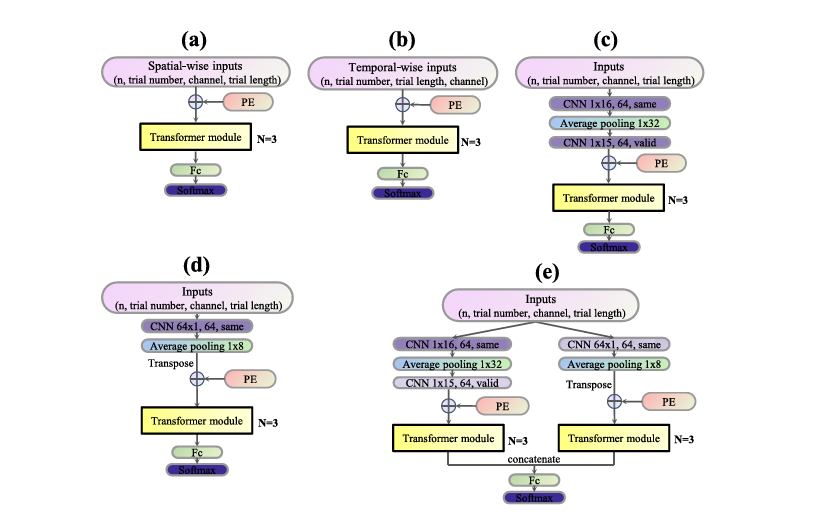

# <font color="pink"> Spatial CNN Transformer</font>


  <font color="lightblue">*In the spatial implementation of the CNN + Transformer
 model (s-CTrans, Fig. 3c), the CNN module included two
 convolutional layers and one average pooling layer. In the first
 convolutional layer, we used 64 kernels with the size of 1 × 16
 (channel × time points) to extract EEG temporal information,
 and adopted the SAME padding. The average pooling layer
 had the pooling size of 1 × 32. The second convolutional
 layer used 64 kernels with the size of 1 × 15, and adopted
 the VALID padding*</font>







In [ ]:
# Uses CNN to help extract temporal features per channel, then model channel relations
class SpatialCNNTransformer(nn.Module):
    def __init__(self, input_size, d_model=128, nhead=8, num_classes=2, feature_method='raw', feature_extractor=None):
        super(SpatialCNNTransformer, self).__init__()
        self.input_size = input_size
        self.feature_method = feature_method

        if feature_extractor != None or feature_extractor == 'csp':
            self.feature_extractor = feature_extractor
        elif feature_method in ['raw','stft']:
            self.feature_extractor = FeatureExtractor(model_class_name=self.__class__.__name__, method=feature_method)
        else:
            self.feature_extractor = None

        self.cnn, self.embedding = self._build_feature_layers(feature_method, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.transformer = nn.Sequential(*[TransformerBlock(d_model, nhead) for _ in range(3)])
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        if self.feature_extractor:
            x = self.feature_extractor(x)

        if self.feature_method == 'raw':   # x shape: (B, 1, C, T)
            x = self.cnn(x)
            if x.shape[3] == 1:
                x = x.squeeze(3).permute(2, 0, 1)
            else:
                x = x.mean(dim=-1)  # Reduce time dimension → [32, 64, 64]
                x = x.permute(2, 0, 1)  # → [C=64, B=32, F=64]


        elif self.feature_method == 'cnn':
            x = x.unsqueeze(1)
            x = self.cnn(x)
            B, Feat, C, T = x.shape
            x = x.permute(2, 0, 3, 1).reshape(C, B, T * Feat)  # (C, B, F*T)

        elif self.feature_method == 'csp':
            B, num_patches, token_dim = x.shape  # token_dim = n_csp * patch_size
            x = x.view(B, PATCH_SIZE, -1)  # (B, PATCH_SIZE, num_patches * n_csp)
            x = self.cnn(x)                # Apply 1D CNN
            x = x.view(B, -1)              # Flatten
            x = x.unsqueeze(0)             # (1, B, d_model) for transformer

        elif self.feature_method == 'stft':
            x = self.cnn(x)   # (B, FeatMap, C, H, W)
            B, FeatMap, C, H, W = x.shape
            # collapse frequency and feature maps → token features
            x = x.permute(0, 2, 4, 1, 3)        # (B, C, W, FeatMap, H)
            x = x.reshape(B, C, W, FeatMap * H) # (B, C, W, feat_dim)
            # average pool across time frames W
            x = x.mean(dim=2)                   # (B, C, feat_dim)
            x = x.permute(1, 0, 2)              # (C, B, feat_dim)

            if self.embedding.in_features != x.shape[-1]:
                self.embedding = nn.Linear(x.shape[-1], self.embedding.out_features).to(x.device)

        elif self.feature_method == 'wavelet':
            # x: (B, C, L, T_sub = Time steps after wavelet transform (per level))
            B, C, L, T_sub = x.shape
            x = x.reshape(B, 1, C , 1, T_sub* L)
            x = self.cnn(x)             # CNN designed for (B, 1, C, T)
            x = x.squeeze(3)            # removes dim 3 (H), shape: (B, F, C, T_out)
            x = x.permute(2, 0, 1, 3)   # (C, B, F, T_out)
            x = x.reshape(C, B, -1)     # flatten features = F * T_out

        elif self.feature_method == 'wavelet_packet':
            # x: (B, C, Nnodes, T_node)
            B, C, Nnodes, T_node = x.shape
            x = x.reshape(B, 1, C, 1, T_node * Nnodes)  # exactly parallel to wavelet
            x = self.cnn(x)                             # (B, FeatMap, C, 1, T_out)
            x = x.squeeze(3)                            # (B, FeatMap, C, T_out)
            x = x.permute(2, 0, 1, 3)                   # (C, B, FeatMap, T_out)
            x = x.reshape(C, B, -1)                     # (C, B, feat_dim)


            if self.embedding is None:
                in_features = x.shape[-1]
                self.embedding = nn.Linear(in_features, self.fc.in_features).to(x.device)

        else:
            raise ValueError(f"Unsupported feature method: {self.feature_method}")

        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x.mean(dim=0)
        return self.fc(x)


    def _build_feature_layers(self, feature_method, d_model):
        """
        Build CNN and embedding layers based on feature_method.
        """
        if feature_method == 'raw':
            # Input: (B, 1, C, T)
            cnn = nn.Sequential(
                nn.Conv2d(1, 64, (1, 16), padding='same'),
                nn.ReLU(),
                nn.AvgPool2d((1, 32)),
                nn.Conv2d(64, 64, (1, 15), padding='valid'),
                nn.ReLU()
            )
            embedding = nn.Linear(64, d_model)  # Precomputed flattened size

        elif feature_method == 'csp':
            # Input: (B, k, T)
            cnn = nn.Sequential(
                nn.Conv1d(in_channels=PATCH_SIZE, out_channels=64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv1d(64, 128, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.AdaptiveAvgPool1d(output_size=32)
            )
            with torch.no_grad():
                dummy_input = torch.zeros(1, PATCH_SIZE, NUM_COMP * PATCH_SIZE)
                out = cnn(dummy_input)
            flat_feat_size = out.shape[1] * out.shape[2]
            embedding = nn.Linear(flat_feat_size, d_model)

        elif feature_method == 'stft':
            # Input: (B, 2, C, F, T')
            cnn = nn.Sequential(
                nn.Conv3d(2, 32, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
                nn.ReLU(),
                nn.AvgPool3d((1, 2, 2)),
                nn.Conv3d(32, 64, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
                nn.ReLU(),
                nn.AvgPool3d((1, 2, 2))
            )
            with torch.no_grad():
                dummy_input = torch.zeros(1, 2, 64, 65, 16)  # (B=1, 2, C=64, F=65, T'=16)
                out = cnn(dummy_input)                    # Output: (1, 64, C, H, W)
            _, FeatMap, C, H, W = out.shape
            flat_feat_size = H * W * FeatMap
            embedding = nn.Linear(flat_feat_size, d_model)

        elif feature_method == 'wavelet':
            # Input: (B, CL, T)
            cnn = nn.Sequential(
                nn.Conv3d(1, 32, kernel_size=(1, 1, 3), padding=(0, 0, 1)),
                nn.ReLU(),
                nn.AvgPool3d((1, 1, 2)),
                nn.Conv3d(32, 64, kernel_size=(1, 1, 3), padding=(0, 0, 1)),
                nn.ReLU(),
                nn.AvgPool3d((1, 1, 2))
            )
            with torch.no_grad():
                dummy_input = torch.zeros(1, 64, self.input_size)  # (B=1, CL=256, T=244)
                dummy_input = dummy_input.unsqueeze(1).unsqueeze(3)  # (1, 1, 256, 1, 244)
                out = cnn(dummy_input)                    # Output: (1, 64, 256, 1, T_sub)
            _, FeatMap, CL, _, T_sub = out.shape
            flat_feat_size = FeatMap * T_sub
            embedding = nn.Linear(flat_feat_size, d_model)

        elif feature_method == 'wavelet_packet':
            # CNN przyjmuje (B, 1, C, Nnodes, T_node)
            cnn = nn.Sequential(
                nn.Conv3d(1, 32, kernel_size=(1, 1, 3), padding=(0, 0, 1)),
                nn.ReLU(),
                nn.AvgPool3d((1, 1, 2)),
                nn.Conv3d(32, 64, kernel_size=(1, 1, 3), padding=(0, 0, 1)),
                nn.ReLU(),
                nn.AvgPool3d((1, 1, 2))
            )
            with torch.no_grad():
                dummy_input = torch.zeros(1, 64, self.input_size)  # (B=1, CL=256, T=244)
                dummy_input = dummy_input.unsqueeze(1).unsqueeze(3)  # (1, 1, 256, 1, 244)
                out = cnn(dummy_input)                    # Output: (1, 64, 256, 1, T_sub)
            _, FeatMap, CN, _, T_sub = out.shape
            flat_feat_size = FeatMap * T_sub
            embedding = nn.Linear(flat_feat_size, d_model)
            return cnn, embedding

        elif feature_method == 'cnn':
            cnn = nn.Sequential(
                # extractor’s CNN
                nn.Conv2d(1,  64, (1,16), padding='same'),
                nn.ReLU(),
                nn.AvgPool2d((1,32)),
                nn.Conv2d(64, 64, (1,15), padding='valid'),
                nn.ReLU(),

                # second block
                nn.Conv2d(64, 64, (1, 3), padding='same'),
                nn.ReLU(),
                nn.AvgPool2d((1, 2)),
                nn.Conv2d(64, 64, (1, 3), padding='same'),
                nn.ReLU(),
            )

            dummy_input = torch.zeros(1, 1, 64, self.input_size)  # (B,1,C,T)
            with torch.no_grad():
                out = cnn(dummy_input)
            _, Feat, C, T_out = out.shape
            flat_feat_size = Feat * T_out
            embedding = nn.Linear(flat_feat_size, d_model)
            return cnn, embedding

        else:
            cnn = None
            embedding = nn.Linear(input_size, d_model)

        return cnn, embedding


# <font color="pink"> Temporal CNN Transformer</font>

  <font color="lightblue">*In the temporal implementation of the CNN + Transformer
 model (t-Ctrans, Fig 3d), the CNN module included one
 convolutional layer and one average pooling layer. The con
volutional layer used 64 kernels with the size of 64 × 1(chan
nel × time points) to extract EEG spatial information, and
 adopted the SAME padding. The average pooling layer had
 the pooling size of 1 × 8. After the average pooling layer,
 we transposed the features.*</font>


In [ ]:
# Uses CNN to help extract spatial features per time point, then model time dynamics
class TemporalCNNTransformer(nn.Module):
    def __init__(self, input_size, d_model=128, nhead=8, num_classes=2, feature_method='raw', feature_extractor=None):
        super(TemporalCNNTransformer, self).__init__()
        self.feature_method = feature_method
        self.input_size = input_size

        if feature_extractor != None: #or feature_extractor == 'csp':
            self.feature_extractor = feature_extractor
        elif feature_method in ['raw', 'cnn', 'csp', 'stft']:
            self.feature_extractor = FeatureExtractor(model_class_name=self.__class__.__name__, method=feature_method) if feature_method != 'none' else None
        else:
            self.feature_extractor = None

        self.cnn, self.embedding = self._build_feature_layers(feature_method, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.transformer = nn.Sequential(*[TransformerBlock(d_model, nhead) for _ in range(3)])
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        if self.feature_extractor:
            x = self.feature_extractor(x)

        if self.feature_method == 'raw':  # x shape: (B, 1, C, T)
            x = self.cnn(x)               # → (B, 64, 1, T_new)
            x = x.mean(dim=2)             # → (B, 64, T_new)
            x = x.permute(2, 0, 1)        # (time, batch, features)

        elif self.feature_method == 'cnn':
            x = self.cnn(x)               # (B, 64, C', T')
            x = x.mean(dim=2)             # → (B, 64, T)
            x = x.permute(2, 0, 1)        # (T, B, 64)

        elif self.feature_method == 'csp':
            # x: (B, num_patches, n_csp * patch_size)
            x = x.unsqueeze(1).permute(0, 1, 3, 2)    # (B, 1, n_csp*patch_size, num_patches)
            x = self.cnn(x)                           # e.g. (B, C_out, 1, T_new)
            B, C, H, T_new = x.shape
            x = x.view(B, T_new, -1)                  # (B, T_new, C*H)
            x = x.permute(1, 0, 2)                    # (T_new, B, features)
            if self.embedding.in_features != x.shape[-1]:
                self.embedding = nn.Linear(x.shape[-1], self.embedding.out_features).to(x.device)

        elif self.feature_method == 'stft':
            x = self.cnn(x)               # (B, FeatMap, C, H, W)
            B, FeatMap, C, H, W = x.shape
            # merge channel × freq × features
            x = x.permute(0, 4, 2, 3, 1).reshape(B, W, C * H * FeatMap)  # (B, W, feat_dim)
            # instead of using the full feat_dim, compress first:
            x = x.permute(1, 0, 2)        # (W, B, d_model)

            if self.embedding.in_features != x.shape[-1]:
                self.embedding = nn.Linear(x.shape[-1], self.embedding.out_features).to(x.device)

        elif self.feature_method == 'wavelet':
            B, C, L, T_sub = x.shape
            x = x.reshape(B, 1, C * L, 1, T_sub)  # (B, 1, CL, 1, T_sub)
            x = self.cnn(x)               # (B, F, CL, H, T_sub)
            B, FeatMap, CL, H, T_sub = x.shape
            x = x.permute(0, 4, 2, 3, 1).reshape(B, T_sub, -1)  # (B, T_sub, flat_feat_size)
            x = x.permute(1, 0, 2)        # (T_sub, B, flat_feat_size)

        elif self.feature_method == 'wavelet_packet':
            # x: (B, C, Nnodes, T_node)
            B, C, Nnodes, T_node = x.shape
            x = x.reshape(B, 1, C * Nnodes , 1, T_node)  # analogicznie do wavelet
            x = self.cnn(x)                             # (B, FeatMap, CL, H, T_out)
            B, FeatMap, CN, H, T_sub = x.shape
            x = x.permute(0, 4, 2, 3, 1).reshape(B, T_sub, -1)  # (B, T_sub, flat_feat_size)
            x = x.permute(1, 0, 2)        # (T_sub, B, flat_feat_size)

            if self.embedding is None:
                in_features = x.shape[-1]
                self.embedding = nn.Linear(in_features, self.fc.in_features).to(x.device)

        else:
            raise ValueError(f"Unsupported feature method: {self.feature_method}")

        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x.mean(dim=0)
        return self.fc(x)

    def _build_feature_layers(self, feature_method, d_model):
        """
        Build CNN and embedding based on feature_method.
        """
        if feature_method == 'raw':
            # Input: (B, 1, C, T)
            cnn = nn.Sequential(
                nn.Conv2d(1, 64, kernel_size=(64, 1), padding='same'),
                nn.ReLU(),
                nn.AvgPool2d((1, 8))
            )
            embedding = nn.Linear(64, d_model)

        elif feature_method == 'csp':
            cnn = nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=(4, 1)),
                nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size=(3, 1)),
                nn.ReLU()
            )
            with torch.no_grad():
                dummy_input = torch.zeros(1, 1, NUM_COMP * PATCH_SIZE, self.input_size)
                out = cnn(dummy_input)   # (1, C, H, W)
            B, C, H, W = out.shape
            flat_feat_size = C * H      # ✅ not just C
            embedding = nn.Linear(flat_feat_size, d_model)


        elif feature_method == 'stft':
            # Input: (B, 2, C, F, T')
            cnn = nn.Sequential(
                nn.Conv3d(2, 32, kernel_size=(1, 3, 3), padding=(0, 1, 1)),  # → (B, 32, C, F, T')
                nn.ReLU(),
                nn.AvgPool3d(kernel_size=(1, 2, 2)),
                nn.Conv3d(32, 64, kernel_size=(1, 3, 3), padding=(0, 1, 1)), # → (B, 64, C, F, T')
                nn.ReLU(),
                nn.AvgPool3d(kernel_size=(1, 2, 2))
            )
            with torch.no_grad():
                dummy_input = torch.zeros(1, 2, 64, 65, 16)   # (B=1, 2, C=64, F=65, T'=16)
                out = cnn(dummy_input)                        # Output: (1, 64, C, H, W)
            B, FeatMap, C, H, W = out.shape
            flat_feat_size = FeatMap * C * H
            embedding = nn.Linear(flat_feat_size, d_model)

        elif feature_method == 'wavelet':
            # Input: (B, 1, coeff_len, 1, T')
            cnn = nn.Sequential(
                nn.Conv3d(1, 16, kernel_size=(1, 1, 3), padding=(0, 0, 1)), # → (B, 16, coeff_len, 1, T')
                nn.ReLU(),
                nn.AvgPool3d(kernel_size=(1, 1, 2)),
                nn.Conv3d(16, 32, kernel_size=(1, 1, 3), padding=(0, 0, 1)),# → (B, 32, coeff_len, 1, T')
                nn.ReLU(),
                nn.AvgPool3d(kernel_size=(1, 1, 2))
            )
            with torch.no_grad():
                dummy_input = torch.zeros(1, 1, 256, 1, self.input_size)  # (B=1, 1, CL=256, 1, T'=244)
                out = cnn(dummy_input)                        # Output: (1, 32, CL, 1, T')
            B, FeatMap, CL, H, T_sub = out.shape
            flat_feat_size = FeatMap * CL * H
            embedding = nn.Linear(flat_feat_size, d_model)

        elif feature_method == 'wavelet_packet':
            # Input: (B, 1, CL=C*Nnodes, 1, T_node) lub (B, 1, C*Nnodes, 1, T_node)
            cnn = nn.Sequential(
                nn.Conv3d(1, 16, kernel_size=(1, 1, 3), padding=(0, 0, 1)),
                nn.ReLU(),
                nn.AvgPool3d((1, 1, 2)),
                nn.Conv3d(16, 32, kernel_size=(1, 1, 3), padding=(0, 0, 1)),
                nn.ReLU(),
                nn.AvgPool3d((1, 1, 2))
            )

            if SEGMENT_SIZE == 6:   # 6s segment
                T_node = 135
            elif SEGMENT_SIZE == 3:  # 3s segment
                T_node = 75

            dummy_input = torch.zeros(1, 1, 64*8, 1, T_node)  # (B=1, 1, C*Nnodes, 1, T_node)
            with torch.no_grad():
                out = cnn(dummy_input)
            B, FeatMap, CN, H, T_sub = out.shape
            flat_feat_size = FeatMap * CN * H
            embedding = nn.Linear(flat_feat_size, d_model)
            return cnn, embedding

        elif feature_method == 'cnn':
            # Input: (B, 64, C, T)
            cnn = nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=(16, 1), padding='same'), # → (B, 64, C, T)
                nn.ReLU(),
                nn.AvgPool2d((1, 4))
            )
            embedding = nn.Linear(64, d_model)

        else:
            cnn = None
            embedding = nn.Linear(64, d_model)

        return cnn, embedding



# <font color="pink"> FusionCNNTransformer</font>

In [ ]:
# Combine both spatial and temporal CNN Transformer
class FusionCNNTransformer(nn.Module):
    def __init__(self, input_size, d_model=128, nhead=8, num_classes=2, feature_method='raw', feature_extractor=None):
        super(FusionCNNTransformer, self).__init__()

        self.feature_extractor = feature_extractor
        if feature_method in ['wavelet', 'wavelet_packet', 'csp']:
            spatial_input_size, temporal_input_size = input_size
        else:
            spatial_input_size = temporal_input_size = input_size


        self.s_cnn = SpatialCNNTransformer(spatial_input_size, d_model, nhead, num_classes, feature_method, feature_extractor=self.feature_extractor)
        self.t_cnn = TemporalCNNTransformer(temporal_input_size, d_model, nhead, num_classes, feature_method, feature_extractor=self.feature_extractor)
        self.fc = nn.Linear(num_classes * 2, num_classes)

    def forward(self, x):
        spatial_out = self.s_cnn(x)
        temporal_out = self.t_cnn(x)
        fusion = torch.cat((spatial_out, temporal_out), dim=1)
        return self.fc(fusion)

---

# <font color="pink"> Przygotowanie danych do treningu w PyTorch</font>

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

class EEGDataset(Dataset):
  def __init__(self, X, y, cnn_mode=False, feature_method='raw'):
    self.X = torch.tensor(X, dtype=torch.float32)

    if cnn_mode and feature_method == 'raw':
      self.X = self.X.unsqueeze(1)
    self.y = torch.tensor(y, dtype=torch.long)

  def __len__(self):
      return len(self.X)
  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]


In [ ]:
import bisect
import numpy as np
import torch
from torch.utils.data import Dataset

class EEGDatasetFromList(Dataset):
    """
    Lazy dataset that indexes into a list of per-subject arrays without concatenating them.

    X_list: list/tuple of arrays, each shape (n_epochs_i, C, T) or (n_epochs_i, 1, C, T)
    y_list: list/tuple of arrays, each shape (n_epochs_i,)
    cnn_mode, feature_method kept for compatibility with the rest of your code
    """
    def __init__(self, X_list, y_list, cnn_mode=False, feature_method='raw'):
        super().__init__()
        self.X_list = list(X_list)
        self.y_list = list(y_list)
        self.cnn_mode = cnn_mode
        self.feature_method = feature_method

        lengths = [int(x.shape[0]) for x in self.X_list]
        self.cum_lengths = np.cumsum([0] + lengths)  # start with 0
        self.total_len = int(self.cum_lengths[-1])

    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):
        if idx < 0:
            idx = self.total_len + idx
        # map global index -> (subject_index, local_index)
        s_idx = bisect.bisect_right(self.cum_lengths, idx) - 1
        local_idx = idx - self.cum_lengths[s_idx]
        x = self.X_list[s_idx][local_idx]
        y = self.y_list[s_idx][local_idx]

        # normalize dtype and shape to what downstream expects:
        x = np.asarray(x, dtype=np.float32)

        # Ensure per-sample shape is (1, C, T) for downstream FeatureExtractor/model
        # Common input variants:
        # - (C, T) -> convert to (1, C, T)
        # - (1, C, T) -> keep
        # - (n_channels, n_times) -> treat as (C,T)
        if x.ndim == 2:
            # (C, T) -> (1, C, T)
            x = np.expand_dims(x, axis=0)
        elif x.ndim == 3:
            # keep (1, C, T) as-is; if it's (n_epochs, C, T) that's wrong here since we index per-epoch
            pass
        else:
            raise RuntimeError(f"Unexpected sample ndim={x.ndim} in EEGDatasetFromList")

        # For cnn_mode+raw your old EEGDataset did an unsqueeze(1) producing (B,1,C,T);
        # now samples are (1,C,T) and DataLoader will produce (B,1,C,T) — consistent.
        x_t = torch.tensor(x, dtype=torch.float32)
        y_t = torch.tensor(int(y), dtype=torch.long)
        return x_t, y_t



*Training Parameter Settings:*
<font color="lightblue">
* *Empirically, the number of
 head in each multi-head attention layer was set to 8 [25].*
* *The dropout rate was set to 0.3.*
* *The parameter of the position-wise fully connected feed-forward layer with a ReLU activation was set to 512.*
* *The weight attenuation was 0.0001.*
* *All the models used the Adam optimizer. The training epoch was set
 to 50.*
* *The EEG data were transformed into 3D tensors (N, C, T), where N is the number of trials, C is the number of channels, and T is the time points.*
* *In our Transformer-based models,
 we set dk = dv = 64, which was the same size as EEG
 channel numbers.*</font>



In [ ]:
import mne
import os
import csv
import numpy as np
from torchmetrics.classification import Accuracy
from sklearn.metrics import confusion_matrix

dataset = "Physionet"
preprocessed_data_dir = f"/content/drive/My Drive/EEG_Data/{dataset}"
d_model = 64
nhead = 8
num_classes = 2
batch_size = 32
num_epochs = 50
weight_decay=1e-4
cnn_models = {"SpatialCNNTransformer", "TemporalCNNTransformer", "FusionCNNTransformer"}

def load_subject_data(file_path) ->tuple[np.ndarray, np.ndarray]:
    epochs = mne.read_epochs(file_path, preload=True)
    """
    Number of epochs, channels, n_times -> Liczba punktów czasowych w jednym epizodzie EEG (czyli długość sygnału w czasie).
                                          Dla danych 3-sekundowych:
                                          EEG było próbkowane z częstotliwością 160 Hz

                                          3 sekundy × 160 Hz = 480 punktów

                                          Więc: n_times = 480

                                          Dla danych 6-sekundowych:
                                          6 sekundy × 160 Hz = 960 punktów

                                          Więc: n_times = 960
    """
    X = epochs.get_data()

    # Labels
    y = epochs.events[:, -1]

    # Labels should be numered 0, 1, 2 ...
    y = np.array([0 if label == 2 else 1 for label in y])
    return X, y

def one_batch_diagnostic(model, loader, device, lr=1e-4):
    model.to(device)
    model.train()
    xb, yb = next(iter(loader))
    xb, yb = xb.to(device), yb.to(device)
    print("DATA device / shapes:", xb.device, xb.shape, "labels:", yb.shape, yb.dtype)
    # feature extractor
    if hasattr(model, 'feature_extractor') and model.feature_extractor:
        with torch.no_grad():
            feat = model.feature_extractor(xb)   # e.g. (B, num_patches, token_dim)
        print("feature_extractor out:", feat.shape, "mean/std:", float(feat.mean()), float(feat.std()))
        # per-token std (across batch)
        try:
            per_token_std_mean = feat.std(dim=0).mean().item()
            print("per-token std mean:", per_token_std_mean)
        except:
            pass
    else:
        feat = xb
    # run forward (full), backward, inspect grads
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer.zero_grad()
    out = model(xb)
    print("logits shape:", out.shape, "min/max/mean/std:", float(out.min()), float(out.max()), float(out.mean()), float(out.std()))
    preds = out.argmax(dim=1)
    print("pred counts (first batch):", torch.unique(preds, return_counts=True))
    loss = criterion(out, yb.long())
    print("loss:", float(loss))
    loss.backward()
    # print some gradient norms
    grads = []
    for name, p in model.named_parameters():
        if p.grad is None:
            grads.append((name, None))
        else:
            grads.append((name, float(p.grad.norm())))
    # show top/bottom grads
    print("parameter gradients (name, grad_norm), first 20 entries:")
    for e in grads[:20]:
        print(e)
    # global grad norm
    total_grad_norm = 0.0
    cnt = 0
    for _, p in model.named_parameters():
        if p.grad is not None:
            total_grad_norm += float(p.grad.norm().cpu().item())**2
            cnt += 1
    total_grad_norm = (total_grad_norm**0.5) if cnt>0 else 0.0
    print("total grad norm:", total_grad_norm)
    optimizer.step()


def train_model(model, train_loader, test_loader, device, lr):
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=7e-4, weight_decay=1e-4)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss)

        # Evaluate using evaluate_model_with_confusion:
        test_acc, _ = evaluate_model_with_confusion(model, test_loader, device)
        test_accuracies.append(test_acc * 100)  # Convert to percentage

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Test Acc: {test_acc:.4f}")

    return train_losses, test_accuracies


def evaluate_model(model, test_loader, device)-> float:
    acc = Accuracy(task='binary').to(device)
    model.eval()

    with torch.no_grad():
      for X_batch, y_batch in test_loader:
          X_batch, y_batch = X_batch.to(device), y_batch.to(device)
          output = model(X_batch)
          preds = torch.argmax(output, dim=1)
          acc.update(preds, y_batch)

    return acc.compute().item()

def evaluate_model_with_confusion(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    acc = np.mean(all_preds == all_labels)
    cm = confusion_matrix(all_labels, all_preds)
    return acc, cm


def save_results_to_csv(results, average_accuracy, model_class, feature_method, learning_rate, segment_size = 6):
    filename_parts = [model_class.__name__, feature_method, str(learning_rate)]
    if feature_method == 'stft':
        filename_parts.insert(2, f"nfft{N_FFT}_hop{HOP_LENGTH}")
    elif feature_method == 'wavelet':
        filename_parts.insert(2, f"{WAVELET_TYPE}_levels{LEVEL_COUNT}")
    elif  feature_method == 'wavelet_packet':
        filename_parts.insert(2, f"{WAVELET_TYPE}_levels{LEVEL_COUNT}")
    elif feature_method == 'csp':
        filename_parts.insert(2, f"numcomp{NUM_COMP}_patchsize{PATCH_SIZE}")

    output_csv = f"/content/drive/My Drive/EEG_Data/{dataset}/{segment_size}s/fold_cross_subject_accuracies_{'_'.join(filename_parts)}.csv"

    with open(output_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Fold", "Accuracy"])
        for i, acc in enumerate(results):
            writer.writerow([f"Fold {i + 1}", acc * 100])
        writer.writerow(["Average", average_accuracy * 100])

    print(f"Results saved to {output_csv}")
    return output_csv


def plot_metrics(avg_train_losses, avg_test_accuracies, output_csv):
    def plot_metric(values, ylabel, title, filename_suffix, color):
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, num_epochs + 1), values, label=ylabel, color=color)
        plt.xlabel('Epoch')
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.savefig(filename_suffix)
        plt.show()

    loss_plot_path = output_csv.replace("fold_cross_subject_accuracies", "train_loss_curve").replace(".csv", ".png")
    acc_plot_path = output_csv.replace("fold_cross_subject_accuracies", "test_accuracy_curve").replace(".csv", ".png")

    plot_metric(avg_train_losses, 'Loss', 'Training Loss Across Folds', loss_plot_path, 'blue')
    plot_metric(avg_test_accuracies, 'Accuracy (%)', 'Test Accuracy Across Folds', acc_plot_path, 'green')


---

# <font color="pink">5fold cross-individual</font>





In [ ]:
def get_input_size(model_class_name, feature_method, raw_shape,
                   n_csp_components=NUM_COMP, cnn_out_channels=64,
                   n_fft=128, hop_length=32, wavelet_coeff_len=976):
    """
    Compute input size to embedding layer for Transformer models.
    Returns either int or tuple of (spatial_input_size, temporal_input_size) for fusion models.
    """

    model_class_name = model_class_name.lower()
    feature_method = feature_method.lower()

    if feature_method in ['raw', 'csp', 'stft', 'cnn']:
        _, C, T = raw_shape
    elif feature_method == 'wavelet':
        _, C, L, T_sub = raw_shape
    elif feature_method == 'wavelet_packet' or feature_method == 'wavelet_packet_2':
        _, C, Nnodes, T_node = raw_shape
    else:
        raise ValueError(f"Unsupported feature method: {feature_method}")

    def is_spatial(): return "spatial" in model_class_name
    def is_temporal(): return "temporal" in model_class_name
    def is_fusion(): return "fusion" in model_class_name
    def is_spatial_cnn(): return "spatialcnn" in model_class_name
    def is_temporal_cnn(): return "temporalcnn" in model_class_name

    if feature_method == 'raw':
        return T if is_spatial() else C if is_temporal() else T

    elif feature_method == 'csp':
        patch_size = PATCH_SIZE
        token_dim = n_csp_components * patch_size
        num_patches = T // patch_size
        print(f"num_patches {num_patches}")
        spatial_size = token_dim
        temporal_size = num_patches
        return (spatial_size, temporal_size) if is_fusion() else (spatial_size if is_spatial() else temporal_size)

    elif feature_method == 'cnn':
        return cnn_out_channels if is_temporal() else T

    elif feature_method == 'stft':
          # determine number of STFT channels produced by FeatureExtractor
          if STFT_REPR in ['realimag', 'magphase']:
              stft_channels = 2
          elif STFT_REPR == 'magsincos':
              stft_channels = 3
          else:
              raise ValueError(f"Unknown stft_repr: {STFT_REPR}")

          freq_bins = n_fft // 2 + 1
          padding = n_fft // 2
          # compute number of STFT time frames (integer)
          stft_time_frames = 1 + (T + 2 * padding - n_fft) // hop_length

          spatial_size = stft_channels * freq_bins            # per-channel token size for spatial transformer
          temporal_size = C * freq_bins * stft_channels         # per-time token size for temporal transformer

          return (spatial_size, temporal_size) if is_fusion() else (spatial_size if is_spatial() else temporal_size)

    elif feature_method == 'wavelet_packet':
        # raw_shape assumed (B, C, Levels_nodes, T_node)
        _, C, Nnodes, T_node = raw_shape
        spatial_size = Nnodes * T_node
        temporal_size = C * Nnodes
        return (spatial_size, temporal_size) if is_fusion() else (spatial_size if is_spatial() else temporal_size)

    elif feature_method == 'wavelet_packet_2':
        # raw_shape assumed (B, C, Nnodes, n_features)
        _, C, Nnodes, n_features = raw_shape
        spatial_size = Nnodes * n_features
        temporal_size = C * Nnodes
        return (spatial_size, temporal_size) if is_fusion() else (spatial_size if is_spatial() else temporal_size)

    elif feature_method == 'wavelet':
        spatial_size = L * T_sub
        temporal_size = C * L

        if is_fusion():
            return (spatial_size, temporal_size)
        elif is_spatial_cnn():
            return wavelet_coeff_len
        elif is_temporal_cnn():
            return wavelet_coeff_len
        elif is_spatial():
            return spatial_size
        elif is_temporal():
            return temporal_size
        else:
            raise ValueError(f"Unknown model class: {model_class_name}")

    else:
        raise ValueError(f"Unsupported feature method: {feature_method}")


In [ ]:
def preload_subject_data(preprocessed_data_dir, segment_size = 6,  max_subjects=None):
    """
    Preload EEG data for a limited number of subjects.

    Args:
        preprocessed_data_dir (str): Directory containing subject folders.
        max_subjects (int, optional): Max number of subjects to preload. If None, load all.

    Returns:
        dict: {subject_folder_name: (X, y)}
    """
    subject_data = {}
    all_subjects = sorted(os.listdir(preprocessed_data_dir))

    if max_subjects is not None:
        all_subjects = all_subjects[:max_subjects]  # Limit to first N subjects

    for subj_folder in all_subjects:
        subj_folder_path = os.path.join(preprocessed_data_dir, subj_folder)
        file_path = os.path.join(subj_folder_path, f"PA{subj_folder[1:]}-{segment_size}s-epo.fif")
        if os.path.exists(file_path):
            X, y = load_subject_data(file_path)
            subject_data[subj_folder] = (X, y)
        else:
            print(f"[WARNING] File not found for {subj_folder}: {file_path}")

    return subject_data

subject_data_preload = preload_subject_data(preprocessed_data_dir, SEGMENT_SIZE, 109)

[WARNING] File not found for 3s: /content/drive/My Drive/EEG_Data/Physionet/3s/PAs-6s-epo.fif
[WARNING] File not found for 6s: /content/drive/My Drive/EEG_Data/Physionet/6s/PAs-6s-epo.fif
Reading /content/drive/My Drive/EEG_Data/Physionet/S001/PA001-6s-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    1000.00 ...    7000.00 ms
        0 CTF compensation matrices available
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Reading /content/drive/My Drive/EEG_Data/Physionet/S002/PA002-6s-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    1000.00 ...    7000.00 ms
        0 CTF compensation matrices available
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Reading /content/drive/My Drive/EEG_Data/Physionet/S003/PA003-6s-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    1000.00 ...    7000.00 ms
    

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader

def split_epochs_to_subwindows(X, y, n_splits=10):
    """
    Dzielenie epok na mniejsze fragmenty (np. 10x więcej danych).
    X: (n_epochs, C, T)
    y: (n_epochs,)
    Zwraca:
        X_aug: (n_epochs * n_splits, C, win_len)
        y_aug: (n_epochs * n_splits,)
    """
    n_epochs, C, T = X.shape
    win = int(np.ceil(T / n_splits))
    stride = max(1, (T - win) // (n_splits - 1)) if n_splits > 1 else T

    X_list, y_list = [], []
    for i in range(n_epochs):
        starts = list(range(0, T - win + 1, stride))
        if len(starts) < n_splits:
            # dodaj okna końcowe
            while len(starts) < n_splits:
                starts.append(T - win)
        starts = starts[:n_splits]

        for s in starts:
            sub = X[i, :, s:s+win]
            if sub.shape[1] < win:
                pad = np.zeros((C, win - sub.shape[1]), dtype=sub.dtype)
                sub = np.concatenate([sub, pad], axis=1)
            X_list.append(sub)
            y_list.append(y[i])

    X_aug = np.stack(X_list, axis=0)
    y_aug = np.array(y_list, dtype=y.dtype)
    return X_aug, y_aug

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader

def train_5fold_cross_validation(model_class, learning_rate, feature_method, subject_data, n_csp_components=NUM_COMP):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results, all_train_losses, all_test_accuracies = [], [], []
    total_correct = total_samples = 0

    subject_data_copy = subject_data.copy()
    if feature_method == 'wavelet' or feature_method == 'wavelet_packet' or feature_method == 'wavelet_packet_2':
        subject_data_copy = precompute_subject_features(model_class.__name__, subject_data_copy, feature_method)

    if dataset_name == "Physionet" and augment_physionet:
        print("[INFO] Augmenting Physionet epochs into subwindows...")
        for subj in subject_data_copy.keys():
            Xs, ys = subject_data_copy[subj]
            if Xs is not None and len(Xs) > 0:
                X_aug, y_aug = split_epochs_to_subwindows(Xs, ys, n_splits=10)
                subject_data_copy[subj] = (X_aug, y_aug)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    keys_all = list(subject_data_copy.keys())

    for fold, (train_idx, test_idx) in enumerate(kf.split(subject_data_copy)):
        print(f"\nFold {fold + 1}/5")

        keys = keys_all
        #X_train, y_train = zip(*[subject_data_copy[keys[i]] for i in train_idx])
        #X_test, y_test = zip(*[subject_data_copy[keys[i]] for i in test_idx])

        X_train_list = [subject_data_copy[keys[i]][0] for i in train_idx]  # each element: X_sub (n_epochs_i,...)
        y_train_list = [subject_data_copy[keys[i]][1] for i in train_idx]
        X_test_list  = [subject_data_copy[keys[i]][0] for i in test_idx]
        y_test_list  = [subject_data_copy[keys[i]][1] for i in test_idx]
        #X_train, y_train = np.concatenate(X_train), np.concatenate(y_train)
        #X_test, y_test = np.concatenate(X_test), np.concatenate(y_test)

        cnn_mode = model_class.__name__ in cnn_models


        if feature_method == 'csp':
            # ========= CSP (memory-safe) path =========
            print("Fitting CSP incrementally on per-subject data (memory safe)...")
            # compute filters without concatenating
            filters = compute_csp_filters_from_subjects(X_train_list, y_train_list, n_components=n_csp_components)

            # prepare feature extractor and inject filters
            csp_extractor = FeatureExtractor(model_class.__name__, 'csp', n_csp_components)
            csp_extractor.filters_ = filters
            csp_extractor.csp_fitted = True
            csp_extractor.n_csp_components_actual = filters.shape[0]

            # lazy datasets (no concat)
            train_loader = DataLoader(EEGDatasetFromList(X_train_list, y_train_list, cnn_mode, feature_method),
                                      batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
            test_loader = DataLoader(EEGDatasetFromList(X_test_list, y_test_list, cnn_mode, feature_method),
                                     batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

            # Build a raw_shape approx for get_input_size:
            total_train_epochs = sum([int(x.shape[0]) for x in X_train_list])
            # peek into first non-empty subarray to find C,T
            for Xs in X_train_list:
                if Xs is not None and len(Xs) > 0:
                    first_sample = Xs[0]
                    break
            if first_sample.ndim == 3 and first_sample.shape[0] == 1:
                C = first_sample.shape[1]
                T = first_sample.shape[2]
            elif first_sample.ndim == 2:
                C = first_sample.shape[0]
                T = first_sample.shape[1]
            else:
                raise RuntimeError("Cannot infer C,T from CSP training data")

            raw_shape = (total_train_epochs, C, T)

        else:
            X_train = np.concatenate(X_train_list, axis=0)
            y_train = np.concatenate(y_train_list, axis=0)
            X_test  = np.concatenate(X_test_list, axis=0)
            y_test  = np.concatenate(y_test_list, axis=0)

            train_loader = DataLoader(EEGDataset(X_train, y_train, cnn_mode, feature_method), batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(EEGDataset(X_test, y_test, cnn_mode, feature_method), batch_size=batch_size, shuffle=False)

            raw_shape = X_train.shape
            csp_extractor=None
            print("[DEBUG] Input to model:", raw_shape)

        if feature_method == 'wavelet' or feature_method == 'wavelet_packet' or feature_method == 'wavelet_packet_2':
            #For CNN models
            wavelet_coeff_len = (raw_shape[2] * raw_shape[3]) if "Spatial" in model_class.__name__ else raw_shape[3]
        else:
            wavelet_coeff_len = 0

          # stft_freq_bins = N_FFT // 2 + 1
        input_size = get_input_size(
            model_class.__name__,
            feature_method,
            raw_shape,
            n_csp_components=n_csp_components,
            cnn_out_channels=64,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            wavelet_coeff_len=wavelet_coeff_len
          )

        model = model_class(input_size=input_size, nhead=nhead,
                            num_classes=num_classes, feature_method=feature_method, feature_extractor=csp_extractor)
        #quick_forward_debug(model, train_loader, device)

        #X_small, y_small = next(iter(train_loader))
        #X_small, y_small = X_small.to(device), y_small.to(device)
        #overfit_small_batch(model, X_small, y_small, device, iters=200)

        train_losses, test_accuracies = train_model(model, train_loader, test_loader, device, learning_rate)
        all_train_losses.append(train_losses)
        all_test_accuracies.append(test_accuracies)

        accuracy, cm = evaluate_model_with_confusion(model, test_loader, device)
        print(f"Accuracy for fold {fold + 1}: {accuracy * 100:.2f}%")
        print(f"Confusion Matrix:\n{cm}")

        results.append(accuracy)
        total_samples += len(test_loader.dataset)
        total_correct += accuracy * len(test_loader.dataset)

    average_accuracy = np.mean(results)
    print(f"\nAverage accuracy across 5 folds: {average_accuracy * 100:.2f}%")

    # Save results and plot metrics
    output_csv = save_results_to_csv(results, average_accuracy, model_class, feature_method, learning_rate, SEGMENT_SIZE)

    avg_train_losses = np.mean(all_train_losses, axis=0)
    avg_test_accuracies = np.mean(all_test_accuracies, axis=0)
    plot_metrics(avg_train_losses, avg_test_accuracies, output_csv)

db4
Precomputing wavelet_packet features for all subjects...
[DEBUG] S001: X_feat shape = (42, 64, 8, 75)
[DEBUG] S002: X_feat shape = (42, 64, 8, 75)
[DEBUG] S003: X_feat shape = (42, 64, 8, 75)
[DEBUG] S004: X_feat shape = (42, 64, 8, 75)
[DEBUG] S005: X_feat shape = (42, 64, 8, 75)
[DEBUG] S006: X_feat shape = (42, 64, 8, 75)
[DEBUG] S007: X_feat shape = (42, 64, 8, 75)
[DEBUG] S008: X_feat shape = (42, 64, 8, 75)
[DEBUG] S009: X_feat shape = (42, 64, 8, 75)
[DEBUG] S010: X_feat shape = (42, 64, 8, 75)
[DEBUG] S011: X_feat shape = (42, 64, 8, 75)
[DEBUG] S012: X_feat shape = (42, 64, 8, 75)
[DEBUG] S013: X_feat shape = (42, 64, 8, 75)
[DEBUG] S014: X_feat shape = (42, 64, 8, 75)
[DEBUG] S015: X_feat shape = (42, 64, 8, 75)
[DEBUG] S016: X_feat shape = (42, 64, 8, 75)
[DEBUG] S017: X_feat shape = (42, 64, 8, 75)
[DEBUG] S018: X_feat shape = (42, 64, 8, 75)
[DEBUG] S019: X_feat shape = (42, 64, 8, 75)
[DEBUG] S020: X_feat shape = (42, 64, 8, 75)
[DEBUG] S021: X_feat shape = (42, 64, 8

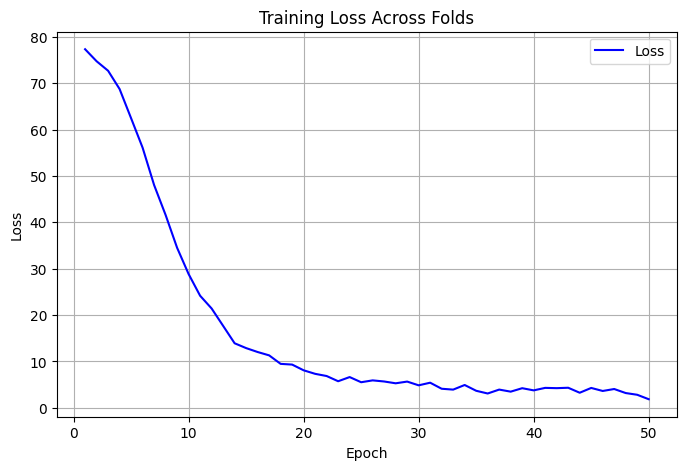

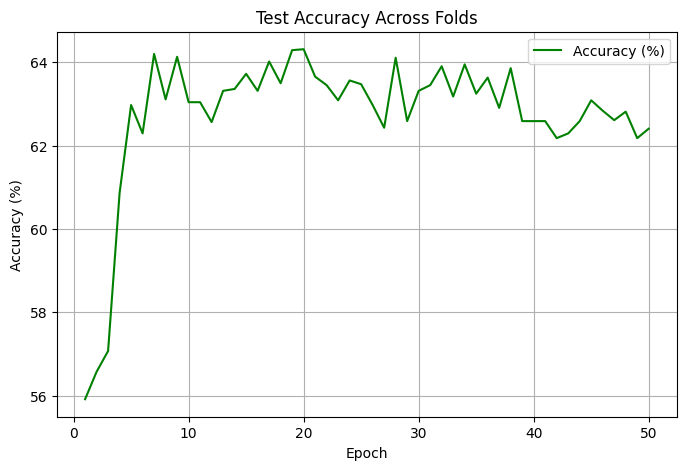

In [ ]:
WAVELET_TYPE = 'db4'
print(WAVELET_TYPE)
train_5fold_cross_validation(SpatialTransformer, learning_rate=1e-4, feature_method='wavelet_packet', subject_data= subject_data_preload)

db4
Precomputing wavelet_packet features for all subjects...
[DEBUG] S001: X_feat shape = (42, 64, 8, 75)
[DEBUG] S002: X_feat shape = (42, 64, 8, 75)
[DEBUG] S003: X_feat shape = (42, 64, 8, 75)
[DEBUG] S004: X_feat shape = (42, 64, 8, 75)
[DEBUG] S005: X_feat shape = (42, 64, 8, 75)
[DEBUG] S006: X_feat shape = (42, 64, 8, 75)
[DEBUG] S007: X_feat shape = (42, 64, 8, 75)
[DEBUG] S008: X_feat shape = (42, 64, 8, 75)
[DEBUG] S009: X_feat shape = (42, 64, 8, 75)
[DEBUG] S010: X_feat shape = (42, 64, 8, 75)
[DEBUG] S011: X_feat shape = (42, 64, 8, 75)
[DEBUG] S012: X_feat shape = (42, 64, 8, 75)
[DEBUG] S013: X_feat shape = (42, 64, 8, 75)
[DEBUG] S014: X_feat shape = (42, 64, 8, 75)
[DEBUG] S015: X_feat shape = (42, 64, 8, 75)
[DEBUG] S016: X_feat shape = (42, 64, 8, 75)
[DEBUG] S017: X_feat shape = (42, 64, 8, 75)
[DEBUG] S018: X_feat shape = (42, 64, 8, 75)
[DEBUG] S019: X_feat shape = (42, 64, 8, 75)
[DEBUG] S020: X_feat shape = (42, 64, 8, 75)
[DEBUG] S021: X_feat shape = (42, 64, 8

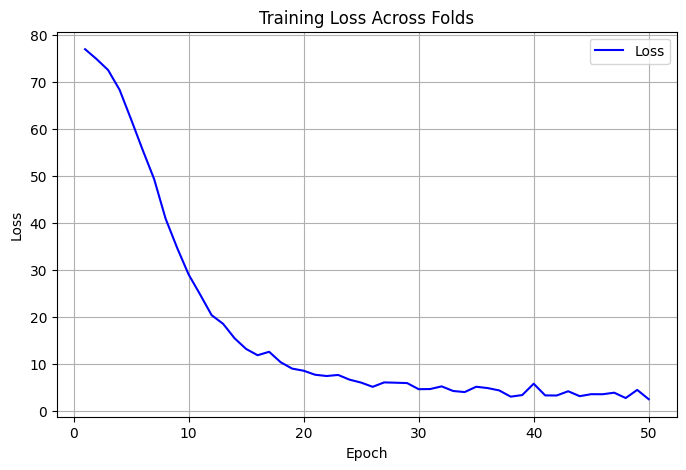

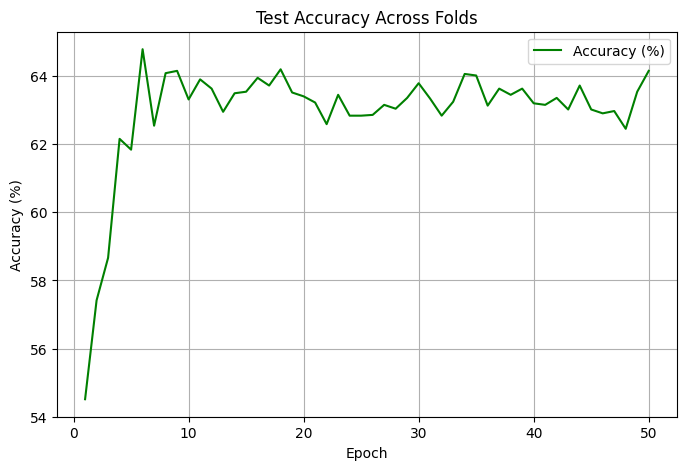

In [ ]:
WAVELET_TYPE = 'db4'
print(WAVELET_TYPE)
train_5fold_cross_validation(SpatialTransformer, learning_rate=1e-3, feature_method='wavelet_packet', subject_data= subject_data_preload)

coif3
Precomputing wavelet_packet features for all subjects...
[DEBUG] S001: X_feat shape = (42, 64, 8, 75)
[DEBUG] S002: X_feat shape = (42, 64, 8, 75)
[DEBUG] S003: X_feat shape = (42, 64, 8, 75)
[DEBUG] S004: X_feat shape = (42, 64, 8, 75)
[DEBUG] S005: X_feat shape = (42, 64, 8, 75)
[DEBUG] S006: X_feat shape = (42, 64, 8, 75)
[DEBUG] S007: X_feat shape = (42, 64, 8, 75)
[DEBUG] S008: X_feat shape = (42, 64, 8, 75)
[DEBUG] S009: X_feat shape = (42, 64, 8, 75)
[DEBUG] S010: X_feat shape = (42, 64, 8, 75)
[DEBUG] S011: X_feat shape = (42, 64, 8, 75)
[DEBUG] S012: X_feat shape = (42, 64, 8, 75)
[DEBUG] S013: X_feat shape = (42, 64, 8, 75)
[DEBUG] S014: X_feat shape = (42, 64, 8, 75)
[DEBUG] S015: X_feat shape = (42, 64, 8, 75)
[DEBUG] S016: X_feat shape = (42, 64, 8, 75)
[DEBUG] S017: X_feat shape = (42, 64, 8, 75)
[DEBUG] S018: X_feat shape = (42, 64, 8, 75)
[DEBUG] S019: X_feat shape = (42, 64, 8, 75)
[DEBUG] S020: X_feat shape = (42, 64, 8, 75)
[DEBUG] S021: X_feat shape = (42, 64,

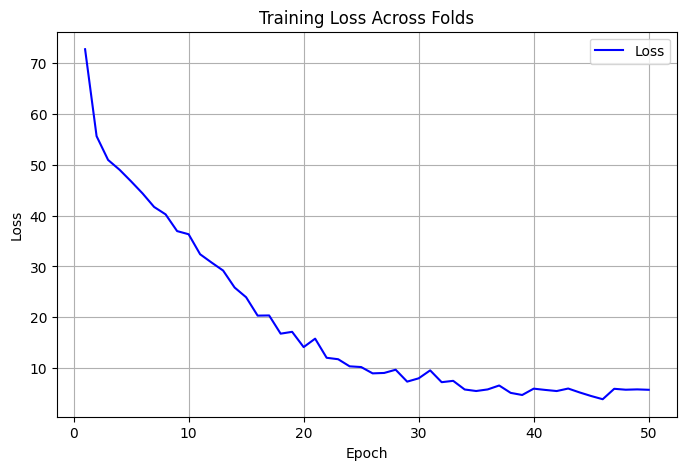

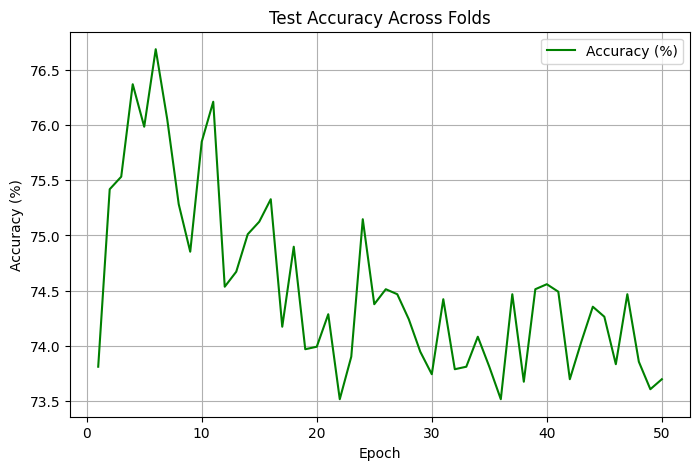

In [ ]:
WAVELET_TYPE = 'coif3'
print(WAVELET_TYPE)
train_5fold_cross_validation(TemporalTransformer, learning_rate=1e-4, feature_method='wavelet_packet', subject_data= subject_data_preload)

coif3
Precomputing wavelet_packet features for all subjects...
[DEBUG] S001: X_feat shape = (42, 64, 8, 75)
[DEBUG] S002: X_feat shape = (42, 64, 8, 75)
[DEBUG] S003: X_feat shape = (42, 64, 8, 75)
[DEBUG] S004: X_feat shape = (42, 64, 8, 75)
[DEBUG] S005: X_feat shape = (42, 64, 8, 75)
[DEBUG] S006: X_feat shape = (42, 64, 8, 75)
[DEBUG] S007: X_feat shape = (42, 64, 8, 75)
[DEBUG] S008: X_feat shape = (42, 64, 8, 75)
[DEBUG] S009: X_feat shape = (42, 64, 8, 75)
[DEBUG] S010: X_feat shape = (42, 64, 8, 75)
[DEBUG] S011: X_feat shape = (42, 64, 8, 75)
[DEBUG] S012: X_feat shape = (42, 64, 8, 75)
[DEBUG] S013: X_feat shape = (42, 64, 8, 75)
[DEBUG] S014: X_feat shape = (42, 64, 8, 75)
[DEBUG] S015: X_feat shape = (42, 64, 8, 75)
[DEBUG] S016: X_feat shape = (42, 64, 8, 75)
[DEBUG] S017: X_feat shape = (42, 64, 8, 75)
[DEBUG] S018: X_feat shape = (42, 64, 8, 75)
[DEBUG] S019: X_feat shape = (42, 64, 8, 75)
[DEBUG] S020: X_feat shape = (42, 64, 8, 75)
[DEBUG] S021: X_feat shape = (42, 64,

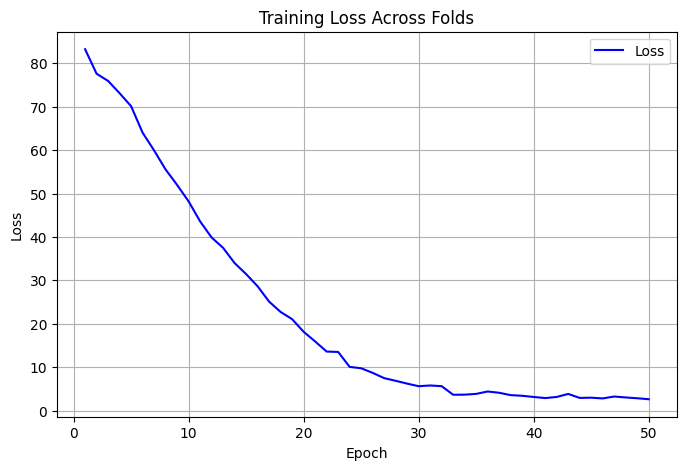

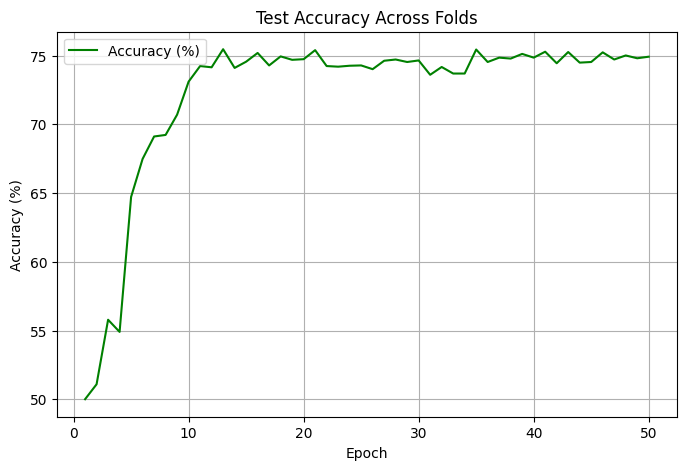

In [ ]:
WAVELET_TYPE = 'coif3'
print(WAVELET_TYPE)
train_5fold_cross_validation(TemporalCNNTransformer, learning_rate=1e-4, feature_method='wavelet_packet', subject_data= subject_data_preload)

coif3
Precomputing wavelet_packet features for all subjects...
[DEBUG] S001: X_feat shape = (42, 64, 8, 75)
[DEBUG] S002: X_feat shape = (42, 64, 8, 75)
[DEBUG] S003: X_feat shape = (42, 64, 8, 75)
[DEBUG] S004: X_feat shape = (42, 64, 8, 75)
[DEBUG] S005: X_feat shape = (42, 64, 8, 75)
[DEBUG] S006: X_feat shape = (42, 64, 8, 75)
[DEBUG] S007: X_feat shape = (42, 64, 8, 75)
[DEBUG] S008: X_feat shape = (42, 64, 8, 75)
[DEBUG] S009: X_feat shape = (42, 64, 8, 75)
[DEBUG] S010: X_feat shape = (42, 64, 8, 75)
[DEBUG] S011: X_feat shape = (42, 64, 8, 75)
[DEBUG] S012: X_feat shape = (42, 64, 8, 75)
[DEBUG] S013: X_feat shape = (42, 64, 8, 75)
[DEBUG] S014: X_feat shape = (42, 64, 8, 75)
[DEBUG] S015: X_feat shape = (42, 64, 8, 75)
[DEBUG] S016: X_feat shape = (42, 64, 8, 75)
[DEBUG] S017: X_feat shape = (42, 64, 8, 75)
[DEBUG] S018: X_feat shape = (42, 64, 8, 75)
[DEBUG] S019: X_feat shape = (42, 64, 8, 75)
[DEBUG] S020: X_feat shape = (42, 64, 8, 75)
[DEBUG] S021: X_feat shape = (42, 64,

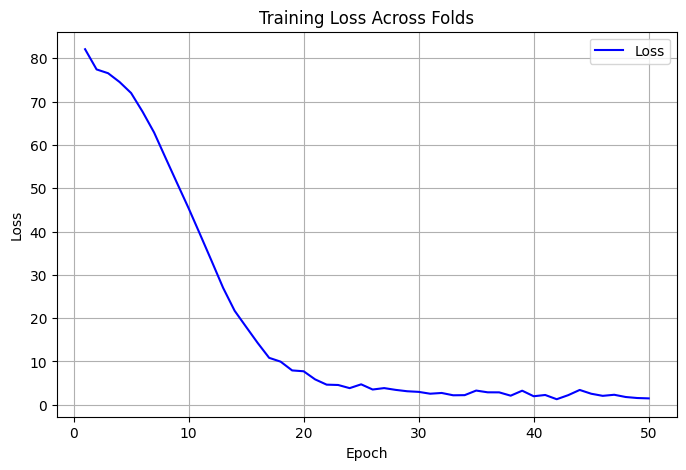

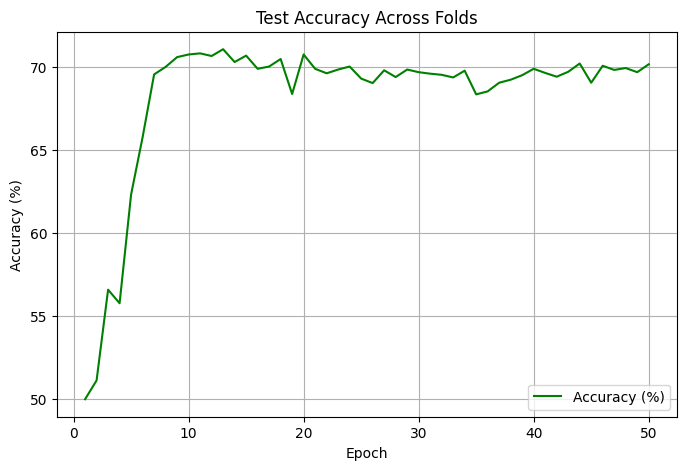

In [ ]:
WAVELET_TYPE = 'coif3'
print(WAVELET_TYPE)
train_5fold_cross_validation(SpatialCNNTransformer, learning_rate=1e-4, feature_method='wavelet_packet', subject_data= subject_data_preload)

db4
Precomputing wavelet_packet features for all subjects...
[DEBUG] S001: X_feat shape = (42, 64, 8, 75)
[DEBUG] S002: X_feat shape = (42, 64, 8, 75)
[DEBUG] S003: X_feat shape = (42, 64, 8, 75)
[DEBUG] S004: X_feat shape = (42, 64, 8, 75)
[DEBUG] S005: X_feat shape = (42, 64, 8, 75)
[DEBUG] S006: X_feat shape = (42, 64, 8, 75)
[DEBUG] S007: X_feat shape = (42, 64, 8, 75)
[DEBUG] S008: X_feat shape = (42, 64, 8, 75)
[DEBUG] S009: X_feat shape = (42, 64, 8, 75)
[DEBUG] S010: X_feat shape = (42, 64, 8, 75)
[DEBUG] S011: X_feat shape = (42, 64, 8, 75)
[DEBUG] S012: X_feat shape = (42, 64, 8, 75)
[DEBUG] S013: X_feat shape = (42, 64, 8, 75)
[DEBUG] S014: X_feat shape = (42, 64, 8, 75)
[DEBUG] S015: X_feat shape = (42, 64, 8, 75)
[DEBUG] S016: X_feat shape = (42, 64, 8, 75)
[DEBUG] S017: X_feat shape = (42, 64, 8, 75)
[DEBUG] S018: X_feat shape = (42, 64, 8, 75)
[DEBUG] S019: X_feat shape = (42, 64, 8, 75)
[DEBUG] S020: X_feat shape = (42, 64, 8, 75)
[DEBUG] S021: X_feat shape = (42, 64, 8

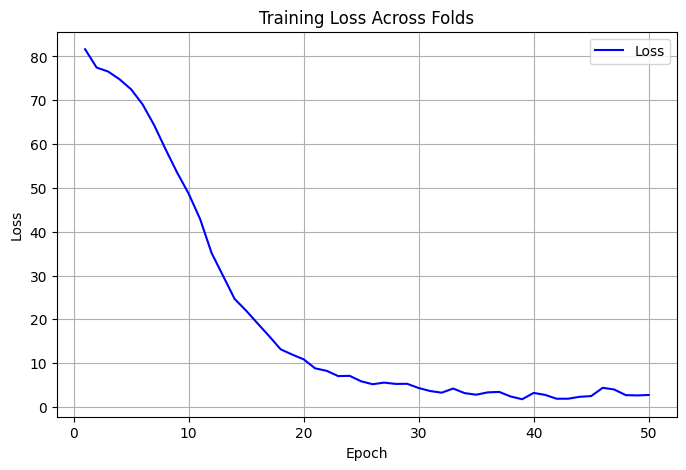

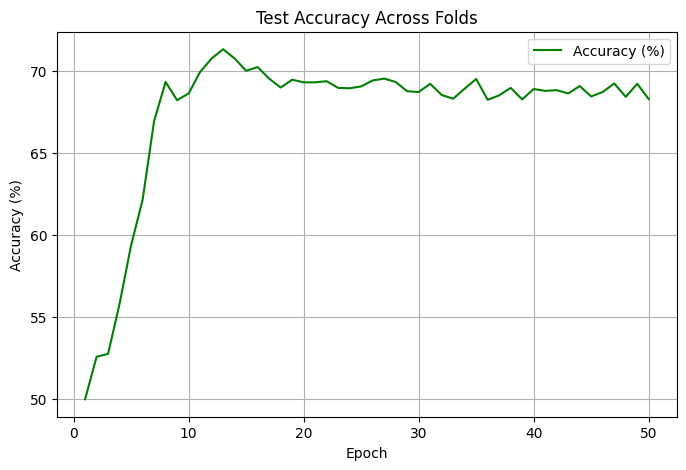

In [ ]:
WAVELET_TYPE = 'db4' # OKONCZ TUTAJ
print(WAVELET_TYPE)
train_5fold_cross_validation(SpatialCNNTransformer, learning_rate=1e-3, feature_method='wavelet_packet', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 481)
Epoch 1/50, Loss: 77.0841, Test Acc: 0.5454
Epoch 2/50, Loss: 72.1280, Test Acc: 0.5930
Epoch 3/50, Loss: 69.0076, Test Acc: 0.6032
Epoch 4/50, Loss: 66.8310, Test Acc: 0.5975
Epoch 5/50, Loss: 64.5331, Test Acc: 0.6179
Epoch 6/50, Loss: 64.6725, Test Acc: 0.6122
Epoch 7/50, Loss: 63.1361, Test Acc: 0.6236
Epoch 8/50, Loss: 62.6855, Test Acc: 0.6156
Epoch 9/50, Loss: 63.2812, Test Acc: 0.6304
Epoch 10/50, Loss: 60.8795, Test Acc: 0.6361
Epoch 11/50, Loss: 60.7848, Test Acc: 0.6202
Epoch 12/50, Loss: 59.5951, Test Acc: 0.6610
Epoch 13/50, Loss: 57.8215, Test Acc: 0.6485
Epoch 14/50, Loss: 56.5623, Test Acc: 0.6451
Epoch 15/50, Loss: 55.4997, Test Acc: 0.6463
Epoch 16/50, Loss: 56.0715, Test Acc: 0.6553
Epoch 17/50, Loss: 52.2204, Test Acc: 0.6746
Epoch 18/50, Loss: 52.9056, Test Acc: 0.6633
Epoch 19/50, Loss: 49.3291, Test Acc: 0.6599
Epoch 20/50, Loss: 47.4243, Test Acc: 0.6916
Epoch 21/50, Loss: 46.4386, Test Acc: 0.6757
Epoch 22/50, L

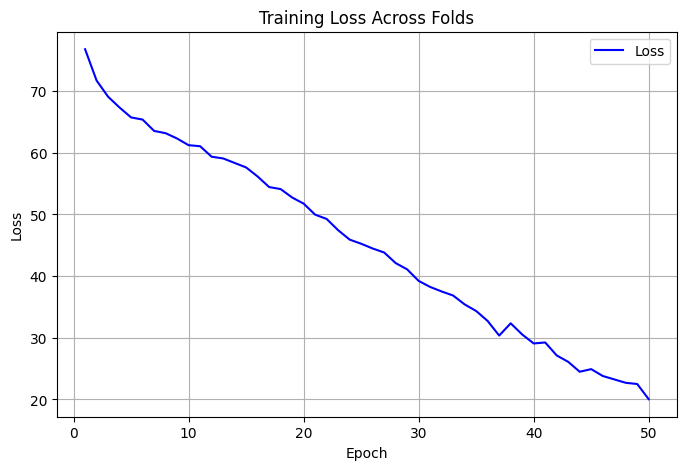

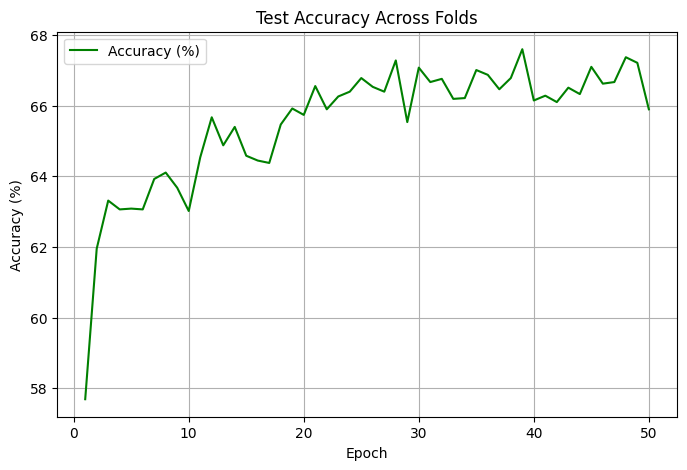

In [ ]:
train_5fold_cross_validation(TemporalTransformer, learning_rate=7e-4, feature_method='stft', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 481)
Epoch 1/50, Loss: 82.0574, Test Acc: 0.5000
Epoch 2/50, Loss: 77.5147, Test Acc: 0.5000
Epoch 3/50, Loss: 77.7261, Test Acc: 0.5000
Epoch 4/50, Loss: 77.4423, Test Acc: 0.5000
Epoch 5/50, Loss: 77.2104, Test Acc: 0.5000
Epoch 6/50, Loss: 77.3246, Test Acc: 0.5000
Epoch 7/50, Loss: 77.1928, Test Acc: 0.5000
Epoch 8/50, Loss: 77.5213, Test Acc: 0.5000
Epoch 9/50, Loss: 77.1389, Test Acc: 0.5000
Epoch 10/50, Loss: 77.2015, Test Acc: 0.5000
Epoch 11/50, Loss: 77.2364, Test Acc: 0.5000
Epoch 12/50, Loss: 77.0980, Test Acc: 0.5000
Epoch 13/50, Loss: 77.2860, Test Acc: 0.5000
Epoch 14/50, Loss: 77.1150, Test Acc: 0.5000
Epoch 15/50, Loss: 77.0231, Test Acc: 0.5000
Epoch 16/50, Loss: 77.0725, Test Acc: 0.5000
Epoch 17/50, Loss: 76.9830, Test Acc: 0.5000
Epoch 18/50, Loss: 77.1356, Test Acc: 0.5000
Epoch 19/50, Loss: 77.0457, Test Acc: 0.5000
Epoch 20/50, Loss: 77.0128, Test Acc: 0.5000
Epoch 21/50, Loss: 77.0891, Test Acc: 0.5000
Epoch 22/50, L

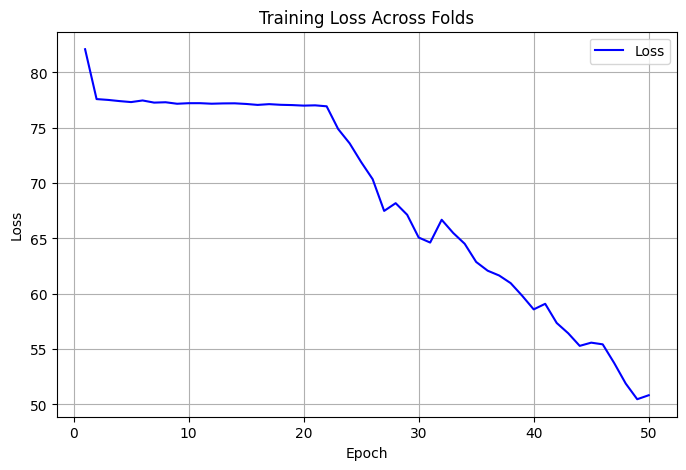

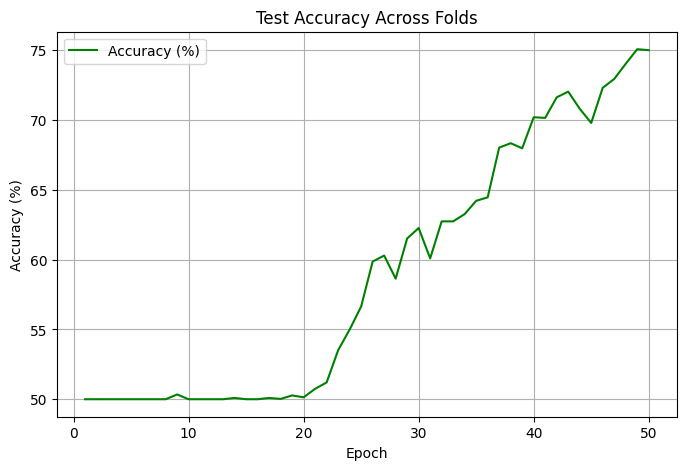

In [ ]:
train_5fold_cross_validation(TemporalCNNTransformer, learning_rate=1e-4, feature_method='stft', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 481)
Epoch 1/50, Loss: 78.4765, Test Acc: 0.5567
Epoch 2/50, Loss: 76.8907, Test Acc: 0.5408
Epoch 3/50, Loss: 75.8555, Test Acc: 0.5488
Epoch 4/50, Loss: 75.6300, Test Acc: 0.5590
Epoch 5/50, Loss: 73.6776, Test Acc: 0.5782
Epoch 6/50, Loss: 70.3730, Test Acc: 0.6168
Epoch 7/50, Loss: 66.1210, Test Acc: 0.6213
Epoch 8/50, Loss: 63.1090, Test Acc: 0.6293
Epoch 9/50, Loss: 58.1092, Test Acc: 0.6429
Epoch 10/50, Loss: 55.1274, Test Acc: 0.6406
Epoch 11/50, Loss: 52.9568, Test Acc: 0.6429
Epoch 12/50, Loss: 49.8896, Test Acc: 0.6338
Epoch 13/50, Loss: 46.2400, Test Acc: 0.6429
Epoch 14/50, Loss: 43.3474, Test Acc: 0.5964
Epoch 15/50, Loss: 40.3765, Test Acc: 0.6406
Epoch 16/50, Loss: 37.1939, Test Acc: 0.6451
Epoch 17/50, Loss: 35.1990, Test Acc: 0.6508
Epoch 18/50, Loss: 30.6783, Test Acc: 0.6417
Epoch 19/50, Loss: 27.2902, Test Acc: 0.6281
Epoch 20/50, Loss: 24.7948, Test Acc: 0.6361
Epoch 21/50, Loss: 23.4060, Test Acc: 0.6236
Epoch 22/50, L

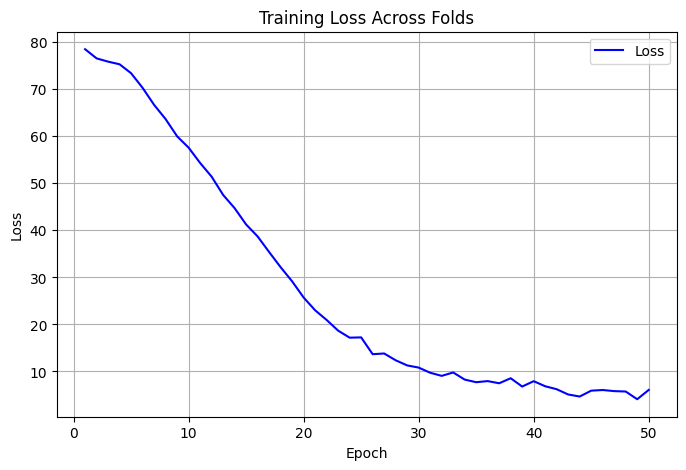

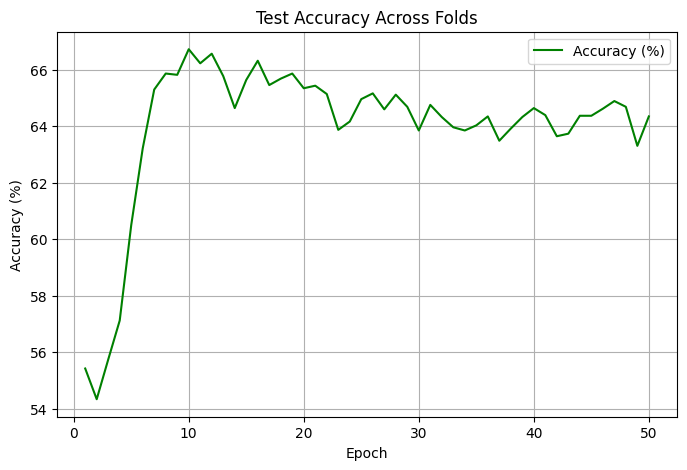

In [ ]:
train_5fold_cross_validation(SpatialTransformer, learning_rate=7e-4, feature_method='stft', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 481)
Epoch 1/50, Loss: 82.7366, Test Acc: 0.5000
Epoch 2/50, Loss: 77.4085, Test Acc: 0.5000
Epoch 3/50, Loss: 77.4657, Test Acc: 0.5000
Epoch 4/50, Loss: 77.6978, Test Acc: 0.5204
Epoch 5/50, Loss: 77.1807, Test Acc: 0.5023
Epoch 6/50, Loss: 77.8174, Test Acc: 0.5000
Epoch 7/50, Loss: 76.9615, Test Acc: 0.5000
Epoch 8/50, Loss: 77.2375, Test Acc: 0.5057
Epoch 9/50, Loss: 77.3020, Test Acc: 0.5079
Epoch 10/50, Loss: 75.8268, Test Acc: 0.6542
Epoch 11/50, Loss: 68.0203, Test Acc: 0.6633
Epoch 12/50, Loss: 66.2748, Test Acc: 0.6893
Epoch 13/50, Loss: 59.9742, Test Acc: 0.6984
Epoch 14/50, Loss: 59.7933, Test Acc: 0.6780
Epoch 15/50, Loss: 58.9965, Test Acc: 0.7052
Epoch 16/50, Loss: 56.5791, Test Acc: 0.6950
Epoch 17/50, Loss: 55.9816, Test Acc: 0.7234
Epoch 18/50, Loss: 54.4035, Test Acc: 0.7245
Epoch 19/50, Loss: 52.8130, Test Acc: 0.7029
Epoch 20/50, Loss: 51.7621, Test Acc: 0.7336
Epoch 21/50, Loss: 51.7401, Test Acc: 0.7370
Epoch 22/50, L

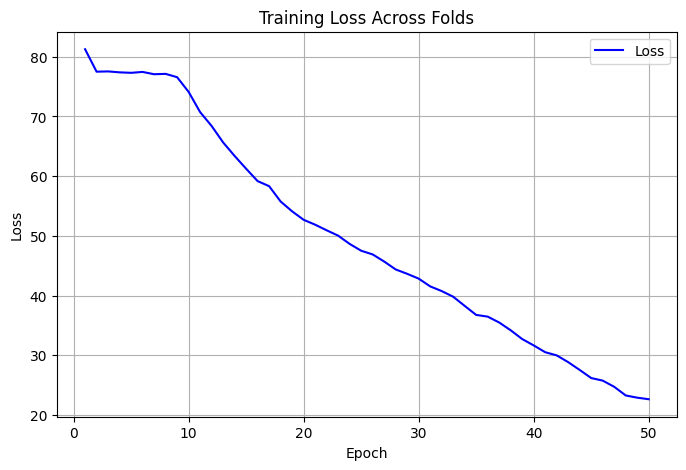

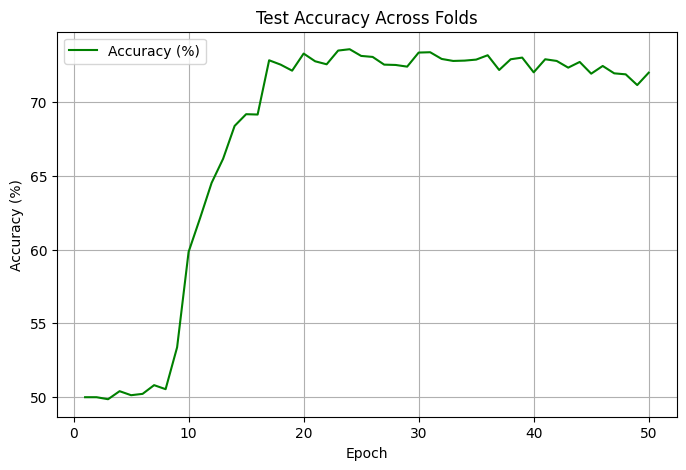

In [ ]:
train_5fold_cross_validation(FusionCNNTransformer, learning_rate=7e-4, feature_method='stft', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 481)
Epoch 1/50, Loss: 77.7464, Test Acc: 0.5000
Epoch 2/50, Loss: 77.3236, Test Acc: 0.5000
Epoch 3/50, Loss: 77.1057, Test Acc: 0.5000
Epoch 4/50, Loss: 77.2381, Test Acc: 0.5000
Epoch 5/50, Loss: 77.0405, Test Acc: 0.5000
Epoch 6/50, Loss: 77.0134, Test Acc: 0.5000
Epoch 7/50, Loss: 77.0062, Test Acc: 0.5000
Epoch 8/50, Loss: 77.0697, Test Acc: 0.5000
Epoch 9/50, Loss: 76.9858, Test Acc: 0.5000
Epoch 10/50, Loss: 77.0389, Test Acc: 0.5000
Epoch 11/50, Loss: 76.9686, Test Acc: 0.5000
Epoch 12/50, Loss: 76.8895, Test Acc: 0.5465
Epoch 13/50, Loss: 69.2908, Test Acc: 0.6723
Epoch 14/50, Loss: 68.7363, Test Acc: 0.6916
Epoch 15/50, Loss: 65.7689, Test Acc: 0.7256
Epoch 16/50, Loss: 60.5613, Test Acc: 0.7188
Epoch 17/50, Loss: 57.2225, Test Acc: 0.7279
Epoch 18/50, Loss: 57.1890, Test Acc: 0.7313
Epoch 19/50, Loss: 60.0833, Test Acc: 0.6621
Epoch 20/50, Loss: 60.9953, Test Acc: 0.6757
Epoch 21/50, Loss: 56.0386, Test Acc: 0.7336
Epoch 22/50, L

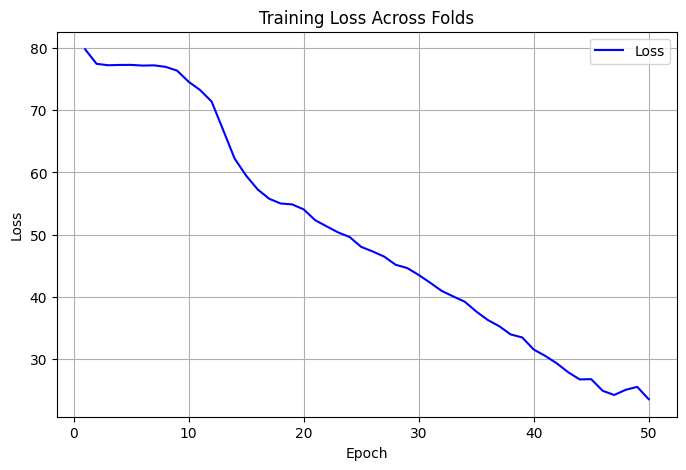

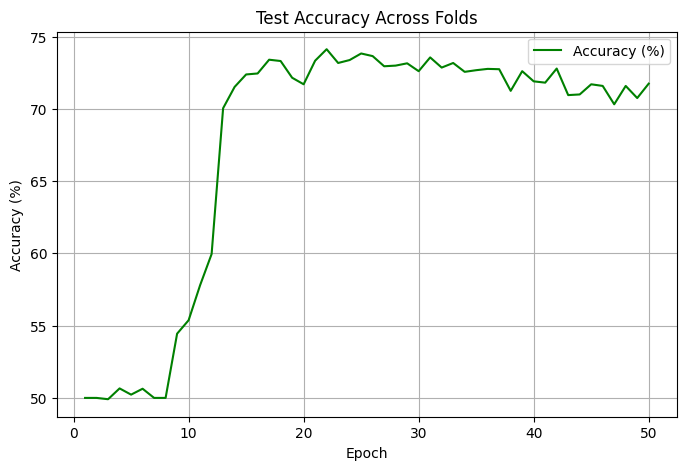

In [ ]:
train_5fold_cross_validation(FusionCNNTransformer, learning_rate=1e-4, feature_method='stft', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 481)
Epoch 1/50, Loss: 81.0204, Test Acc: 0.5000
Epoch 2/50, Loss: 77.5998, Test Acc: 0.5000
Epoch 3/50, Loss: 77.4875, Test Acc: 0.5000
Epoch 4/50, Loss: 77.3038, Test Acc: 0.5000
Epoch 5/50, Loss: 77.4487, Test Acc: 0.5000
Epoch 6/50, Loss: 77.4236, Test Acc: 0.5068
Epoch 7/50, Loss: 77.4270, Test Acc: 0.5000
Epoch 8/50, Loss: 77.2639, Test Acc: 0.5000
Epoch 9/50, Loss: 77.2145, Test Acc: 0.5000
Epoch 10/50, Loss: 77.0659, Test Acc: 0.5261
Epoch 11/50, Loss: 77.0039, Test Acc: 0.5181
Epoch 12/50, Loss: 77.0327, Test Acc: 0.5091
Epoch 13/50, Loss: 75.7271, Test Acc: 0.5918
Epoch 14/50, Loss: 73.7405, Test Acc: 0.5408
Epoch 15/50, Loss: 74.0286, Test Acc: 0.6304
Epoch 16/50, Loss: 63.6918, Test Acc: 0.7052
Epoch 17/50, Loss: 59.4933, Test Acc: 0.7075
Epoch 18/50, Loss: 56.6048, Test Acc: 0.7041
Epoch 19/50, Loss: 54.8379, Test Acc: 0.7177
Epoch 20/50, Loss: 54.0100, Test Acc: 0.7256
Epoch 21/50, Loss: 52.9479, Test Acc: 0.7370
Epoch 22/50, L

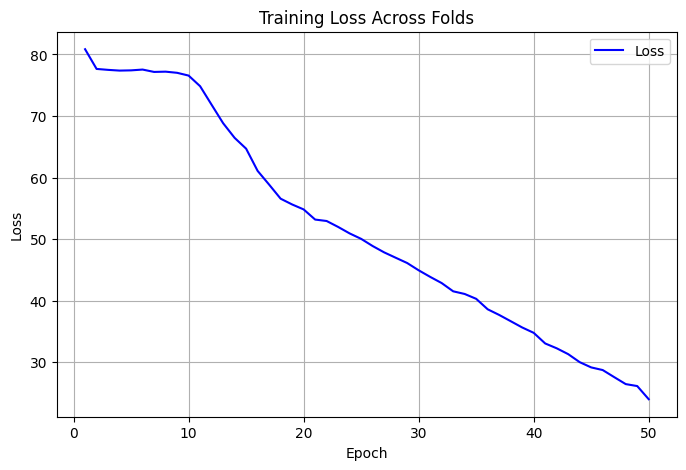

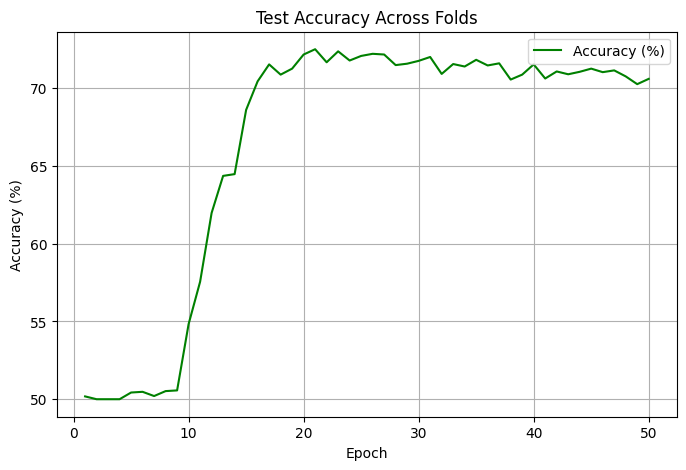

In [ ]:
train_5fold_cross_validation(SpatialCNNTransformer, learning_rate=7e-4, feature_method='stft', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 481)
Epoch 1/50, Loss: 80.6907, Test Acc: 0.5000
Epoch 2/50, Loss: 77.7455, Test Acc: 0.5000
Epoch 3/50, Loss: 77.7962, Test Acc: 0.5000
Epoch 4/50, Loss: 77.4980, Test Acc: 0.5374
Epoch 5/50, Loss: 78.0119, Test Acc: 0.5000
Epoch 6/50, Loss: 77.2673, Test Acc: 0.5000
Epoch 7/50, Loss: 77.3787, Test Acc: 0.5023
Epoch 8/50, Loss: 77.1603, Test Acc: 0.5306
Epoch 9/50, Loss: 76.9272, Test Acc: 0.5374
Epoch 10/50, Loss: 76.4687, Test Acc: 0.5714
Epoch 11/50, Loss: 74.4799, Test Acc: 0.6111
Epoch 12/50, Loss: 70.9396, Test Acc: 0.6519
Epoch 13/50, Loss: 63.8297, Test Acc: 0.6735
Epoch 14/50, Loss: 60.6672, Test Acc: 0.6927
Epoch 15/50, Loss: 59.0025, Test Acc: 0.7075
Epoch 16/50, Loss: 56.5321, Test Acc: 0.7109
Epoch 17/50, Loss: 56.0860, Test Acc: 0.7063
Epoch 18/50, Loss: 55.5511, Test Acc: 0.7109
Epoch 19/50, Loss: 53.8443, Test Acc: 0.7166
Epoch 20/50, Loss: 53.1843, Test Acc: 0.7052
Epoch 21/50, Loss: 51.6348, Test Acc: 0.7177
Epoch 22/50, L

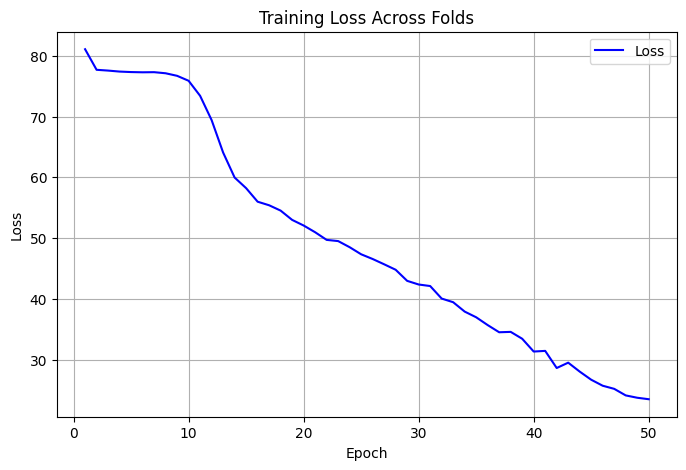

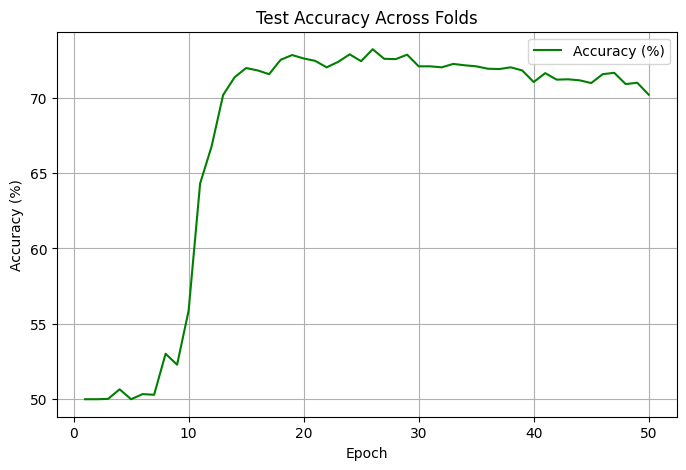

In [ ]:
train_5fold_cross_validation(SpatialCNNTransformer, learning_rate=1e-4, feature_method='stft', subject_data= subject_data_preload)


Fold 1/5
Fitting CSP incrementally on per-subject data (memory safe)...
Epoch 1/50, Loss: 71.6519, Test Acc: 0.6735
Epoch 2/50, Loss: 64.3547, Test Acc: 0.6701
Epoch 3/50, Loss: 61.8790, Test Acc: 0.6655
Epoch 4/50, Loss: 60.0086, Test Acc: 0.6848
Epoch 5/50, Loss: 58.8614, Test Acc: 0.6712
Epoch 6/50, Loss: 55.2486, Test Acc: 0.6723
Epoch 7/50, Loss: 53.4295, Test Acc: 0.6757
Epoch 8/50, Loss: 48.9863, Test Acc: 0.6780
Epoch 9/50, Loss: 44.6618, Test Acc: 0.6508
Epoch 10/50, Loss: 40.9245, Test Acc: 0.6621
Epoch 11/50, Loss: 36.6906, Test Acc: 0.6429
Epoch 12/50, Loss: 32.1323, Test Acc: 0.6304
Epoch 13/50, Loss: 29.0735, Test Acc: 0.6349
Epoch 14/50, Loss: 26.3413, Test Acc: 0.6190
Epoch 15/50, Loss: 24.8345, Test Acc: 0.6304
Epoch 16/50, Loss: 19.0331, Test Acc: 0.6406
Epoch 17/50, Loss: 18.1786, Test Acc: 0.6190
Epoch 18/50, Loss: 17.1378, Test Acc: 0.6474
Epoch 19/50, Loss: 17.7512, Test Acc: 0.6338
Epoch 20/50, Loss: 14.7687, Test Acc: 0.6236
Epoch 21/50, Loss: 13.8338, Test Acc

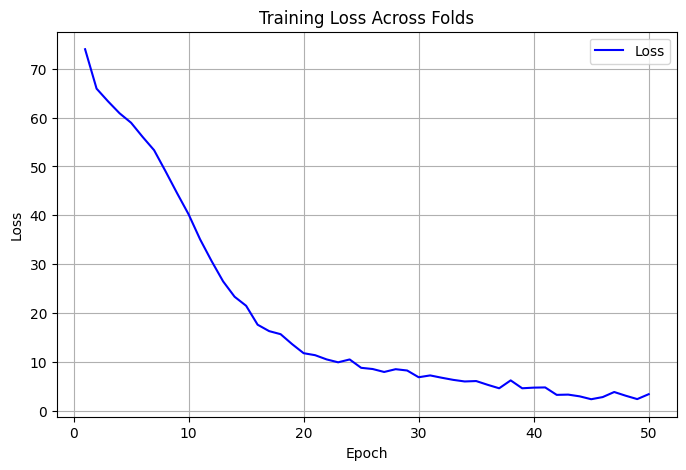

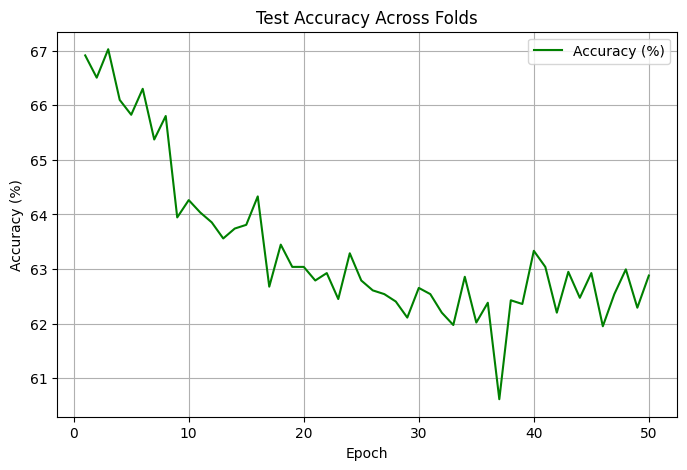

In [ ]:
NUM_COMP = 4
PATCH_SIZE = 32
train_5fold_cross_validation(FusionCNNTransformer, learning_rate=1e-4, feature_method='csp', subject_data= subject_data_preload)

In [ ]:
NUM_COMP = 6
PATCH_SIZE = 16
train_5fold_cross_validation(FusionCNNTransformer, learning_rate=7e-3, feature_method='csp', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 481)
Epoch 1/50, Loss: 79.8325, Test Acc: 0.5442
Epoch 2/50, Loss: 76.3271, Test Acc: 0.5374
Epoch 3/50, Loss: 76.4589, Test Acc: 0.4977
Epoch 4/50, Loss: 75.7677, Test Acc: 0.5726
Epoch 5/50, Loss: 74.0867, Test Acc: 0.6043
Epoch 6/50, Loss: 68.5922, Test Acc: 0.6293
Epoch 7/50, Loss: 64.8706, Test Acc: 0.6259
Epoch 8/50, Loss: 61.4653, Test Acc: 0.6440
Epoch 9/50, Loss: 59.1815, Test Acc: 0.6723
Epoch 10/50, Loss: 55.4358, Test Acc: 0.6712
Epoch 11/50, Loss: 54.1179, Test Acc: 0.6474
Epoch 12/50, Loss: 50.5432, Test Acc: 0.6667
Epoch 13/50, Loss: 47.2478, Test Acc: 0.6644
Epoch 14/50, Loss: 44.2372, Test Acc: 0.6825
Epoch 15/50, Loss: 39.8663, Test Acc: 0.6485
Epoch 16/50, Loss: 37.5487, Test Acc: 0.6440
Epoch 17/50, Loss: 33.1267, Test Acc: 0.6451
Epoch 18/50, Loss: 28.0753, Test Acc: 0.6440
Epoch 19/50, Loss: 26.6239, Test Acc: 0.6440
Epoch 20/50, Loss: 23.8694, Test Acc: 0.6565
Epoch 21/50, Loss: 22.0608, Test Acc: 0.6610
Epoch 22/50, L

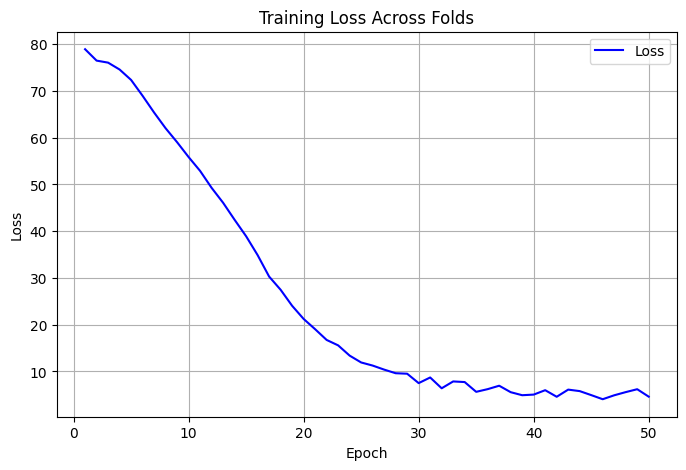

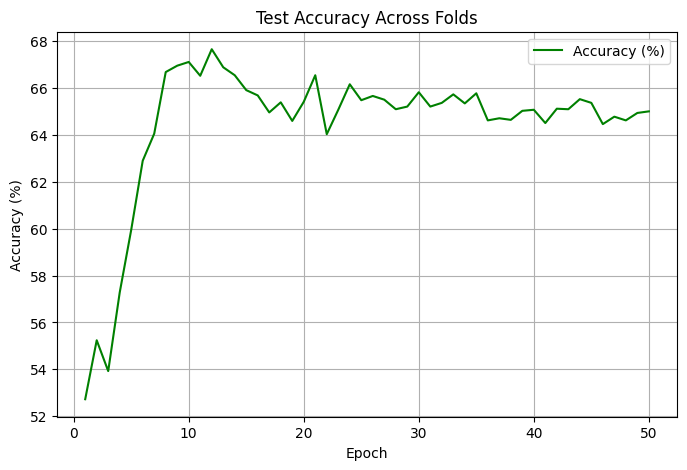

In [ ]:
train_5fold_cross_validation(SpatialTransformer, learning_rate=1e-4, feature_method='stft', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 961)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1027.)
  return F.conv2d(


Epoch 1/50, Loss: 80.4879, Test Acc: 0.5000
Epoch 2/50, Loss: 77.4220, Test Acc: 0.5023
Epoch 3/50, Loss: 75.6166, Test Acc: 0.5692
Epoch 4/50, Loss: 73.3628, Test Acc: 0.5794
Epoch 5/50, Loss: 71.7432, Test Acc: 0.6122
Epoch 6/50, Loss: 70.7519, Test Acc: 0.6327
Epoch 7/50, Loss: 71.8044, Test Acc: 0.6451
Epoch 8/50, Loss: 69.5744, Test Acc: 0.6349
Epoch 9/50, Loss: 67.9205, Test Acc: 0.6485
Epoch 10/50, Loss: 67.6068, Test Acc: 0.6383
Epoch 11/50, Loss: 64.3040, Test Acc: 0.5986
Epoch 12/50, Loss: 60.0692, Test Acc: 0.6905
Epoch 13/50, Loss: 54.8567, Test Acc: 0.6837
Epoch 14/50, Loss: 55.2960, Test Acc: 0.7143
Epoch 15/50, Loss: 49.1356, Test Acc: 0.7472
Epoch 16/50, Loss: 48.5735, Test Acc: 0.7914
Epoch 17/50, Loss: 44.4745, Test Acc: 0.7347
Epoch 18/50, Loss: 44.5283, Test Acc: 0.7857
Epoch 19/50, Loss: 42.1865, Test Acc: 0.7812
Epoch 20/50, Loss: 40.4137, Test Acc: 0.7857
Epoch 21/50, Loss: 40.3409, Test Acc: 0.7902
Epoch 22/50, Loss: 36.9149, Test Acc: 0.7959
Epoch 23/50, Loss: 

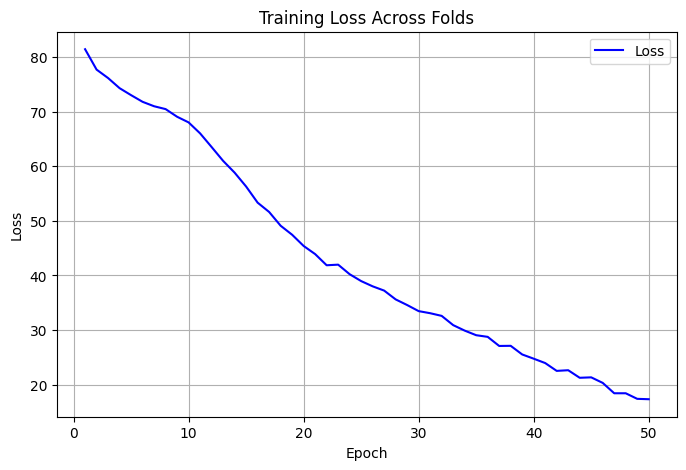

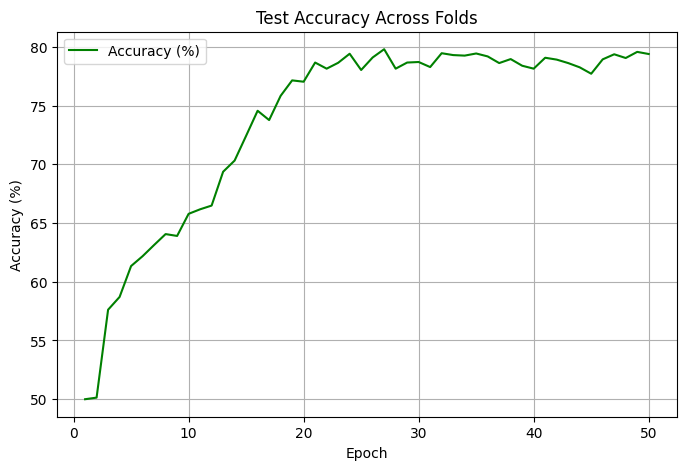

In [ ]:
train_5fold_cross_validation(TemporalCNNTransformer, learning_rate=1e-4, feature_method='raw', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 961)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1027.)
  return F.conv2d(


Epoch 1/50, Loss: 81.2371, Test Acc: 0.5000
Epoch 2/50, Loss: 78.2191, Test Acc: 0.5635
Epoch 3/50, Loss: 76.7336, Test Acc: 0.5136
Epoch 4/50, Loss: 71.7414, Test Acc: 0.6542
Epoch 5/50, Loss: 62.8126, Test Acc: 0.7302
Epoch 6/50, Loss: 57.3357, Test Acc: 0.7200
Epoch 7/50, Loss: 53.6005, Test Acc: 0.7098
Epoch 8/50, Loss: 52.3993, Test Acc: 0.7574
Epoch 9/50, Loss: 49.2179, Test Acc: 0.7358
Epoch 10/50, Loss: 47.3821, Test Acc: 0.7517
Epoch 11/50, Loss: 46.0482, Test Acc: 0.7585
Epoch 12/50, Loss: 44.6782, Test Acc: 0.7596
Epoch 13/50, Loss: 42.7222, Test Acc: 0.7868
Epoch 14/50, Loss: 41.6825, Test Acc: 0.7778
Epoch 15/50, Loss: 40.7051, Test Acc: 0.7857
Epoch 16/50, Loss: 40.5800, Test Acc: 0.7744
Epoch 17/50, Loss: 39.8524, Test Acc: 0.7744
Epoch 18/50, Loss: 39.4278, Test Acc: 0.7755
Epoch 19/50, Loss: 36.9863, Test Acc: 0.7789
Epoch 20/50, Loss: 36.3258, Test Acc: 0.8084
Epoch 21/50, Loss: 35.9692, Test Acc: 0.7834
Epoch 22/50, Loss: 34.7152, Test Acc: 0.7914
Epoch 23/50, Loss: 

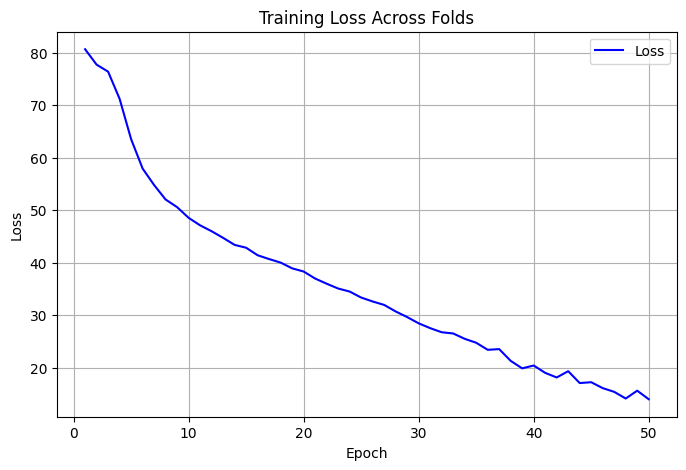

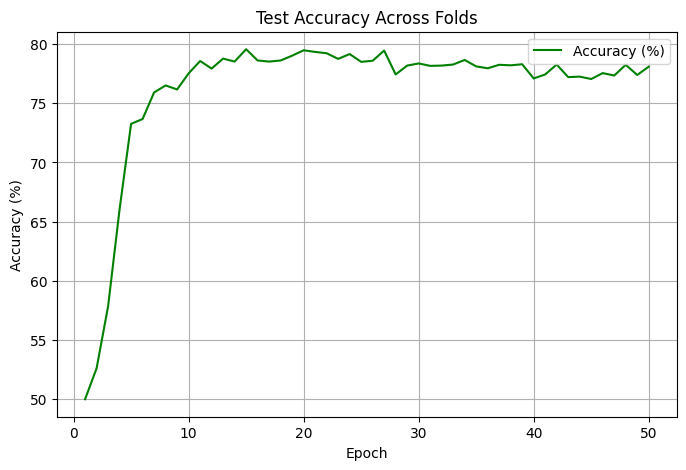

In [ ]:
train_5fold_cross_validation(SpatialCNNTransformer, learning_rate=1e-4, feature_method='raw', subject_data= subject_data_preload)

In [ ]:
#------------------------------------------------------------------------------------- 6s segment


Fold 1/5
[DEBUG] Input to model: (3528, 64, 961)
Epoch 1/50, Loss: 78.4514, Test Acc: 0.5748
Epoch 2/50, Loss: 75.9766, Test Acc: 0.5590
Epoch 3/50, Loss: 75.6990, Test Acc: 0.5737
Epoch 4/50, Loss: 74.4306, Test Acc: 0.5884
Epoch 5/50, Loss: 71.7551, Test Acc: 0.6145
Epoch 6/50, Loss: 66.3360, Test Acc: 0.6315
Epoch 7/50, Loss: 62.6535, Test Acc: 0.6395
Epoch 8/50, Loss: 59.2848, Test Acc: 0.6769
Epoch 9/50, Loss: 57.3110, Test Acc: 0.6576
Epoch 10/50, Loss: 54.3918, Test Acc: 0.6508
Epoch 11/50, Loss: 50.1468, Test Acc: 0.6667
Epoch 12/50, Loss: 49.0119, Test Acc: 0.6497
Epoch 13/50, Loss: 45.8404, Test Acc: 0.6349
Epoch 14/50, Loss: 43.3513, Test Acc: 0.6451
Epoch 15/50, Loss: 40.7749, Test Acc: 0.6689
Epoch 16/50, Loss: 37.6261, Test Acc: 0.6553
Epoch 17/50, Loss: 33.0978, Test Acc: 0.6667
Epoch 18/50, Loss: 29.9755, Test Acc: 0.6338
Epoch 19/50, Loss: 27.6750, Test Acc: 0.6508
Epoch 20/50, Loss: 27.0330, Test Acc: 0.6463
Epoch 21/50, Loss: 22.4179, Test Acc: 0.6474
Epoch 22/50, L

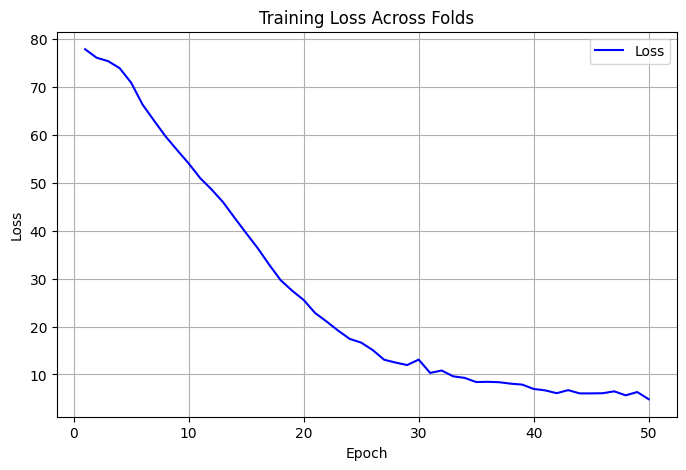

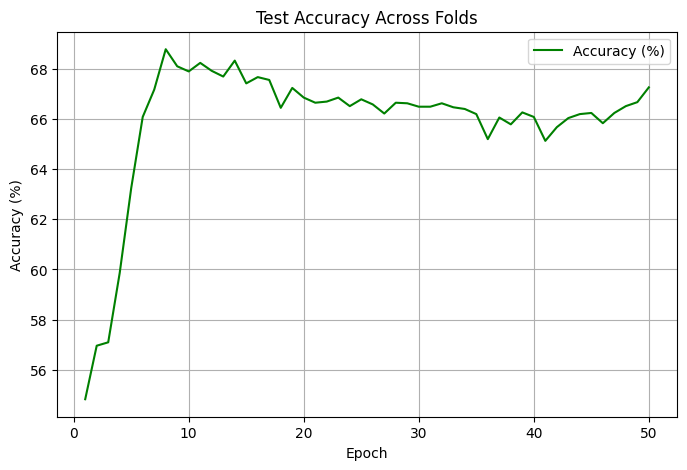

In [ ]:
train_5fold_cross_validation(SpatialTransformer, learning_rate=7e-4, feature_method='stft', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 961)
Epoch 1/50, Loss: 82.0833, Test Acc: 0.5000
Epoch 2/50, Loss: 78.0391, Test Acc: 0.5000
Epoch 3/50, Loss: 77.9406, Test Acc: 0.5000
Epoch 4/50, Loss: 77.4731, Test Acc: 0.5000
Epoch 5/50, Loss: 77.2105, Test Acc: 0.5000
Epoch 6/50, Loss: 77.1949, Test Acc: 0.5000
Epoch 7/50, Loss: 77.5265, Test Acc: 0.5000
Epoch 8/50, Loss: 77.5164, Test Acc: 0.5000
Epoch 9/50, Loss: 77.0687, Test Acc: 0.5000
Epoch 10/50, Loss: 77.0586, Test Acc: 0.5283
Epoch 11/50, Loss: 77.2240, Test Acc: 0.5000
Epoch 12/50, Loss: 77.1169, Test Acc: 0.5079
Epoch 13/50, Loss: 70.1556, Test Acc: 0.7404
Epoch 14/50, Loss: 47.0353, Test Acc: 0.7778
Epoch 15/50, Loss: 41.7138, Test Acc: 0.7834
Epoch 16/50, Loss: 37.1237, Test Acc: 0.8152
Epoch 17/50, Loss: 35.8617, Test Acc: 0.7914
Epoch 18/50, Loss: 34.2185, Test Acc: 0.8095
Epoch 19/50, Loss: 32.3465, Test Acc: 0.7959
Epoch 20/50, Loss: 30.1651, Test Acc: 0.8073
Epoch 21/50, Loss: 27.4239, Test Acc: 0.7880
Epoch 22/50, L

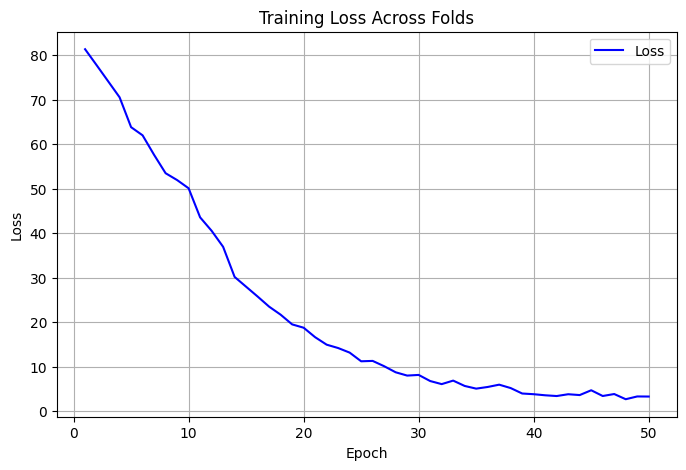

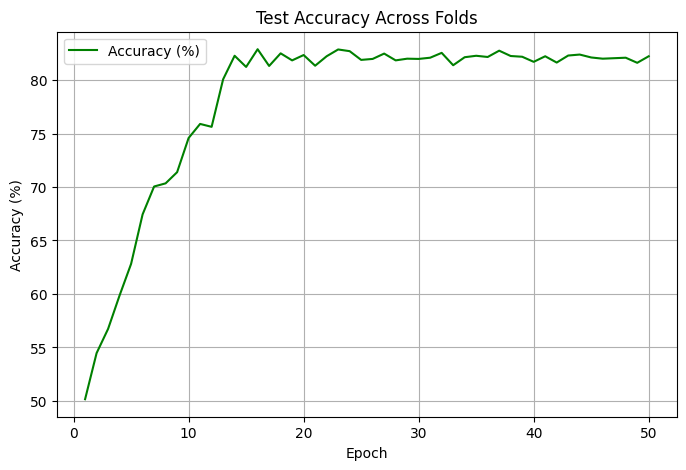

In [ ]:
train_5fold_cross_validation(TemporalCNNTransformer, learning_rate=1e-4, feature_method='stft', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 961)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1027.)
  return F.conv2d(


Epoch 1/50, Loss: 80.9884, Test Acc: 0.5000
Epoch 2/50, Loss: 75.3790, Test Acc: 0.5952
Epoch 3/50, Loss: 63.9673, Test Acc: 0.7245
Epoch 4/50, Loss: 52.2044, Test Acc: 0.6871
Epoch 5/50, Loss: 47.3492, Test Acc: 0.7800
Epoch 6/50, Loss: 45.3982, Test Acc: 0.8027
Epoch 7/50, Loss: 42.1997, Test Acc: 0.7948
Epoch 8/50, Loss: 40.4413, Test Acc: 0.8061
Epoch 9/50, Loss: 38.0651, Test Acc: 0.8141
Epoch 10/50, Loss: 37.6350, Test Acc: 0.8095
Epoch 11/50, Loss: 35.8433, Test Acc: 0.8175
Epoch 12/50, Loss: 33.3239, Test Acc: 0.7937
Epoch 13/50, Loss: 31.9782, Test Acc: 0.8084
Epoch 14/50, Loss: 30.2759, Test Acc: 0.7959
Epoch 15/50, Loss: 28.7192, Test Acc: 0.8107
Epoch 16/50, Loss: 25.7259, Test Acc: 0.8186
Epoch 17/50, Loss: 24.2982, Test Acc: 0.7948
Epoch 18/50, Loss: 24.1218, Test Acc: 0.7846
Epoch 19/50, Loss: 21.3348, Test Acc: 0.7778
Epoch 20/50, Loss: 18.9934, Test Acc: 0.7732
Epoch 21/50, Loss: 18.1496, Test Acc: 0.7744
Epoch 22/50, Loss: 16.1824, Test Acc: 0.7744
Epoch 23/50, Loss: 

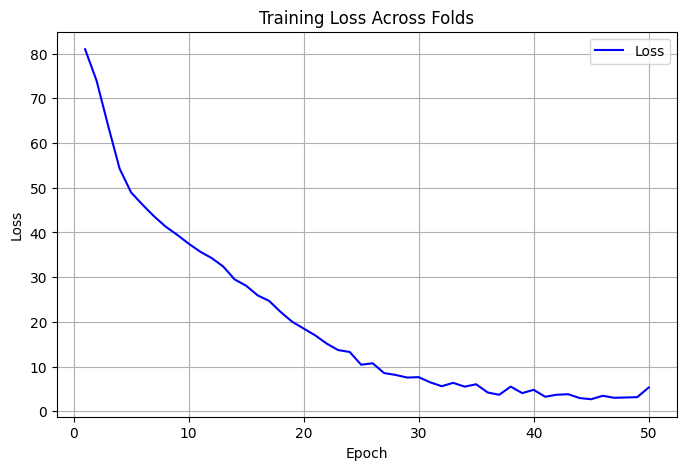

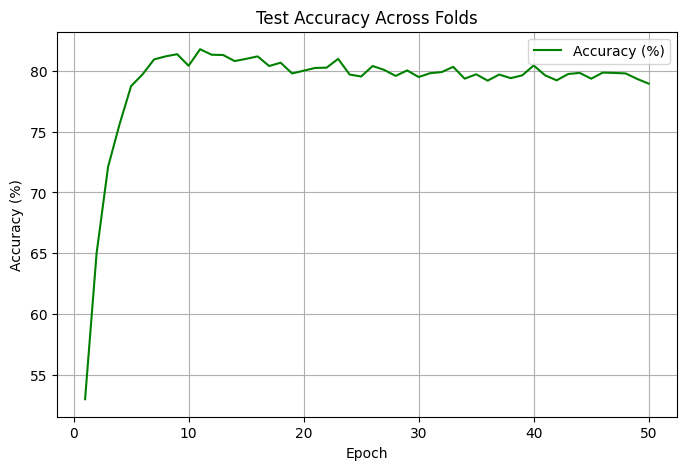

In [ ]:
train_5fold_cross_validation(SpatialCNNTransformer, learning_rate=1e-4, feature_method='cnn', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 961)
Epoch 1/50, Loss: 80.0861, Test Acc: 0.5204
Epoch 2/50, Loss: 72.6530, Test Acc: 0.6689
Epoch 3/50, Loss: 61.2902, Test Acc: 0.7358
Epoch 4/50, Loss: 52.6985, Test Acc: 0.7517
Epoch 5/50, Loss: 47.9757, Test Acc: 0.7664
Epoch 6/50, Loss: 46.3583, Test Acc: 0.7653
Epoch 7/50, Loss: 43.0596, Test Acc: 0.7914
Epoch 8/50, Loss: 40.9524, Test Acc: 0.7902
Epoch 9/50, Loss: 39.0924, Test Acc: 0.7868
Epoch 10/50, Loss: 36.3605, Test Acc: 0.7834
Epoch 11/50, Loss: 36.0104, Test Acc: 0.7880
Epoch 12/50, Loss: 34.0072, Test Acc: 0.7868
Epoch 13/50, Loss: 31.4653, Test Acc: 0.7834
Epoch 14/50, Loss: 30.7964, Test Acc: 0.7868
Epoch 15/50, Loss: 28.4854, Test Acc: 0.7778
Epoch 16/50, Loss: 26.6759, Test Acc: 0.8118
Epoch 17/50, Loss: 24.7545, Test Acc: 0.8073
Epoch 18/50, Loss: 21.6941, Test Acc: 0.7971
Epoch 19/50, Loss: 22.3143, Test Acc: 0.7948
Epoch 20/50, Loss: 17.1754, Test Acc: 0.7868
Epoch 21/50, Loss: 17.2132, Test Acc: 0.7834
Epoch 22/50, L

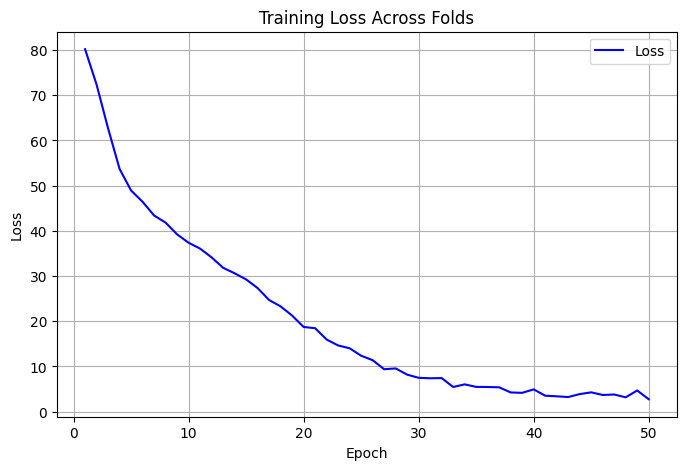

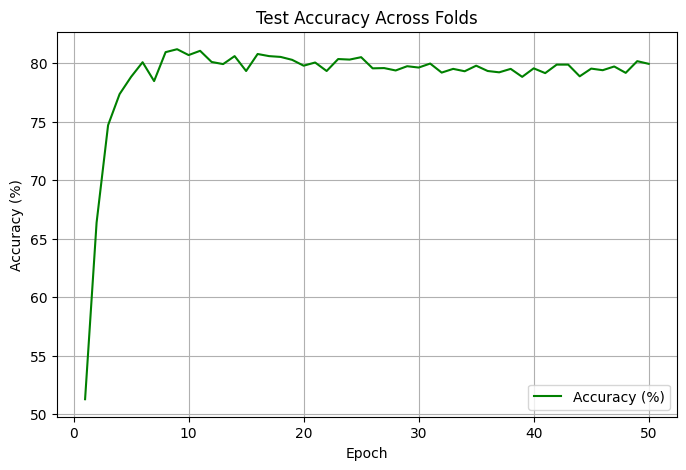

In [ ]:
train_5fold_cross_validation(SpatialCNNTransformer, learning_rate=7e-4, feature_method='cnn', subject_data= subject_data_preload)

db4
Precomputing wavelet_packet features for all subjects...
[DEBUG] S001: X_feat shape = (42, 64, 8, 135)
[DEBUG] S002: X_feat shape = (42, 64, 8, 135)
[DEBUG] S003: X_feat shape = (42, 64, 8, 135)
[DEBUG] S004: X_feat shape = (42, 64, 8, 135)
[DEBUG] S005: X_feat shape = (42, 64, 8, 135)
[DEBUG] S006: X_feat shape = (42, 64, 8, 135)
[DEBUG] S007: X_feat shape = (42, 64, 8, 135)
[DEBUG] S008: X_feat shape = (42, 64, 8, 135)
[DEBUG] S009: X_feat shape = (42, 64, 8, 135)
[DEBUG] S010: X_feat shape = (42, 64, 8, 135)
[DEBUG] S011: X_feat shape = (42, 64, 8, 135)
[DEBUG] S012: X_feat shape = (42, 64, 8, 135)
[DEBUG] S013: X_feat shape = (42, 64, 8, 135)
[DEBUG] S014: X_feat shape = (42, 64, 8, 135)
[DEBUG] S015: X_feat shape = (42, 64, 8, 135)
[DEBUG] S016: X_feat shape = (42, 64, 8, 135)
[DEBUG] S017: X_feat shape = (42, 64, 8, 135)
[DEBUG] S018: X_feat shape = (42, 64, 8, 135)
[DEBUG] S019: X_feat shape = (42, 64, 8, 135)
[DEBUG] S020: X_feat shape = (42, 64, 8, 135)
[DEBUG] S021: X_fea

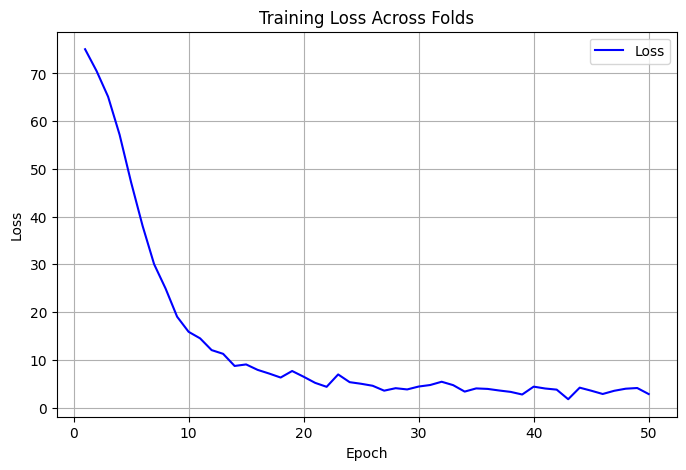

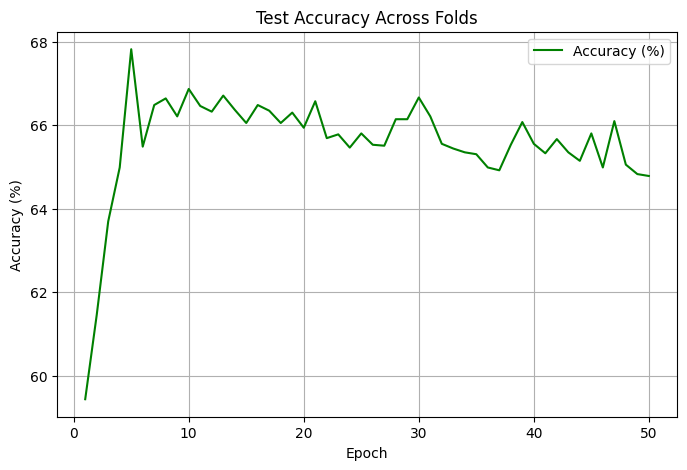

In [ ]:
WAVELET_TYPE = 'db4'
print(WAVELET_TYPE)
train_5fold_cross_validation(SpatialTransformer, learning_rate=1e-3, feature_method='wavelet_packet', subject_data= subject_data_preload)

db4
Precomputing wavelet_packet features for all subjects...
[DEBUG] S001: X_feat shape = (42, 64, 8, 135)
[DEBUG] S002: X_feat shape = (42, 64, 8, 135)
[DEBUG] S003: X_feat shape = (42, 64, 8, 135)
[DEBUG] S004: X_feat shape = (42, 64, 8, 135)
[DEBUG] S005: X_feat shape = (42, 64, 8, 135)
[DEBUG] S006: X_feat shape = (42, 64, 8, 135)
[DEBUG] S007: X_feat shape = (42, 64, 8, 135)
[DEBUG] S008: X_feat shape = (42, 64, 8, 135)
[DEBUG] S009: X_feat shape = (42, 64, 8, 135)
[DEBUG] S010: X_feat shape = (42, 64, 8, 135)
[DEBUG] S011: X_feat shape = (42, 64, 8, 135)
[DEBUG] S012: X_feat shape = (42, 64, 8, 135)
[DEBUG] S013: X_feat shape = (42, 64, 8, 135)
[DEBUG] S014: X_feat shape = (42, 64, 8, 135)
[DEBUG] S015: X_feat shape = (42, 64, 8, 135)
[DEBUG] S016: X_feat shape = (42, 64, 8, 135)
[DEBUG] S017: X_feat shape = (42, 64, 8, 135)
[DEBUG] S018: X_feat shape = (42, 64, 8, 135)
[DEBUG] S019: X_feat shape = (42, 64, 8, 135)
[DEBUG] S020: X_feat shape = (42, 64, 8, 135)
[DEBUG] S021: X_fea

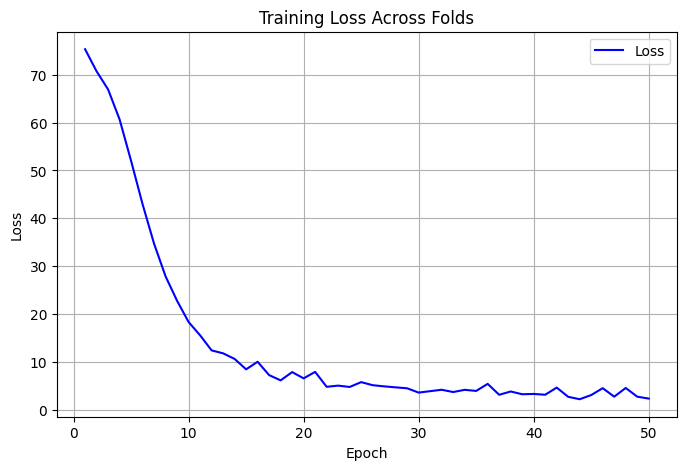

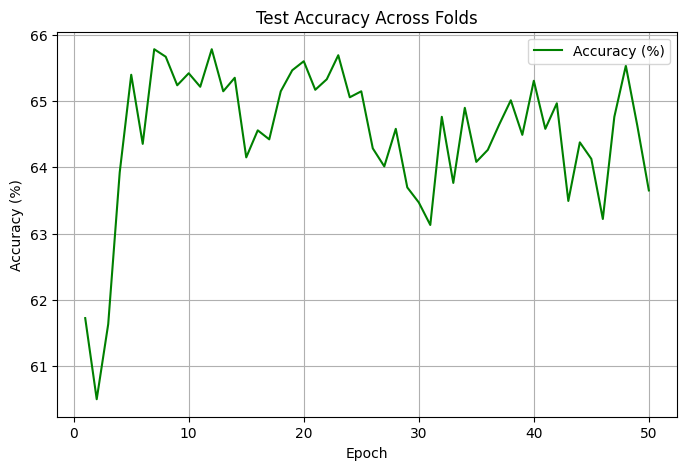

In [ ]:
WAVELET_TYPE = 'db4'
print(WAVELET_TYPE)
train_5fold_cross_validation(SpatialTransformer, learning_rate=1e-4, feature_method='wavelet_packet', subject_data= subject_data_preload)

In [ ]:
WAVELET_TYPE = 'db6'
print(WAVELET_TYPE)
train_5fold_cross_validation(FusionCNNTransformer, learning_rate=1e-4, feature_method='wavelet_packet', subject_data= subject_data_preload)

db6
Precomputing wavelet_packet features for all subjects...
[DEBUG] S001: X_feat shape = (42, 64, 8, 135)
[DEBUG] S002: X_feat shape = (42, 64, 8, 135)
[DEBUG] S003: X_feat shape = (42, 64, 8, 135)
[DEBUG] S004: X_feat shape = (42, 64, 8, 135)
[DEBUG] S005: X_feat shape = (42, 64, 8, 135)
[DEBUG] S006: X_feat shape = (42, 64, 8, 135)
[DEBUG] S007: X_feat shape = (42, 64, 8, 135)
[DEBUG] S008: X_feat shape = (42, 64, 8, 135)
[DEBUG] S009: X_feat shape = (42, 64, 8, 135)
[DEBUG] S010: X_feat shape = (42, 64, 8, 135)


KeyboardInterrupt: 

In [ ]:
N_FFT = 64
HOP_LENGTH = 16
train_5fold_cross_validation(TemporalTransformer, learning_rate=7e-4, feature_method='stft', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 961)
DATA device / shapes: cpu torch.Size([32, 64, 961]) labels: torch.Size([32]) torch.int64
feature_extractor out: torch.Size([32, 2, 64, 33, 61]) mean/std: -0.0006444058963097632 3.8678324222564697
per-token std mean: 2.4249978065490723


/tmp/ipython-input-3536287183.py:67: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  print("logits shape:", out.shape, "min/max/mean/std:", float(out.min()), float(out.max()), float(out.mean()), float(out.std()))


logits shape: torch.Size([32, 2]) min/max/mean/std: -1.843124508857727 0.41159507632255554 -0.2878708839416504 0.3274132311344147
pred counts (first batch): (tensor([1]), tensor([32]))
loss: 0.7973870038986206
parameter gradients (name, grad_norm), first 20 entries:
('embedding.weight', 4.02039098739624)
('embedding.bias', 0.060677606612443924)
('transformer.0.attn.in_proj_weight', 0.39045512676239014)
('transformer.0.attn.in_proj_bias', 0.04024863243103027)
('transformer.0.attn.out_proj.weight', 0.29457589983940125)
('transformer.0.attn.out_proj.bias', 0.05570178106427193)
('transformer.0.ff.0.weight', 0.1259174644947052)
('transformer.0.ff.0.bias', 0.043199572712183)
('transformer.0.ff.2.weight', 0.8002965450286865)
('transformer.0.ff.2.bias', 0.13522855937480927)
('transformer.0.norm1.weight', 0.033729493618011475)
('transformer.0.norm1.bias', 0.13316500186920166)
('transformer.0.norm2.weight', 0.04031240567564964)
('transformer.0.norm2.bias', 0.1390911191701889)
('transformer.1.att


Fold 1/5
[DEBUG] Input to model: (3528, 64, 481)
Epoch 1/50, Loss: 77.6103, Test Acc: 0.5998
Epoch 2/50, Loss: 69.9112, Test Acc: 0.6168
Epoch 3/50, Loss: 65.3352, Test Acc: 0.6531
Epoch 4/50, Loss: 62.5443, Test Acc: 0.6281
Epoch 5/50, Loss: 61.5324, Test Acc: 0.6372
Epoch 6/50, Loss: 62.4003, Test Acc: 0.6327
Epoch 7/50, Loss: 62.4480, Test Acc: 0.6293
Epoch 8/50, Loss: 61.4659, Test Acc: 0.6485
Epoch 9/50, Loss: 60.6938, Test Acc: 0.6429
Epoch 10/50, Loss: 60.7235, Test Acc: 0.6338
Epoch 11/50, Loss: 60.5782, Test Acc: 0.6667
Epoch 12/50, Loss: 59.9022, Test Acc: 0.6429
Epoch 13/50, Loss: 60.6398, Test Acc: 0.6406
Epoch 14/50, Loss: 61.5565, Test Acc: 0.6406
Epoch 15/50, Loss: 60.0907, Test Acc: 0.6531
Epoch 16/50, Loss: 60.1707, Test Acc: 0.6689
Epoch 17/50, Loss: 59.5813, Test Acc: 0.6723
Epoch 18/50, Loss: 59.3942, Test Acc: 0.6701
Epoch 19/50, Loss: 58.2802, Test Acc: 0.6315
Epoch 20/50, Loss: 57.3195, Test Acc: 0.6451
Epoch 21/50, Loss: 56.8228, Test Acc: 0.6633
Epoch 22/50, L

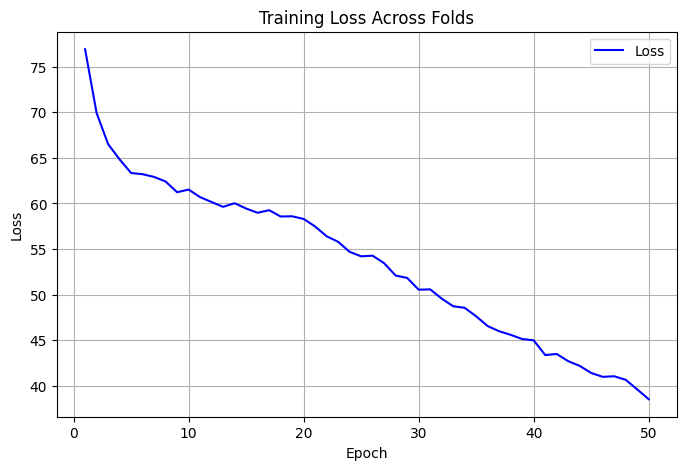

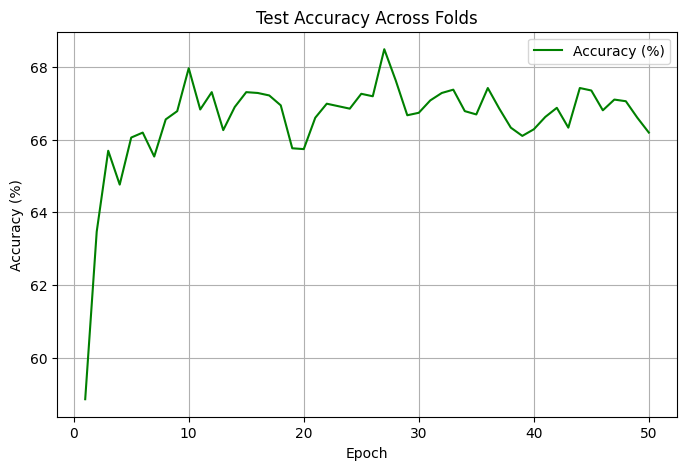

In [ ]:
N_FFT = 64
HOP_LENGTH = 16
train_5fold_cross_validation(TemporalTransformer, learning_rate=7e-4, feature_method='stft', subject_data= subject_data_preload)

In [ ]:
N_FFT = 64
HOP_LENGTH = 16
train_5fold_cross_validation(TemporalCNNTransformer, learning_rate=1e-4, feature_method='stft', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 481)
Epoch 1/50, Loss: 80.7517, Test Acc: 0.5000
Epoch 2/50, Loss: 77.6930, Test Acc: 0.5011
Epoch 3/50, Loss: 67.0422, Test Acc: 0.7392
Epoch 4/50, Loss: 54.3270, Test Acc: 0.7347
Epoch 5/50, Loss: 52.1498, Test Acc: 0.7698
Epoch 6/50, Loss: 49.4588, Test Acc: 0.7551
Epoch 7/50, Loss: 48.3945, Test Acc: 0.7687
Epoch 8/50, Loss: 45.9582, Test Acc: 0.7551
Epoch 9/50, Loss: 44.8398, Test Acc: 0.7517
Epoch 10/50, Loss: 43.7789, Test Acc: 0.7608
Epoch 11/50, Loss: 41.9594, Test Acc: 0.7596
Epoch 12/50, Loss: 41.0445, Test Acc: 0.7551
Epoch 13/50, Loss: 39.5767, Test Acc: 0.7585
Epoch 14/50, Loss: 37.6379, Test Acc: 0.7540
Epoch 15/50, Loss: 35.3865, Test Acc: 0.7460
Epoch 16/50, Loss: 34.9355, Test Acc: 0.7528
Epoch 17/50, Loss: 32.8362, Test Acc: 0.7460
Epoch 18/50, Loss: 30.3302, Test Acc: 0.7404
Epoch 19/50, Loss: 27.3267, Test Acc: 0.7358
Epoch 20/50, Loss: 25.0068, Test Acc: 0.7256
Epoch 21/50, Loss: 25.3112, Test Acc: 0.7313
Epoch 22/50, L

KeyboardInterrupt: 


Fold 1/5
Fitting CSP incrementally on per-subject data (memory safe)...
num_patches 240
Epoch 1/50, Loss: 80.5243, Test Acc: 0.5000
Epoch 2/50, Loss: 77.4839, Test Acc: 0.5000
Epoch 3/50, Loss: 77.4336, Test Acc: 0.5000
Epoch 4/50, Loss: 77.3840, Test Acc: 0.5000
Epoch 5/50, Loss: 77.5262, Test Acc: 0.5000
Epoch 6/50, Loss: 77.2168, Test Acc: 0.5000
Epoch 7/50, Loss: 77.1328, Test Acc: 0.5000
Epoch 8/50, Loss: 77.1243, Test Acc: 0.5000
Epoch 9/50, Loss: 77.0093, Test Acc: 0.5000
Epoch 10/50, Loss: 77.5891, Test Acc: 0.5000
Epoch 11/50, Loss: 77.0816, Test Acc: 0.5000
Epoch 12/50, Loss: 77.0785, Test Acc: 0.5000
Epoch 13/50, Loss: 77.0659, Test Acc: 0.5000
Epoch 14/50, Loss: 77.2404, Test Acc: 0.5000
Epoch 15/50, Loss: 77.0529, Test Acc: 0.5000
Epoch 16/50, Loss: 77.0702, Test Acc: 0.5000
Epoch 17/50, Loss: 77.0920, Test Acc: 0.5000
Epoch 18/50, Loss: 77.0428, Test Acc: 0.5000
Epoch 19/50, Loss: 77.0708, Test Acc: 0.5000
Epoch 20/50, Loss: 77.1009, Test Acc: 0.5000
Epoch 21/50, Loss: 7

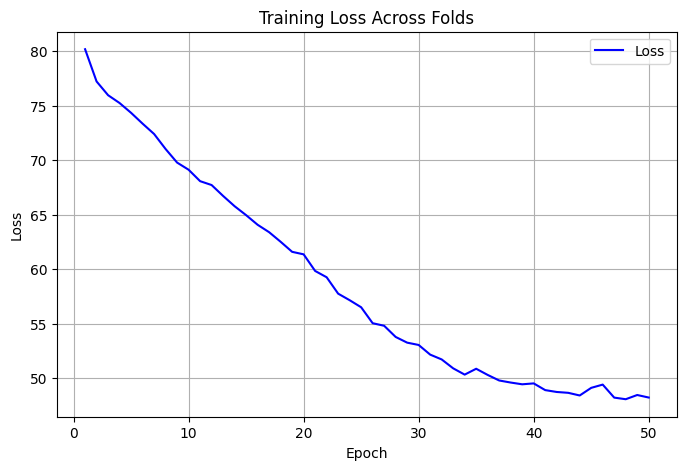

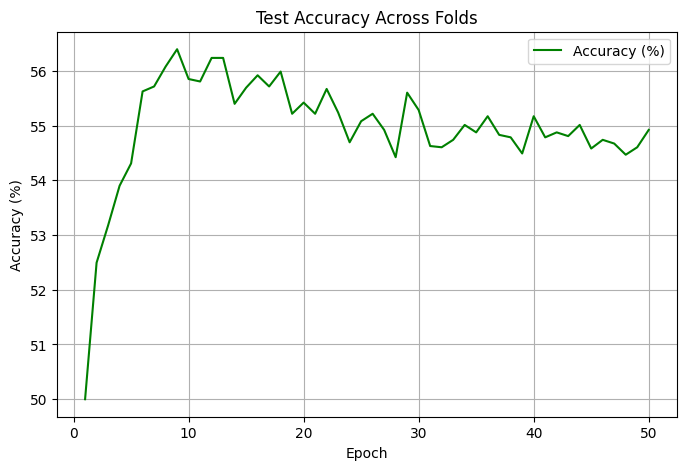

In [ ]:
NUM_COMP = 6
PATCH_SIZE = 4
train_5fold_cross_validation(TemporalCNNTransformer, learning_rate=1e-3, feature_method='csp', subject_data= subject_data_preload)


Fold 1/5
Fitting CSP incrementally on per-subject data (memory safe)...
num_patches 240
Epoch 1/50, Loss: 80.8188, Test Acc: 0.5000
Epoch 2/50, Loss: 77.8924, Test Acc: 0.5000
Epoch 3/50, Loss: 77.2708, Test Acc: 0.5000
Epoch 4/50, Loss: 77.3223, Test Acc: 0.5000
Epoch 5/50, Loss: 77.7548, Test Acc: 0.5000
Epoch 6/50, Loss: 77.2822, Test Acc: 0.5000
Epoch 7/50, Loss: 77.4198, Test Acc: 0.5000
Epoch 8/50, Loss: 77.1260, Test Acc: 0.5000
Epoch 9/50, Loss: 77.2033, Test Acc: 0.5000
Epoch 10/50, Loss: 77.3750, Test Acc: 0.5000
Epoch 11/50, Loss: 77.2479, Test Acc: 0.5000
Epoch 12/50, Loss: 77.2070, Test Acc: 0.5000
Epoch 13/50, Loss: 77.2734, Test Acc: 0.5000
Epoch 14/50, Loss: 77.0364, Test Acc: 0.5000
Epoch 15/50, Loss: 77.1246, Test Acc: 0.5000
Epoch 16/50, Loss: 77.0991, Test Acc: 0.5000
Epoch 17/50, Loss: 77.0297, Test Acc: 0.5000
Epoch 18/50, Loss: 77.0482, Test Acc: 0.5000
Epoch 19/50, Loss: 77.1048, Test Acc: 0.5000
Epoch 20/50, Loss: 77.0803, Test Acc: 0.5000
Epoch 21/50, Loss: 7

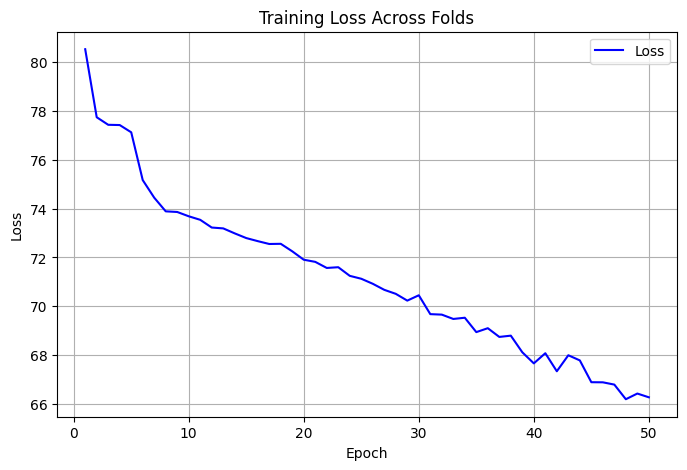

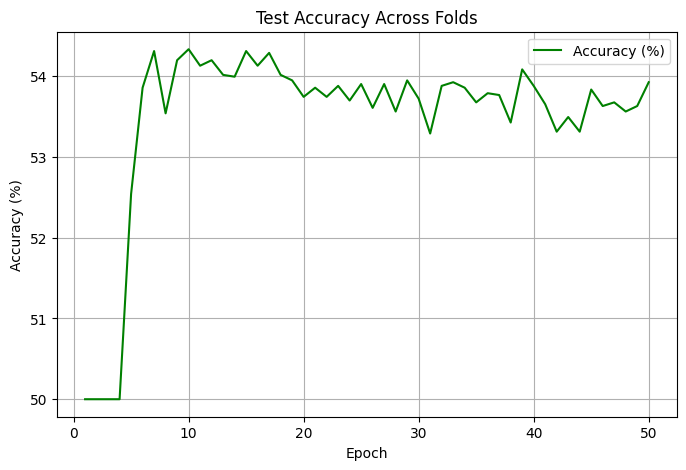

In [ ]:
NUM_COMP = 6
PATCH_SIZE = 4
train_5fold_cross_validation(TemporalCNNTransformer, learning_rate=1e-3, feature_method='csp', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 961)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1027.)
  return F.conv2d(


Epoch 1/50, Loss: 79.6458, Test Acc: 0.5000
Epoch 2/50, Loss: 77.6296, Test Acc: 0.5533
Epoch 3/50, Loss: 76.3336, Test Acc: 0.5975
Epoch 4/50, Loss: 71.9206, Test Acc: 0.5941
Epoch 5/50, Loss: 67.0024, Test Acc: 0.7029
Epoch 6/50, Loss: 61.2038, Test Acc: 0.7075
Epoch 7/50, Loss: 56.3487, Test Acc: 0.7517
Epoch 8/50, Loss: 53.2284, Test Acc: 0.7494
Epoch 9/50, Loss: 50.6138, Test Acc: 0.7619
Epoch 10/50, Loss: 49.0976, Test Acc: 0.7732
Epoch 11/50, Loss: 48.1991, Test Acc: 0.7755
Epoch 12/50, Loss: 46.8817, Test Acc: 0.7698
Epoch 13/50, Loss: 46.1708, Test Acc: 0.7710
Epoch 14/50, Loss: 46.3171, Test Acc: 0.7596
Epoch 15/50, Loss: 44.3775, Test Acc: 0.7721
Epoch 16/50, Loss: 43.2974, Test Acc: 0.7755
Epoch 17/50, Loss: 43.0159, Test Acc: 0.7528
Epoch 18/50, Loss: 42.3727, Test Acc: 0.7710
Epoch 19/50, Loss: 41.1464, Test Acc: 0.7698
Epoch 20/50, Loss: 40.0226, Test Acc: 0.7698
Epoch 21/50, Loss: 40.4460, Test Acc: 0.7608
Epoch 22/50, Loss: 38.2657, Test Acc: 0.7721
Epoch 23/50, Loss: 

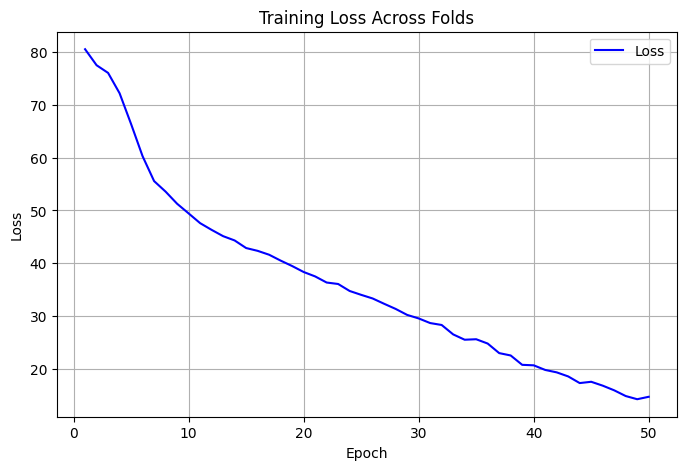

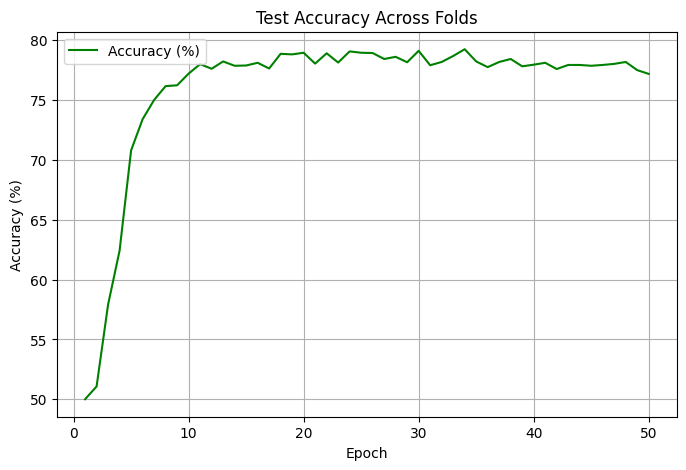

In [ ]:
train_5fold_cross_validation(SpatialCNNTransformer, learning_rate=7e-4, feature_method='raw', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 961)
Epoch 1/50, Loss: 80.6220, Test Acc: 0.5000
Epoch 2/50, Loss: 77.0131, Test Acc: 0.5465
Epoch 3/50, Loss: 75.3094, Test Acc: 0.5896
Epoch 4/50, Loss: 73.2493, Test Acc: 0.5918
Epoch 5/50, Loss: 71.6500, Test Acc: 0.6145
Epoch 6/50, Loss: 70.2404, Test Acc: 0.6417
Epoch 7/50, Loss: 65.2008, Test Acc: 0.6497
Epoch 8/50, Loss: 52.2423, Test Acc: 0.7551
Epoch 9/50, Loss: 45.2381, Test Acc: 0.7642
Epoch 10/50, Loss: 43.0695, Test Acc: 0.7778
Epoch 11/50, Loss: 42.3605, Test Acc: 0.8107
Epoch 12/50, Loss: 41.1310, Test Acc: 0.8039
Epoch 13/50, Loss: 39.0964, Test Acc: 0.7993
Epoch 14/50, Loss: 38.6070, Test Acc: 0.7925
Epoch 15/50, Loss: 38.3131, Test Acc: 0.8141
Epoch 16/50, Loss: 38.1244, Test Acc: 0.8186
Epoch 17/50, Loss: 36.6341, Test Acc: 0.8197
Epoch 18/50, Loss: 35.1352, Test Acc: 0.8073
Epoch 19/50, Loss: 34.1396, Test Acc: 0.8152
Epoch 20/50, Loss: 33.5779, Test Acc: 0.8322
Epoch 21/50, Loss: 34.5441, Test Acc: 0.8265
Epoch 22/50, L

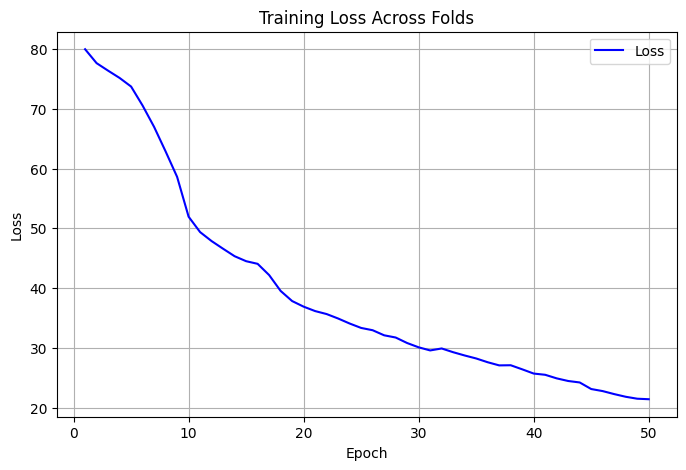

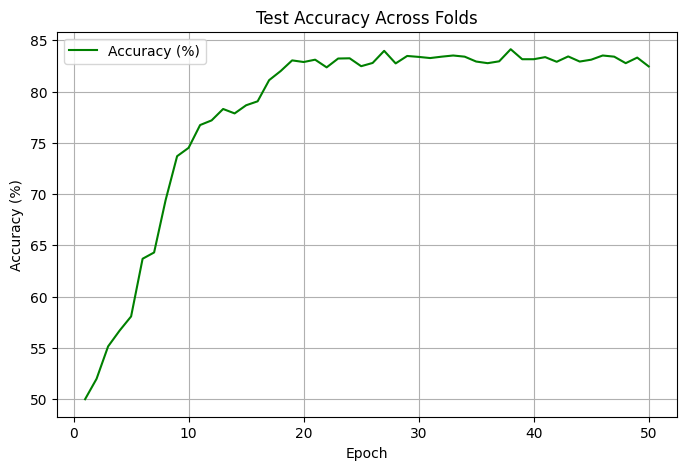

In [ ]:
train_5fold_cross_validation(TemporalCNNTransformer, learning_rate=1e-4, feature_method='cnn', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 961)
Epoch 1/50, Loss: 80.0463, Test Acc: 0.5873
Epoch 2/50, Loss: 68.8612, Test Acc: 0.7188
Epoch 3/50, Loss: 54.2638, Test Acc: 0.7800
Epoch 4/50, Loss: 48.6115, Test Acc: 0.7823
Epoch 5/50, Loss: 45.2592, Test Acc: 0.7959
Epoch 6/50, Loss: 42.3326, Test Acc: 0.7800
Epoch 7/50, Loss: 41.3952, Test Acc: 0.7834
Epoch 8/50, Loss: 40.7124, Test Acc: 0.8175
Epoch 9/50, Loss: 36.3657, Test Acc: 0.7993
Epoch 10/50, Loss: 35.6969, Test Acc: 0.8129
Epoch 11/50, Loss: 34.3525, Test Acc: 0.7914
Epoch 12/50, Loss: 32.6669, Test Acc: 0.8129
Epoch 13/50, Loss: 30.0244, Test Acc: 0.8231
Epoch 14/50, Loss: 27.4246, Test Acc: 0.8016
Epoch 15/50, Loss: 28.0859, Test Acc: 0.8084
Epoch 16/50, Loss: 26.7386, Test Acc: 0.8073
Epoch 17/50, Loss: 24.1205, Test Acc: 0.8220
Epoch 18/50, Loss: 25.8033, Test Acc: 0.8005
Epoch 19/50, Loss: 21.8327, Test Acc: 0.8265
Epoch 20/50, Loss: 19.4666, Test Acc: 0.8084
Epoch 21/50, Loss: 18.3359, Test Acc: 0.8141
Epoch 22/50, L

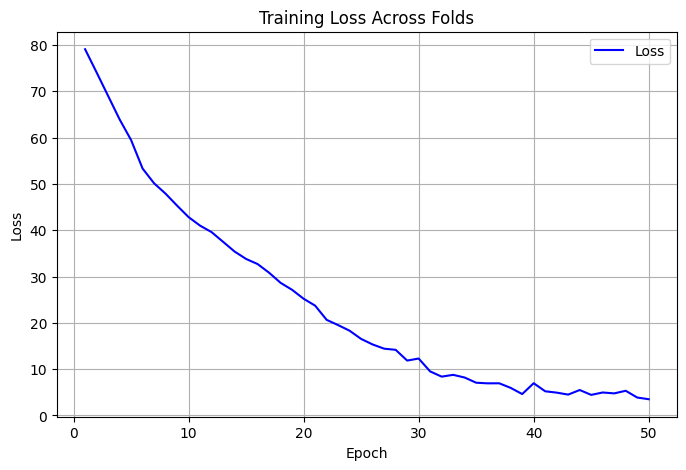

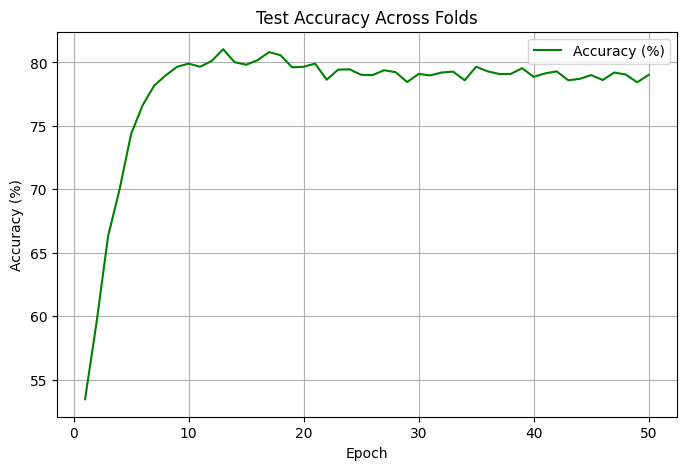

In [ ]:
train_5fold_cross_validation(FusionCNNTransformer, learning_rate=1e-4, feature_method='cnn', subject_data= subject_data_preload)

Precomputing wavelet_packet features for all subjects...
[DEBUG] S001: X_feat shape = (42, 64, 8, 135)
[DEBUG] S002: X_feat shape = (42, 64, 8, 135)
[DEBUG] S003: X_feat shape = (42, 64, 8, 135)
[DEBUG] S004: X_feat shape = (42, 64, 8, 135)
[DEBUG] S005: X_feat shape = (42, 64, 8, 135)
[DEBUG] S006: X_feat shape = (42, 64, 8, 135)
[DEBUG] S007: X_feat shape = (42, 64, 8, 135)
[DEBUG] S008: X_feat shape = (42, 64, 8, 135)
[DEBUG] S009: X_feat shape = (42, 64, 8, 135)
[DEBUG] S010: X_feat shape = (42, 64, 8, 135)
[DEBUG] S011: X_feat shape = (42, 64, 8, 135)
[DEBUG] S012: X_feat shape = (42, 64, 8, 135)
[DEBUG] S013: X_feat shape = (42, 64, 8, 135)
[DEBUG] S014: X_feat shape = (42, 64, 8, 135)
[DEBUG] S015: X_feat shape = (42, 64, 8, 135)
[DEBUG] S016: X_feat shape = (42, 64, 8, 135)
[DEBUG] S017: X_feat shape = (42, 64, 8, 135)
[DEBUG] S018: X_feat shape = (42, 64, 8, 135)
[DEBUG] S019: X_feat shape = (42, 64, 8, 135)
[DEBUG] S020: X_feat shape = (42, 64, 8, 135)
[DEBUG] S021: X_feat sh

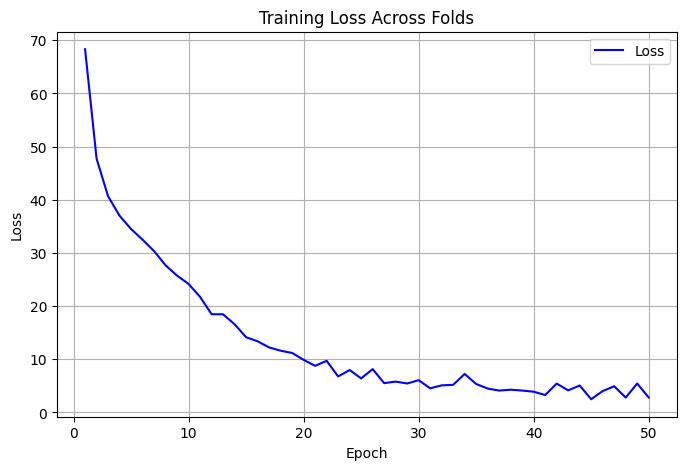

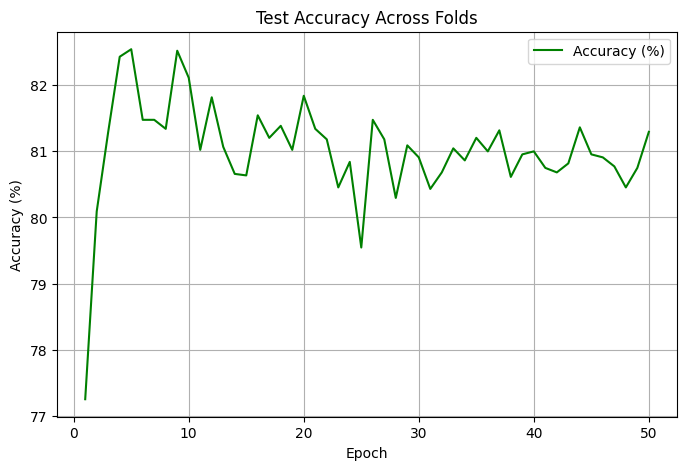

In [ ]:
train_5fold_cross_validation(TemporalTransformer, learning_rate=1e-4, feature_method='wavelet_packet', subject_data= subject_data_preload)

In [ ]:
WAVELET_TYPE = 'db4'
print(WAVELET_TYPE)


db4


Precomputing wavelet_packet features for all subjects...
[DEBUG] S001: X_feat shape = (42, 64, 8, 135)
[DEBUG] S002: X_feat shape = (42, 64, 8, 135)
[DEBUG] S003: X_feat shape = (42, 64, 8, 135)
[DEBUG] S004: X_feat shape = (42, 64, 8, 135)
[DEBUG] S005: X_feat shape = (42, 64, 8, 135)
[DEBUG] S006: X_feat shape = (42, 64, 8, 135)
[DEBUG] S007: X_feat shape = (42, 64, 8, 135)
[DEBUG] S008: X_feat shape = (42, 64, 8, 135)
[DEBUG] S009: X_feat shape = (42, 64, 8, 135)
[DEBUG] S010: X_feat shape = (42, 64, 8, 135)
[DEBUG] S011: X_feat shape = (42, 64, 8, 135)
[DEBUG] S012: X_feat shape = (42, 64, 8, 135)
[DEBUG] S013: X_feat shape = (42, 64, 8, 135)
[DEBUG] S014: X_feat shape = (42, 64, 8, 135)
[DEBUG] S015: X_feat shape = (42, 64, 8, 135)
[DEBUG] S016: X_feat shape = (42, 64, 8, 135)
[DEBUG] S017: X_feat shape = (42, 64, 8, 135)
[DEBUG] S018: X_feat shape = (42, 64, 8, 135)
[DEBUG] S019: X_feat shape = (42, 64, 8, 135)
[DEBUG] S020: X_feat shape = (42, 64, 8, 135)
[DEBUG] S021: X_feat sh

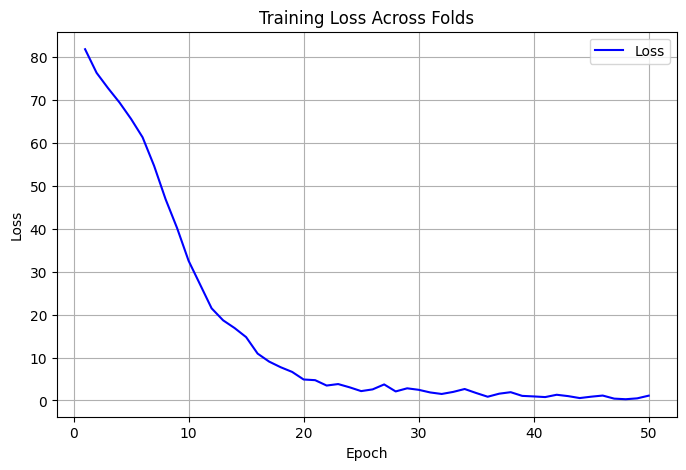

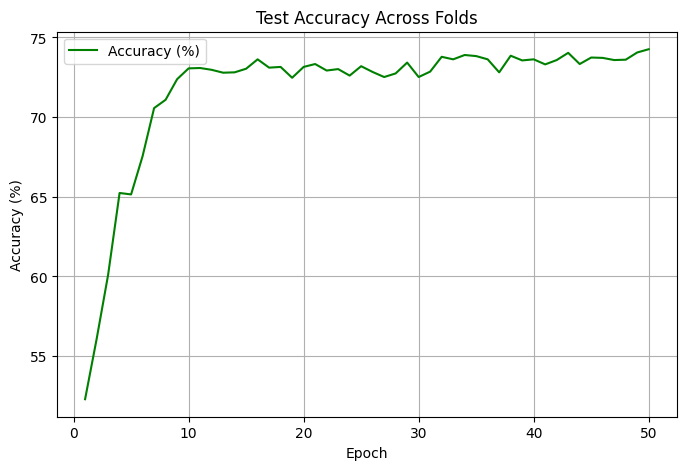

In [ ]:
train_5fold_cross_validation(SpatialCNNTransformer, learning_rate=1e-4, feature_method='wavelet_packet', subject_data= subject_data_preload)

In [ ]:
WAVELET_TYPE = 'coif3'
print(WAVELET_TYPE)


coif3


Precomputing wavelet_packet features for all subjects...
[DEBUG] S001: X_feat shape = (42, 64, 8, 135)
[DEBUG] S002: X_feat shape = (42, 64, 8, 135)
[DEBUG] S003: X_feat shape = (42, 64, 8, 135)
[DEBUG] S004: X_feat shape = (42, 64, 8, 135)
[DEBUG] S005: X_feat shape = (42, 64, 8, 135)
[DEBUG] S006: X_feat shape = (42, 64, 8, 135)
[DEBUG] S007: X_feat shape = (42, 64, 8, 135)
[DEBUG] S008: X_feat shape = (42, 64, 8, 135)
[DEBUG] S009: X_feat shape = (42, 64, 8, 135)
[DEBUG] S010: X_feat shape = (42, 64, 8, 135)
[DEBUG] S011: X_feat shape = (42, 64, 8, 135)
[DEBUG] S012: X_feat shape = (42, 64, 8, 135)
[DEBUG] S013: X_feat shape = (42, 64, 8, 135)
[DEBUG] S014: X_feat shape = (42, 64, 8, 135)
[DEBUG] S015: X_feat shape = (42, 64, 8, 135)
[DEBUG] S016: X_feat shape = (42, 64, 8, 135)
[DEBUG] S017: X_feat shape = (42, 64, 8, 135)
[DEBUG] S018: X_feat shape = (42, 64, 8, 135)
[DEBUG] S019: X_feat shape = (42, 64, 8, 135)
[DEBUG] S020: X_feat shape = (42, 64, 8, 135)
[DEBUG] S021: X_feat sh

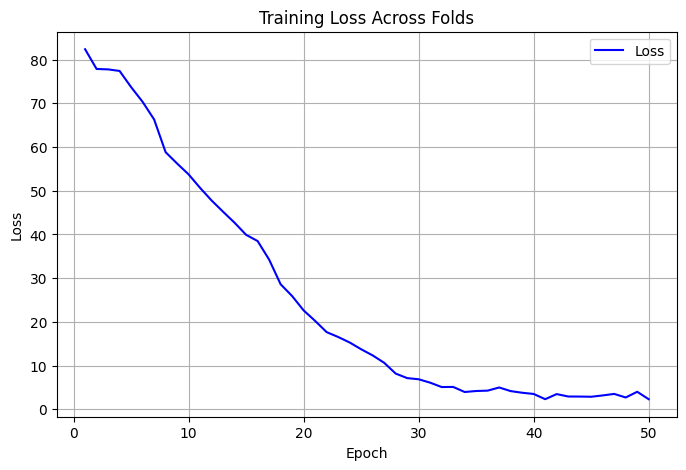

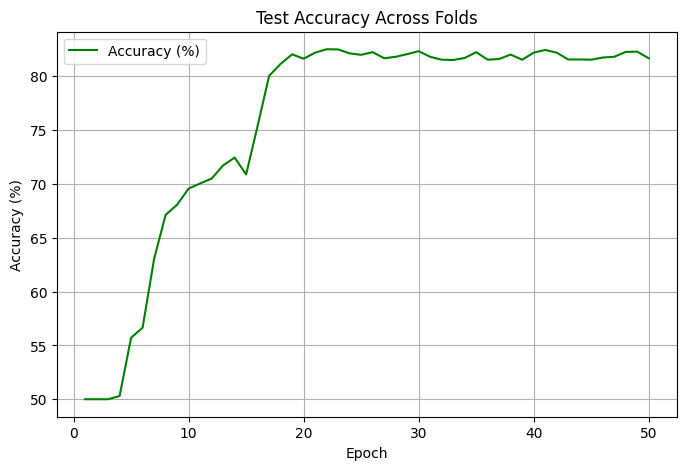

In [ ]:
train_5fold_cross_validation(TemporalCNNTransformer, learning_rate=1e-4, feature_method='wavelet_packet', subject_data= subject_data_preload)

Precomputing wavelet features for all subjects...
[DEBUG] S001: X_feat shape = (42, 64, 4, 489)
[DEBUG] S002: X_feat shape = (42, 64, 4, 489)
[DEBUG] S003: X_feat shape = (42, 64, 4, 489)
[DEBUG] S004: X_feat shape = (42, 64, 4, 489)
[DEBUG] S005: X_feat shape = (42, 64, 4, 489)
[DEBUG] S006: X_feat shape = (42, 64, 4, 489)
[DEBUG] S007: X_feat shape = (42, 64, 4, 489)
[DEBUG] S008: X_feat shape = (42, 64, 4, 489)
[DEBUG] S009: X_feat shape = (42, 64, 4, 489)
[DEBUG] S010: X_feat shape = (42, 64, 4, 489)
[DEBUG] S011: X_feat shape = (42, 64, 4, 489)
[DEBUG] S012: X_feat shape = (42, 64, 4, 489)
[DEBUG] S013: X_feat shape = (42, 64, 4, 489)
[DEBUG] S014: X_feat shape = (42, 64, 4, 489)
[DEBUG] S015: X_feat shape = (42, 64, 4, 489)
[DEBUG] S016: X_feat shape = (42, 64, 4, 489)
[DEBUG] S017: X_feat shape = (42, 64, 4, 489)
[DEBUG] S018: X_feat shape = (42, 64, 4, 489)
[DEBUG] S019: X_feat shape = (42, 64, 4, 489)
[DEBUG] S020: X_feat shape = (42, 64, 4, 489)
[DEBUG] S021: X_feat shape = (

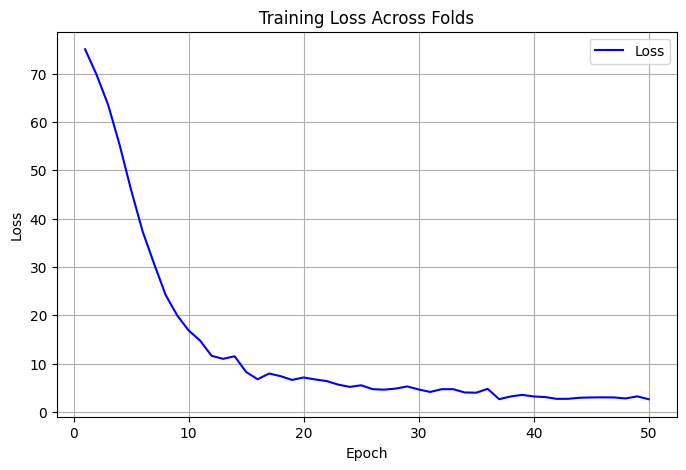

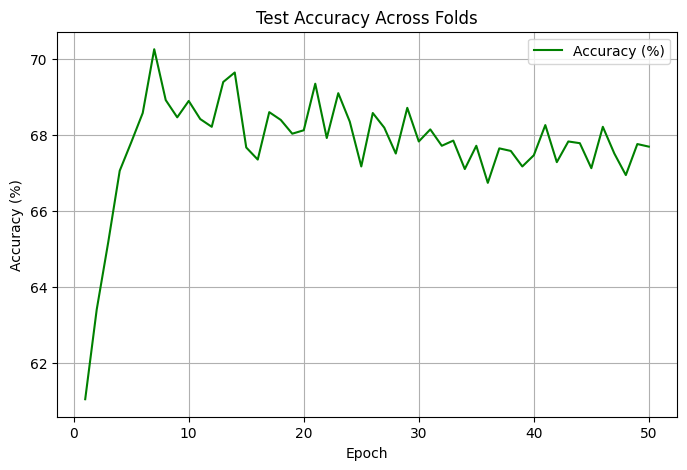

In [ ]:
train_5fold_cross_validation(SpatialTransformer, learning_rate=1e-4, feature_method='wavelet', subject_data= subject_data_preload)

db4
Precomputing wavelet features for all subjects...
[DEBUG] S001: X_feat shape = (42, 64, 4, 489)
[DEBUG] S002: X_feat shape = (42, 64, 4, 489)
[DEBUG] S003: X_feat shape = (42, 64, 4, 489)
[DEBUG] S004: X_feat shape = (42, 64, 4, 489)
[DEBUG] S005: X_feat shape = (42, 64, 4, 489)
[DEBUG] S006: X_feat shape = (42, 64, 4, 489)
[DEBUG] S007: X_feat shape = (42, 64, 4, 489)
[DEBUG] S008: X_feat shape = (42, 64, 4, 489)
[DEBUG] S009: X_feat shape = (42, 64, 4, 489)
[DEBUG] S010: X_feat shape = (42, 64, 4, 489)
[DEBUG] S011: X_feat shape = (42, 64, 4, 489)
[DEBUG] S012: X_feat shape = (42, 64, 4, 489)
[DEBUG] S013: X_feat shape = (42, 64, 4, 489)
[DEBUG] S014: X_feat shape = (42, 64, 4, 489)
[DEBUG] S015: X_feat shape = (42, 64, 4, 489)
[DEBUG] S016: X_feat shape = (42, 64, 4, 489)
[DEBUG] S017: X_feat shape = (42, 64, 4, 489)
[DEBUG] S018: X_feat shape = (42, 64, 4, 489)
[DEBUG] S019: X_feat shape = (42, 64, 4, 489)
[DEBUG] S020: X_feat shape = (42, 64, 4, 489)
[DEBUG] S021: X_feat shape

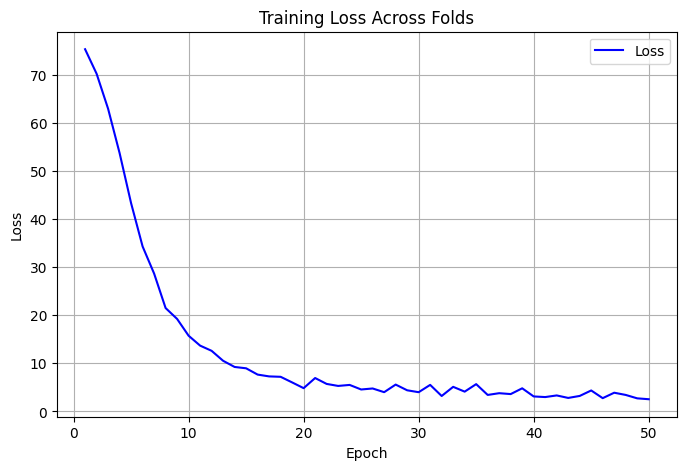

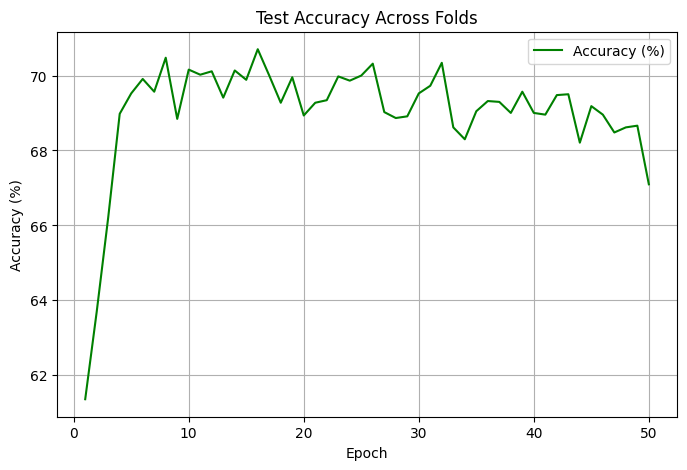

In [ ]:
WAVELET_TYPE = 'db4'
print(WAVELET_TYPE)

train_5fold_cross_validation(SpatialTransformer, learning_rate=1e-4, feature_method='wavelet', subject_data= subject_data_preload)


Fold 1/5
Fitting CSP incrementally on per-subject data (memory safe)...
Epoch 1/50, Loss: 73.4132, Test Acc: 0.6259
Epoch 2/50, Loss: 66.1584, Test Acc: 0.6587
Epoch 3/50, Loss: 63.4774, Test Acc: 0.6621
Epoch 4/50, Loss: 60.9312, Test Acc: 0.6655
Epoch 5/50, Loss: 58.5487, Test Acc: 0.6644
Epoch 6/50, Loss: 58.5969, Test Acc: 0.6621
Epoch 7/50, Loss: 55.7400, Test Acc: 0.6542
Epoch 8/50, Loss: 53.8586, Test Acc: 0.6485
Epoch 9/50, Loss: 53.2010, Test Acc: 0.6701
Epoch 10/50, Loss: 49.4407, Test Acc: 0.6315
Epoch 11/50, Loss: 48.5508, Test Acc: 0.6587
Epoch 12/50, Loss: 46.2053, Test Acc: 0.6531
Epoch 13/50, Loss: 45.3930, Test Acc: 0.6270
Epoch 14/50, Loss: 42.9800, Test Acc: 0.6247
Epoch 15/50, Loss: 41.9026, Test Acc: 0.6485
Epoch 16/50, Loss: 39.3672, Test Acc: 0.6338
Epoch 17/50, Loss: 37.1664, Test Acc: 0.6463
Epoch 18/50, Loss: 32.7922, Test Acc: 0.6224
Epoch 19/50, Loss: 30.0758, Test Acc: 0.6361
Epoch 20/50, Loss: 27.8637, Test Acc: 0.6372
Epoch 21/50, Loss: 29.9231, Test Acc

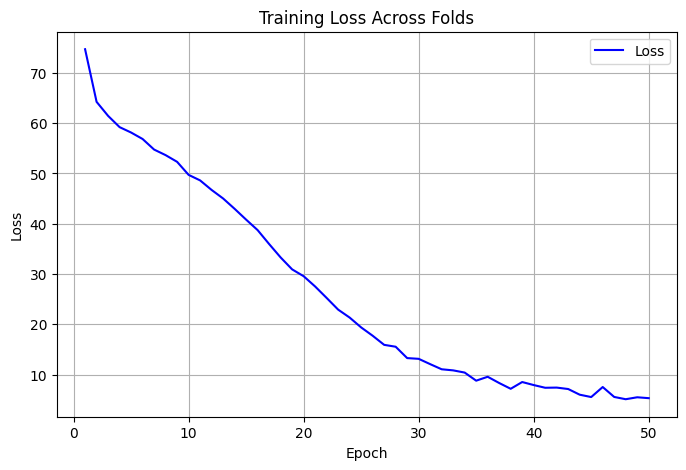

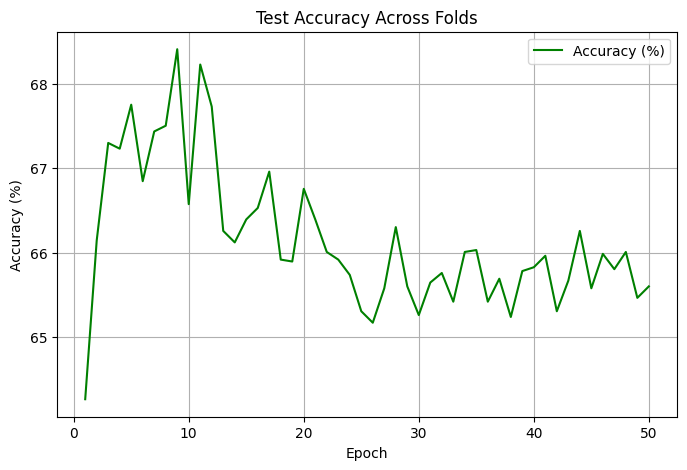

In [ ]:
PATCH_SIZE = 32
train_5fold_cross_validation(SpatialTransformer, learning_rate=1e-3, feature_method='csp', subject_data= subject_data_preload)


Fold 1/5
Fitting CSP incrementally on per-subject data (memory safe)...
Epoch 1/50, Loss: 76.7199, Test Acc: 0.6338
Epoch 2/50, Loss: 66.7619, Test Acc: 0.6848
Epoch 3/50, Loss: 61.5350, Test Acc: 0.6848
Epoch 4/50, Loss: 60.3112, Test Acc: 0.6769
Epoch 5/50, Loss: 58.5357, Test Acc: 0.6723
Epoch 6/50, Loss: 56.9818, Test Acc: 0.6633
Epoch 7/50, Loss: 58.1913, Test Acc: 0.6791
Epoch 8/50, Loss: 54.8790, Test Acc: 0.6814
Epoch 9/50, Loss: 54.3421, Test Acc: 0.6576
Epoch 10/50, Loss: 52.7395, Test Acc: 0.6621
Epoch 11/50, Loss: 52.4922, Test Acc: 0.6723
Epoch 12/50, Loss: 49.2131, Test Acc: 0.6633
Epoch 13/50, Loss: 48.4066, Test Acc: 0.6871
Epoch 14/50, Loss: 44.7831, Test Acc: 0.6655
Epoch 15/50, Loss: 42.8138, Test Acc: 0.6497
Epoch 16/50, Loss: 41.7918, Test Acc: 0.6644
Epoch 17/50, Loss: 39.5716, Test Acc: 0.6621
Epoch 18/50, Loss: 36.5867, Test Acc: 0.6576
Epoch 19/50, Loss: 34.7767, Test Acc: 0.6463
Epoch 20/50, Loss: 32.5064, Test Acc: 0.6463
Epoch 21/50, Loss: 28.5518, Test Acc

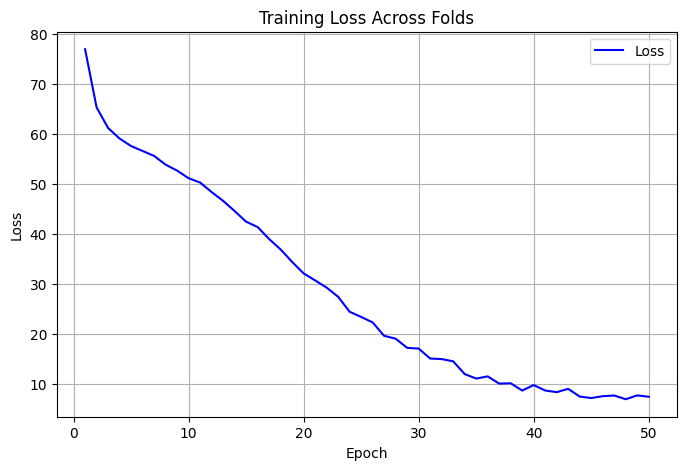

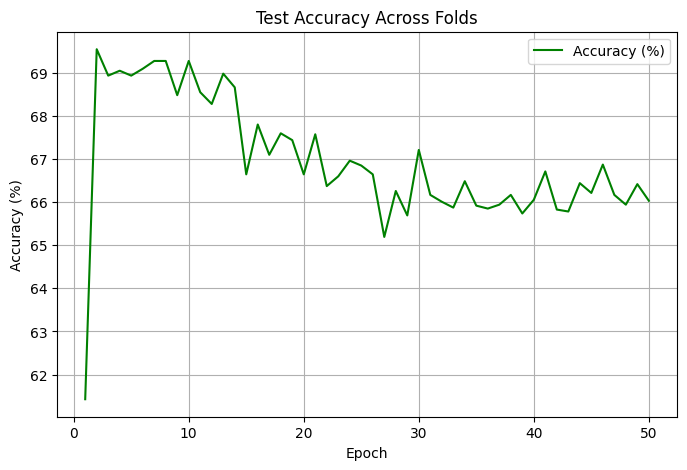

In [ ]:
PATCH_SIZE = 8
train_5fold_cross_validation(SpatialTransformer, learning_rate=1e-3, feature_method='csp', subject_data= subject_data_preload)


Fold 1/5
Fitting CSP incrementally on per-subject data (memory safe)...
Epoch 1/50, Loss: 75.2080, Test Acc: 0.6519
Epoch 2/50, Loss: 67.4341, Test Acc: 0.6757
Epoch 3/50, Loss: 65.4247, Test Acc: 0.6848
Epoch 4/50, Loss: 63.8584, Test Acc: 0.6599
Epoch 5/50, Loss: 62.9159, Test Acc: 0.6757
Epoch 6/50, Loss: 61.3234, Test Acc: 0.6599
Epoch 7/50, Loss: 59.6568, Test Acc: 0.6553
Epoch 8/50, Loss: 58.6268, Test Acc: 0.6746
Epoch 9/50, Loss: 56.4397, Test Acc: 0.6735
Epoch 10/50, Loss: 54.7693, Test Acc: 0.6440
Epoch 11/50, Loss: 52.7170, Test Acc: 0.6542
Epoch 12/50, Loss: 50.1539, Test Acc: 0.6633
Epoch 13/50, Loss: 49.1404, Test Acc: 0.6769
Epoch 14/50, Loss: 44.4131, Test Acc: 0.6565
Epoch 15/50, Loss: 41.3770, Test Acc: 0.6678
Epoch 16/50, Loss: 38.9413, Test Acc: 0.6633
Epoch 17/50, Loss: 35.7103, Test Acc: 0.6599
Epoch 18/50, Loss: 32.0045, Test Acc: 0.6644
Epoch 19/50, Loss: 30.4015, Test Acc: 0.6553
Epoch 20/50, Loss: 24.8036, Test Acc: 0.6542
Epoch 21/50, Loss: 25.4969, Test Acc

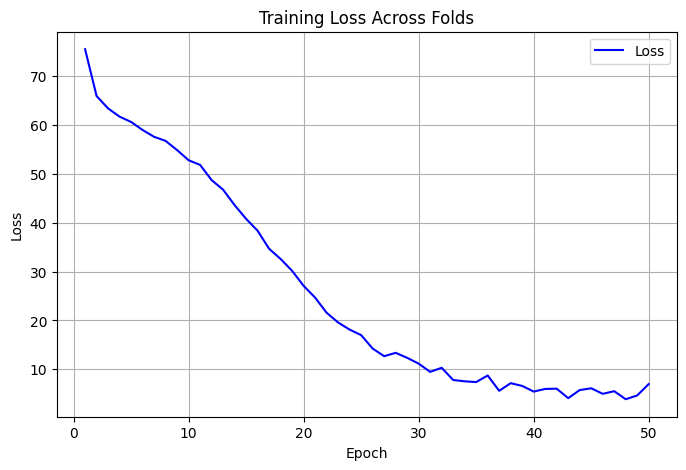

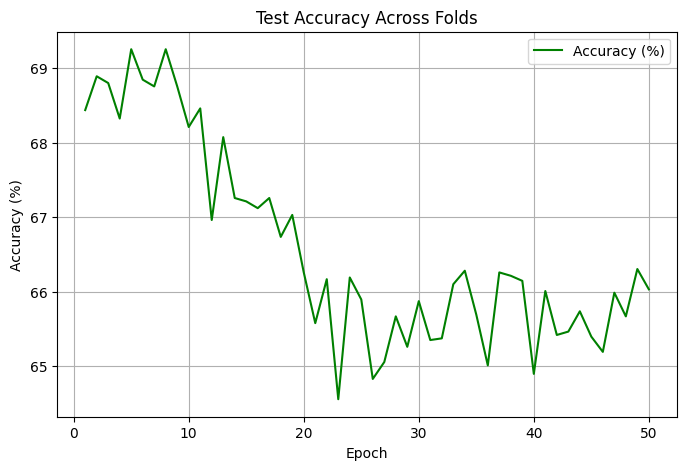

In [ ]:
PATCH_SIZE = 32
train_5fold_cross_validation(TemporalTransformer, learning_rate=1e-3, feature_method='csp', subject_data= subject_data_preload)

In [ ]:
PATCH_SIZE = 32
train_5fold_cross_validation(TemporalTransformer, learning_rate=1e-4, feature_method='csp', subject_data= subject_data_preload)


Fold 1/5
Fitting CSP incrementally on per-subject data (memory safe)...
Epoch 1/50, Loss: 72.3574, Test Acc: 0.6667
Epoch 2/50, Loss: 66.6439, Test Acc: 0.6406
Epoch 3/50, Loss: 65.2548, Test Acc: 0.6837
Epoch 4/50, Loss: 63.8059, Test Acc: 0.6859
Epoch 5/50, Loss: 62.3341, Test Acc: 0.6621
Epoch 6/50, Loss: 61.9845, Test Acc: 0.6837
Epoch 7/50, Loss: 59.2117, Test Acc: 0.6621
Epoch 8/50, Loss: 57.8150, Test Acc: 0.6803
Epoch 9/50, Loss: 56.1285, Test Acc: 0.6814
Epoch 10/50, Loss: 55.1020, Test Acc: 0.7041
Epoch 11/50, Loss: 52.4579, Test Acc: 0.6871
Epoch 12/50, Loss: 50.1283, Test Acc: 0.6791
Epoch 13/50, Loss: 47.4817, Test Acc: 0.6825
Epoch 14/50, Loss: 46.0691, Test Acc: 0.6780
Epoch 15/50, Loss: 41.7227, Test Acc: 0.6655
Epoch 16/50, Loss: 38.0810, Test Acc: 0.6474
Epoch 17/50, Loss: 33.0783, Test Acc: 0.6451
Epoch 18/50, Loss: 29.4051, Test Acc: 0.6429
Epoch 19/50, Loss: 27.9687, Test Acc: 0.6474
Epoch 20/50, Loss: 23.5541, Test Acc: 0.6633
Epoch 21/50, Loss: 19.5136, Test Acc

In [ ]:
#ended here last time

Precomputing wavelet features for all subjects...
[DEBUG] S001: X_feat shape = (42, 64, 4, 489)
[DEBUG] S002: X_feat shape = (42, 64, 4, 489)
[DEBUG] S003: X_feat shape = (42, 64, 4, 489)
[DEBUG] S004: X_feat shape = (42, 64, 4, 489)
[DEBUG] S005: X_feat shape = (42, 64, 4, 489)
[DEBUG] S006: X_feat shape = (42, 64, 4, 489)
[DEBUG] S007: X_feat shape = (42, 64, 4, 489)
[DEBUG] S008: X_feat shape = (42, 64, 4, 489)
[DEBUG] S009: X_feat shape = (42, 64, 4, 489)
[DEBUG] S010: X_feat shape = (42, 64, 4, 489)
[DEBUG] S011: X_feat shape = (42, 64, 4, 489)
[DEBUG] S012: X_feat shape = (42, 64, 4, 489)
[DEBUG] S013: X_feat shape = (42, 64, 4, 489)
[DEBUG] S014: X_feat shape = (42, 64, 4, 489)
[DEBUG] S015: X_feat shape = (42, 64, 4, 489)
[DEBUG] S016: X_feat shape = (42, 64, 4, 489)
[DEBUG] S017: X_feat shape = (42, 64, 4, 489)
[DEBUG] S018: X_feat shape = (42, 64, 4, 489)
[DEBUG] S019: X_feat shape = (42, 64, 4, 489)
[DEBUG] S020: X_feat shape = (42, 64, 4, 489)
[DEBUG] S021: X_feat shape = (

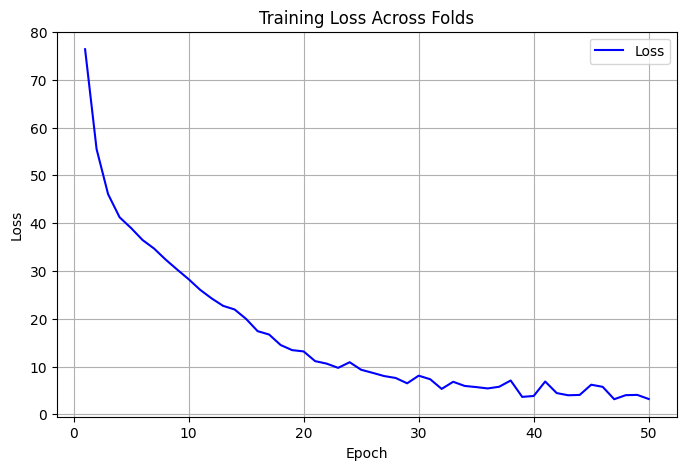

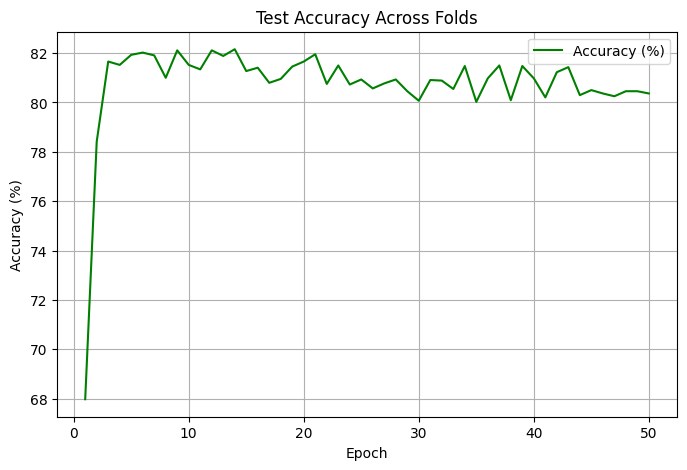

In [ ]:
train_5fold_cross_validation(TemporalTransformer, learning_rate=1e-4, feature_method='wavelet', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 961)
Epoch 1/50, Loss: 78.4524, Test Acc: 0.5000
Epoch 2/50, Loss: 76.3068, Test Acc: 0.5102
Epoch 3/50, Loss: 73.9673, Test Acc: 0.5624
Epoch 4/50, Loss: 73.7421, Test Acc: 0.5612
Epoch 5/50, Loss: 72.1578, Test Acc: 0.5703
Epoch 6/50, Loss: 71.4118, Test Acc: 0.5714
Epoch 7/50, Loss: 70.2009, Test Acc: 0.5771
Epoch 8/50, Loss: 69.6551, Test Acc: 0.5669
Epoch 9/50, Loss: 68.1349, Test Acc: 0.6054
Epoch 10/50, Loss: 68.8073, Test Acc: 0.5884
Epoch 11/50, Loss: 67.9501, Test Acc: 0.5839
Epoch 12/50, Loss: 66.6385, Test Acc: 0.5907
Epoch 13/50, Loss: 66.9416, Test Acc: 0.6202
Epoch 14/50, Loss: 66.5358, Test Acc: 0.6088
Epoch 15/50, Loss: 64.8436, Test Acc: 0.6100
Epoch 16/50, Loss: 65.3304, Test Acc: 0.6054
Epoch 17/50, Loss: 63.8967, Test Acc: 0.6202
Epoch 18/50, Loss: 63.0214, Test Acc: 0.6156
Epoch 19/50, Loss: 62.2477, Test Acc: 0.6293
Epoch 20/50, Loss: 60.7850, Test Acc: 0.6451
Epoch 21/50, Loss: 60.0137, Test Acc: 0.6247
Epoch 22/50, L

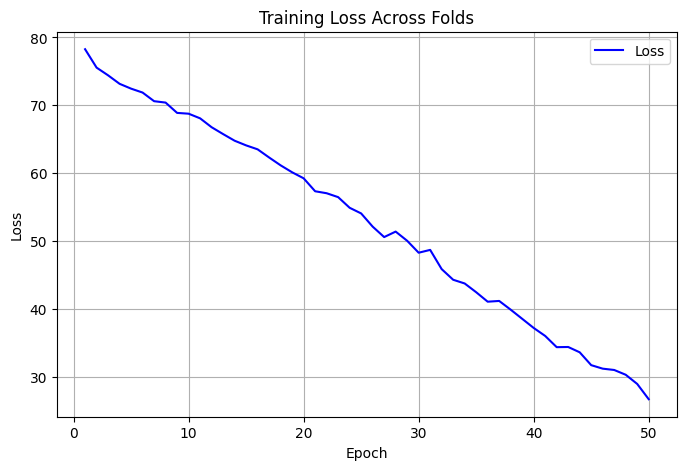

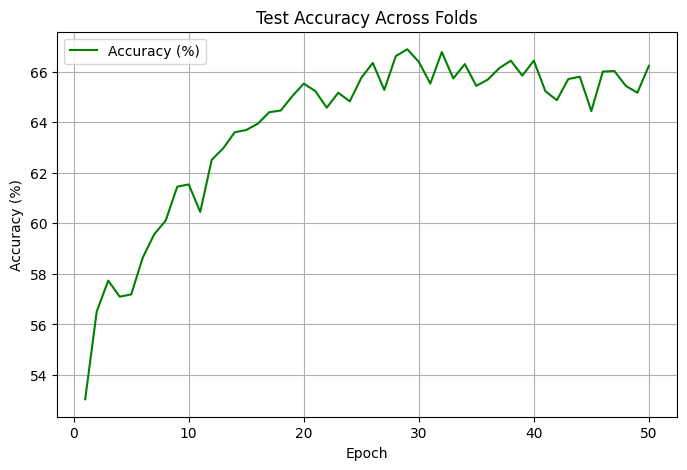

In [ ]:
train_5fold_cross_validation(TemporalTransformer, learning_rate=1e-4, feature_method='stft', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 481)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1027.)
  return F.conv2d(


Epoch 1/50, Loss: 78.1798, Test Acc: 0.5635
Epoch 2/50, Loss: 75.5915, Test Acc: 0.5998
Epoch 3/50, Loss: 72.1646, Test Acc: 0.6122
Epoch 4/50, Loss: 63.5910, Test Acc: 0.6995
Epoch 5/50, Loss: 58.4142, Test Acc: 0.7302
Epoch 6/50, Loss: 55.7994, Test Acc: 0.7132
Epoch 7/50, Loss: 53.9983, Test Acc: 0.7188
Epoch 8/50, Loss: 52.4414, Test Acc: 0.6780
Epoch 9/50, Loss: 51.5400, Test Acc: 0.7268
Epoch 10/50, Loss: 49.7572, Test Acc: 0.7120
Epoch 11/50, Loss: 49.5333, Test Acc: 0.7336
Epoch 12/50, Loss: 47.5821, Test Acc: 0.7313
Epoch 13/50, Loss: 46.1846, Test Acc: 0.7177
Epoch 14/50, Loss: 45.1427, Test Acc: 0.7166
Epoch 15/50, Loss: 44.7955, Test Acc: 0.7166
Epoch 16/50, Loss: 42.5616, Test Acc: 0.7007
Epoch 17/50, Loss: 42.4122, Test Acc: 0.7052
Epoch 18/50, Loss: 40.9919, Test Acc: 0.7154
Epoch 19/50, Loss: 38.3208, Test Acc: 0.7166
Epoch 20/50, Loss: 38.1649, Test Acc: 0.7188
Epoch 21/50, Loss: 35.6662, Test Acc: 0.7188
Epoch 22/50, Loss: 33.9818, Test Acc: 0.7029
Epoch 23/50, Loss: 

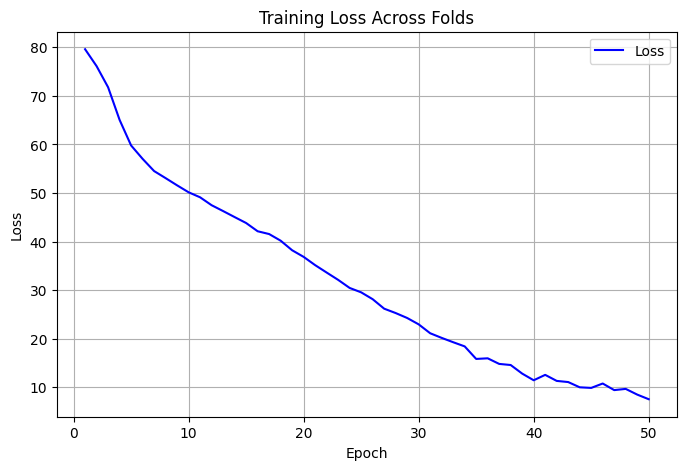

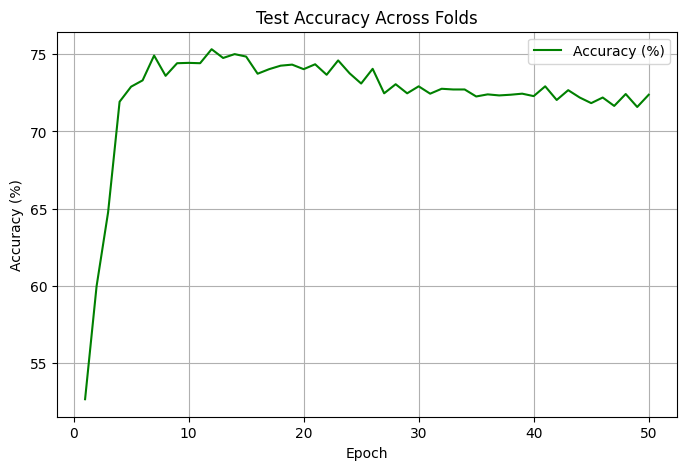

In [ ]:
train_5fold_cross_validation(FusionCNNTransformer, learning_rate=1e-3, feature_method='raw', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 961)
Epoch 1/50, Loss: 81.7902, Test Acc: 0.5000
Epoch 2/50, Loss: 75.5106, Test Acc: 0.5420
Epoch 3/50, Loss: 67.4432, Test Acc: 0.6678
Epoch 4/50, Loss: 62.8015, Test Acc: 0.7063
Epoch 5/50, Loss: 55.1019, Test Acc: 0.7426
Epoch 6/50, Loss: 52.7110, Test Acc: 0.7460
Epoch 7/50, Loss: 48.6068, Test Acc: 0.7710
Epoch 8/50, Loss: 44.8919, Test Acc: 0.7721
Epoch 9/50, Loss: 41.2686, Test Acc: 0.7846
Epoch 10/50, Loss: 38.6707, Test Acc: 0.7868
Epoch 11/50, Loss: 36.9362, Test Acc: 0.7846
Epoch 12/50, Loss: 35.0020, Test Acc: 0.7925
Epoch 13/50, Loss: 31.7539, Test Acc: 0.7993
Epoch 14/50, Loss: 29.5908, Test Acc: 0.7857
Epoch 15/50, Loss: 25.3768, Test Acc: 0.7789
Epoch 16/50, Loss: 24.1554, Test Acc: 0.7902
Epoch 17/50, Loss: 21.1869, Test Acc: 0.7800
Epoch 18/50, Loss: 21.1433, Test Acc: 0.7823
Epoch 19/50, Loss: 15.9391, Test Acc: 0.7834
Epoch 20/50, Loss: 15.0489, Test Acc: 0.7880
Epoch 21/50, Loss: 14.2402, Test Acc: 0.7630
Epoch 22/50, L

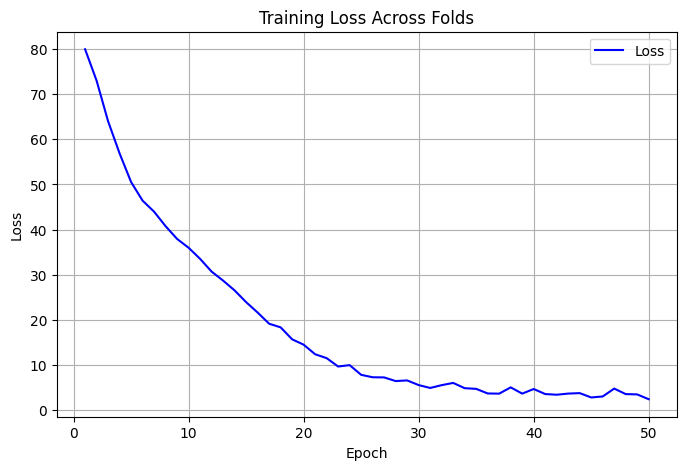

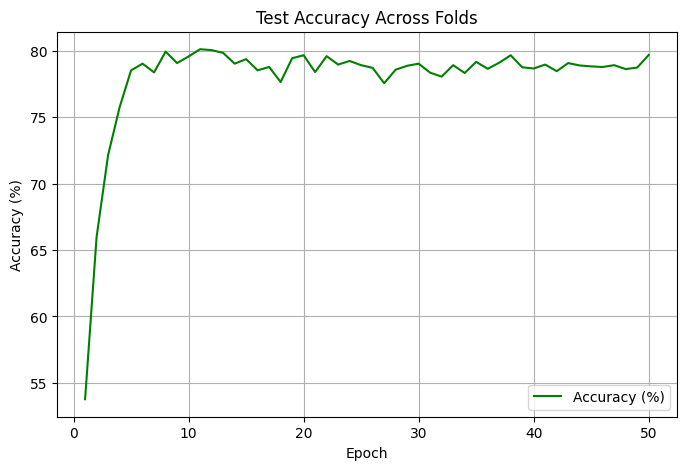

In [ ]:
train_5fold_cross_validation(FusionCNNTransformer, learning_rate=1e-4, feature_method='stft', subject_data= subject_data_preload)

In [ ]:
train_5fold_cross_validation(FusionCNNTransformer, learning_rate=7e-4, feature_method='stft', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 961)
Epoch 1/50, Loss: 84.7209, Test Acc: 0.5000
Epoch 2/50, Loss: 75.8566, Test Acc: 0.6190
Epoch 3/50, Loss: 67.5121, Test Acc: 0.7029
Epoch 4/50, Loss: 58.0134, Test Acc: 0.7324
Epoch 5/50, Loss: 52.1488, Test Acc: 0.7608
Epoch 6/50, Loss: 48.1735, Test Acc: 0.7619
Epoch 7/50, Loss: 44.8686, Test Acc: 0.7755
Epoch 8/50, Loss: 41.4994, Test Acc: 0.7744
Epoch 9/50, Loss: 40.0653, Test Acc: 0.7891
Epoch 10/50, Loss: 36.9000, Test Acc: 0.7642
Epoch 11/50, Loss: 36.2886, Test Acc: 0.7642
Epoch 12/50, Loss: 32.9386, Test Acc: 0.7336
Epoch 13/50, Loss: 30.5431, Test Acc: 0.7653
Epoch 14/50, Loss: 29.8097, Test Acc: 0.7857
Epoch 15/50, Loss: 26.4158, Test Acc: 0.7823
Epoch 16/50, Loss: 23.7447, Test Acc: 0.7744
Epoch 17/50, Loss: 21.1548, Test Acc: 0.7664
Epoch 18/50, Loss: 19.5563, Test Acc: 0.7608
Epoch 19/50, Loss: 18.7414, Test Acc: 0.7653
Epoch 20/50, Loss: 18.1602, Test Acc: 0.7642
Epoch 21/50, Loss: 14.9050, Test Acc: 0.7506
Epoch 22/50, L


Fold 1/5
[DEBUG] Input to model: (3528, 64, 961)
Epoch 1/50, Loss: 80.9623, Test Acc: 0.5476
Epoch 2/50, Loss: 72.5884, Test Acc: 0.6440
Epoch 3/50, Loss: 59.9605, Test Acc: 0.7630
Epoch 4/50, Loss: 51.1417, Test Acc: 0.7698
Epoch 5/50, Loss: 45.9728, Test Acc: 0.7834
Epoch 6/50, Loss: 42.0424, Test Acc: 0.7971
Epoch 7/50, Loss: 38.6162, Test Acc: 0.7676
Epoch 8/50, Loss: 37.2941, Test Acc: 0.8039
Epoch 9/50, Loss: 34.1797, Test Acc: 0.7744
Epoch 10/50, Loss: 31.7328, Test Acc: 0.7766
Epoch 11/50, Loss: 27.9153, Test Acc: 0.7642
Epoch 12/50, Loss: 26.6484, Test Acc: 0.7948
Epoch 13/50, Loss: 23.7901, Test Acc: 0.7653
Epoch 14/50, Loss: 20.1254, Test Acc: 0.7823
Epoch 15/50, Loss: 19.5319, Test Acc: 0.7721
Epoch 16/50, Loss: 15.2569, Test Acc: 0.7823
Epoch 17/50, Loss: 12.4365, Test Acc: 0.7676
Epoch 18/50, Loss: 12.6541, Test Acc: 0.7744
Epoch 19/50, Loss: 10.9833, Test Acc: 0.7596
Epoch 20/50, Loss: 12.7410, Test Acc: 0.7574
Epoch 21/50, Loss: 8.3748, Test Acc: 0.7721
Epoch 22/50, Lo

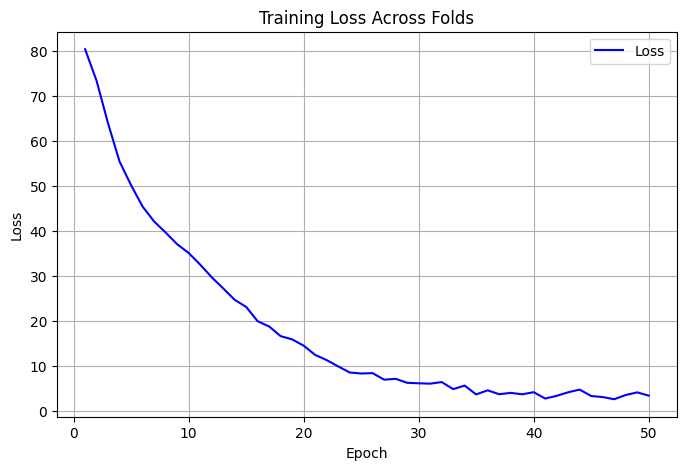

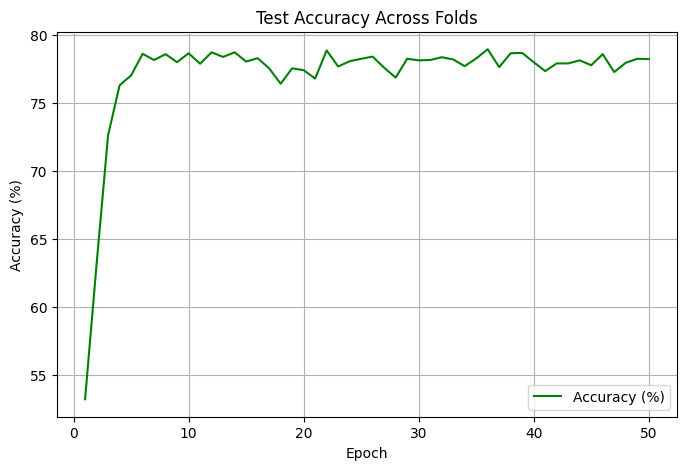

In [ ]:
train_5fold_cross_validation(SpatialCNNTransformer, learning_rate=1e-4, feature_method='stft', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 961)
Epoch 1/50, Loss: 81.3020, Test Acc: 0.5726
Epoch 2/50, Loss: 75.9141, Test Acc: 0.6077
Epoch 3/50, Loss: 67.2184, Test Acc: 0.6746
Epoch 4/50, Loss: 59.7803, Test Acc: 0.7540
Epoch 5/50, Loss: 49.5613, Test Acc: 0.7483
Epoch 6/50, Loss: 48.0852, Test Acc: 0.7857
Epoch 7/50, Loss: 42.4757, Test Acc: 0.7755
Epoch 8/50, Loss: 41.7065, Test Acc: 0.7755
Epoch 9/50, Loss: 37.2197, Test Acc: 0.7823
Epoch 10/50, Loss: 34.4052, Test Acc: 0.7812
Epoch 11/50, Loss: 31.9871, Test Acc: 0.7812
Epoch 12/50, Loss: 30.2372, Test Acc: 0.7902
Epoch 13/50, Loss: 29.3173, Test Acc: 0.7948
Epoch 14/50, Loss: 25.3502, Test Acc: 0.7642
Epoch 15/50, Loss: 21.8635, Test Acc: 0.7596
Epoch 16/50, Loss: 21.3495, Test Acc: 0.7971
Epoch 17/50, Loss: 18.7502, Test Acc: 0.7925
Epoch 18/50, Loss: 15.6815, Test Acc: 0.7812
Epoch 19/50, Loss: 14.2848, Test Acc: 0.7721
Epoch 20/50, Loss: 13.1865, Test Acc: 0.7721
Epoch 21/50, Loss: 13.7039, Test Acc: 0.7902
Epoch 22/50, L

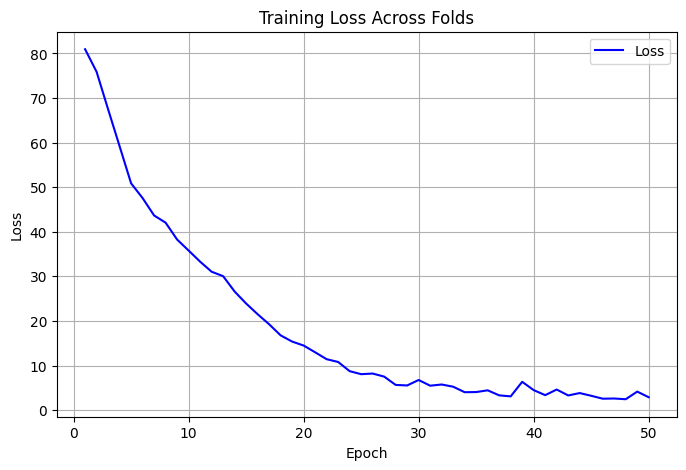

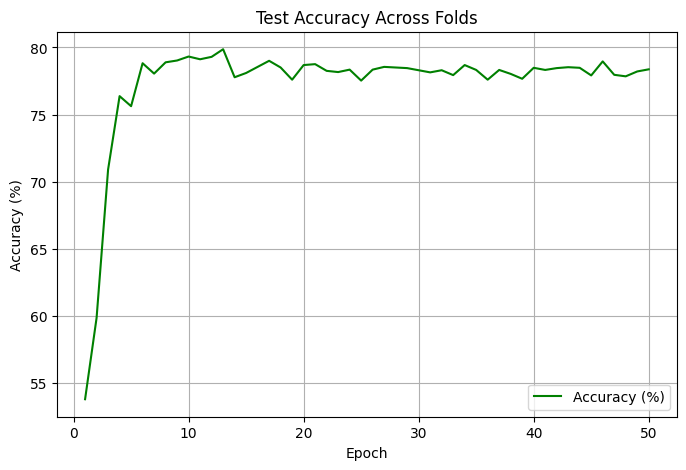

In [ ]:
train_5fold_cross_validation(SpatialCNNTransformer, learning_rate=7e-4, feature_method='stft', subject_data= subject_data_preload)

In [ ]:
# 3s segment for wavelet packet

Precomputing wavelet_packet features for all subjects...
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 

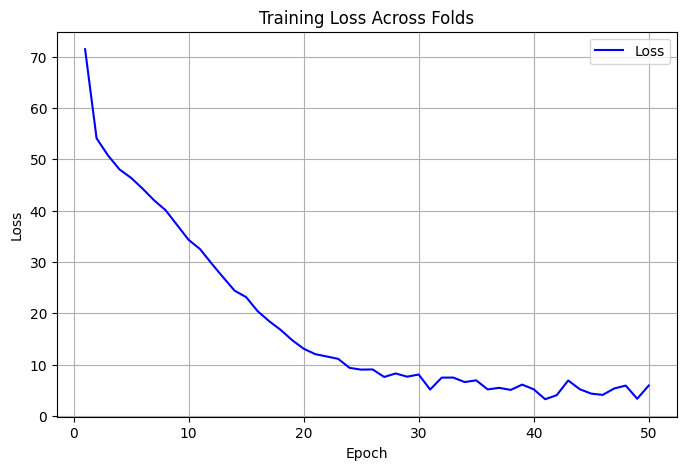

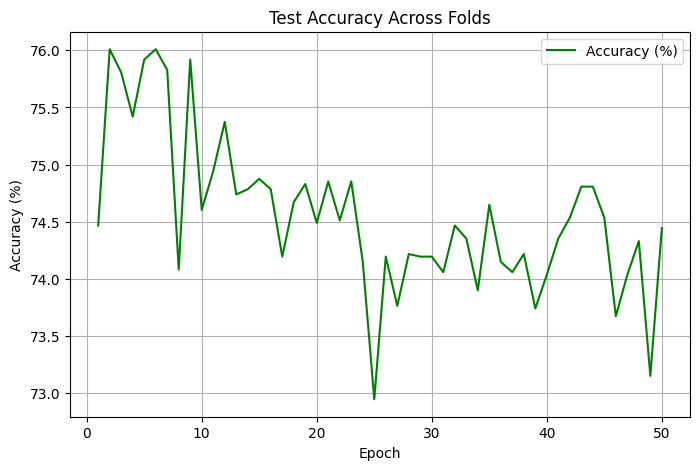

In [ ]:
train_5fold_cross_validation(TemporalTransformer, learning_rate=1e-4, feature_method='wavelet_packet', subject_data= subject_data_preload)

Precomputing wavelet_packet features for all subjects...
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 

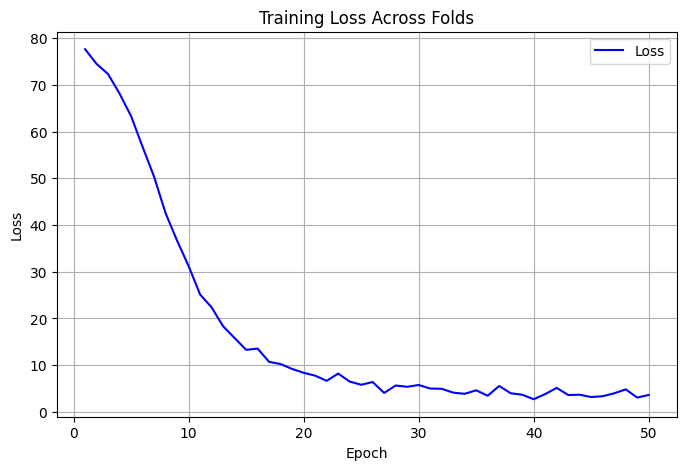

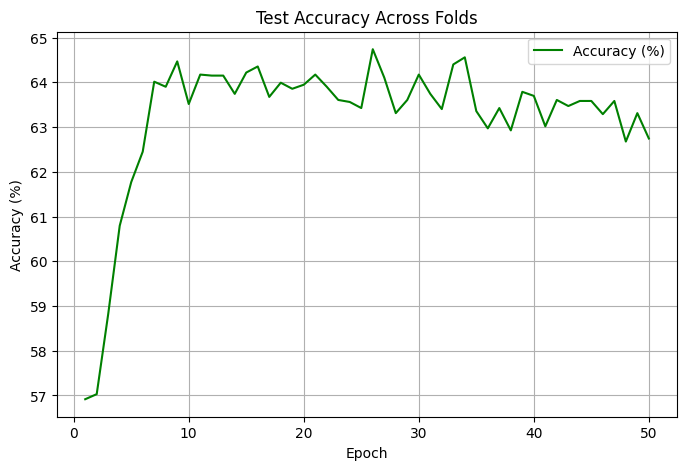

In [ ]:
train_5fold_cross_validation(SpatialTransformer, learning_rate=1e-3, feature_method='wavelet_packet', subject_data= subject_data_preload)

Precomputing wavelet_packet features for all subjects...
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 

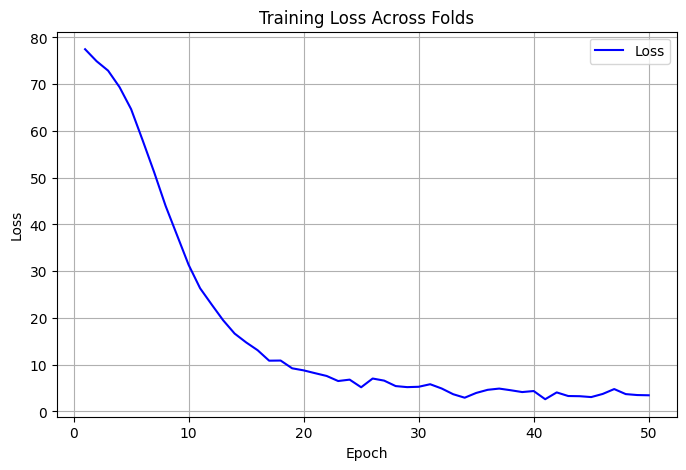

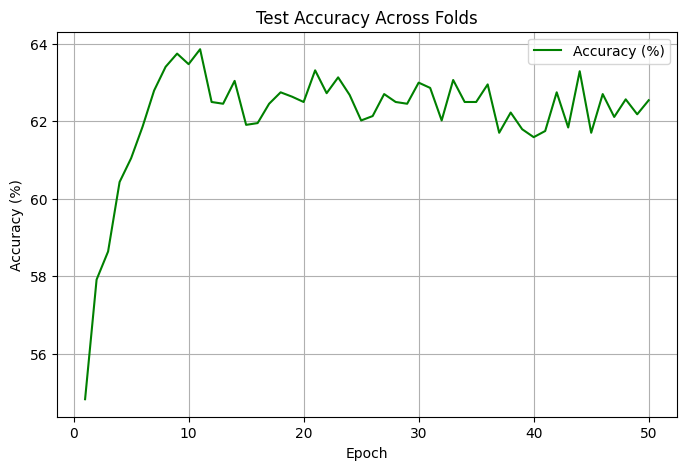

In [ ]:
train_5fold_cross_validation(SpatialTransformer, learning_rate=1e-3, feature_method='wavelet_packet', subject_data= subject_data_preload)

In [ ]:
#------------------------------------------------------------------------------end of 3s


Fold 1/5
[DEBUG] Input to model: (3528, 64, 961)
Epoch 1/50, Loss: 75.1695, Test Acc: 0.5941
Epoch 2/50, Loss: 71.7766, Test Acc: 0.6088
Epoch 3/50, Loss: 68.7417, Test Acc: 0.6281
Epoch 4/50, Loss: 63.9596, Test Acc: 0.6440
Epoch 5/50, Loss: 59.9180, Test Acc: 0.6338
Epoch 6/50, Loss: 52.7638, Test Acc: 0.5952
Epoch 7/50, Loss: 46.6937, Test Acc: 0.6519
Epoch 8/50, Loss: 40.9715, Test Acc: 0.6213
Epoch 9/50, Loss: 37.2784, Test Acc: 0.6531
Epoch 10/50, Loss: 32.8997, Test Acc: 0.6508
Epoch 11/50, Loss: 28.0187, Test Acc: 0.6009
Epoch 12/50, Loss: 25.8189, Test Acc: 0.6395
Epoch 13/50, Loss: 22.2973, Test Acc: 0.6497
Epoch 14/50, Loss: 18.6166, Test Acc: 0.6417
Epoch 15/50, Loss: 15.6792, Test Acc: 0.6429
Epoch 16/50, Loss: 16.8273, Test Acc: 0.6440
Epoch 17/50, Loss: 12.7752, Test Acc: 0.6655
Epoch 18/50, Loss: 12.6862, Test Acc: 0.6395
Epoch 19/50, Loss: 11.1299, Test Acc: 0.6349
Epoch 20/50, Loss: 11.7373, Test Acc: 0.6519
Epoch 21/50, Loss: 11.6314, Test Acc: 0.6633
Epoch 22/50, L

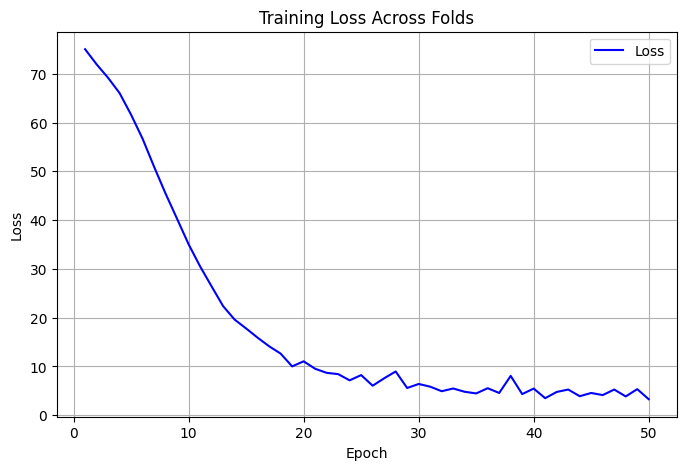

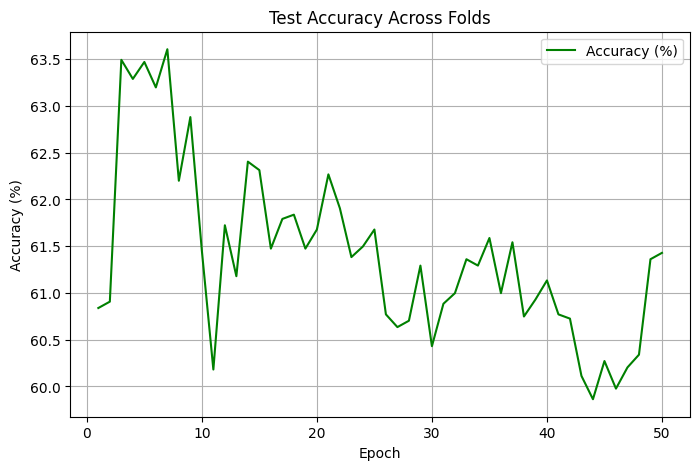

In [ ]:
train_5fold_cross_validation(SpatialTransformer, learning_rate=1e-4, feature_method='raw', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 961)
Epoch 1/50, Loss: 74.2999, Test Acc: 0.6281
Epoch 2/50, Loss: 70.7040, Test Acc: 0.6213
Epoch 3/50, Loss: 68.1561, Test Acc: 0.6156
Epoch 4/50, Loss: 65.4384, Test Acc: 0.5918
Epoch 5/50, Loss: 59.2324, Test Acc: 0.6088
Epoch 6/50, Loss: 54.5134, Test Acc: 0.6202
Epoch 7/50, Loss: 48.7905, Test Acc: 0.6134
Epoch 8/50, Loss: 44.4904, Test Acc: 0.6315
Epoch 9/50, Loss: 38.4747, Test Acc: 0.6156
Epoch 10/50, Loss: 33.7070, Test Acc: 0.6293
Epoch 11/50, Loss: 28.1959, Test Acc: 0.6236
Epoch 12/50, Loss: 24.4928, Test Acc: 0.6077
Epoch 13/50, Loss: 21.2881, Test Acc: 0.6224
Epoch 14/50, Loss: 23.1067, Test Acc: 0.6270
Epoch 15/50, Loss: 16.0366, Test Acc: 0.6088
Epoch 16/50, Loss: 16.7378, Test Acc: 0.6202
Epoch 17/50, Loss: 17.8480, Test Acc: 0.6134
Epoch 18/50, Loss: 12.5237, Test Acc: 0.6066
Epoch 19/50, Loss: 8.4309, Test Acc: 0.6009
Epoch 20/50, Loss: 11.6060, Test Acc: 0.6088
Epoch 21/50, Loss: 9.2507, Test Acc: 0.5998
Epoch 22/50, Los

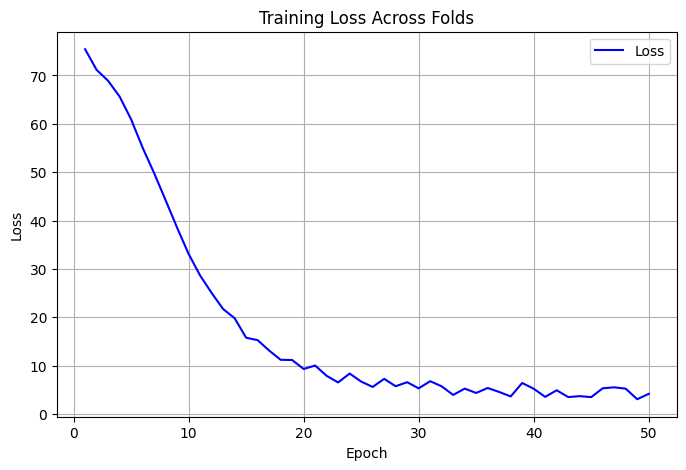

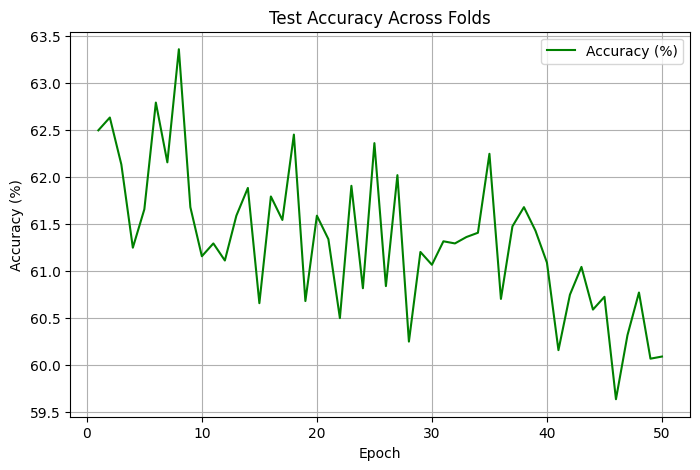

In [ ]:
train_5fold_cross_validation(SpatialTransformer, learning_rate=7e-4, feature_method='raw', subject_data= subject_data_preload)


Fold 1/5
Fitting CSP incrementally on per-subject data (memory safe)...
Epoch 1/50, Loss: 77.4497, Test Acc: 0.5907
Epoch 2/50, Loss: 66.9087, Test Acc: 0.6882
Epoch 3/50, Loss: 61.4485, Test Acc: 0.7007
Epoch 4/50, Loss: 59.7024, Test Acc: 0.6712
Epoch 5/50, Loss: 58.0026, Test Acc: 0.6769
Epoch 6/50, Loss: 55.3096, Test Acc: 0.6655
Epoch 7/50, Loss: 54.5874, Test Acc: 0.6769
Epoch 8/50, Loss: 52.1896, Test Acc: 0.6735
Epoch 9/50, Loss: 51.2119, Test Acc: 0.6871
Epoch 10/50, Loss: 47.9805, Test Acc: 0.6644
Epoch 11/50, Loss: 46.2467, Test Acc: 0.6746
Epoch 12/50, Loss: 42.6764, Test Acc: 0.6689
Epoch 13/50, Loss: 40.4835, Test Acc: 0.6837
Epoch 14/50, Loss: 37.1053, Test Acc: 0.6599
Epoch 15/50, Loss: 35.1763, Test Acc: 0.6712
Epoch 16/50, Loss: 31.6651, Test Acc: 0.6553
Epoch 17/50, Loss: 29.9221, Test Acc: 0.6621
Epoch 18/50, Loss: 24.7605, Test Acc: 0.6621
Epoch 19/50, Loss: 23.2902, Test Acc: 0.6587
Epoch 20/50, Loss: 21.8790, Test Acc: 0.6542
Epoch 21/50, Loss: 17.4766, Test Acc

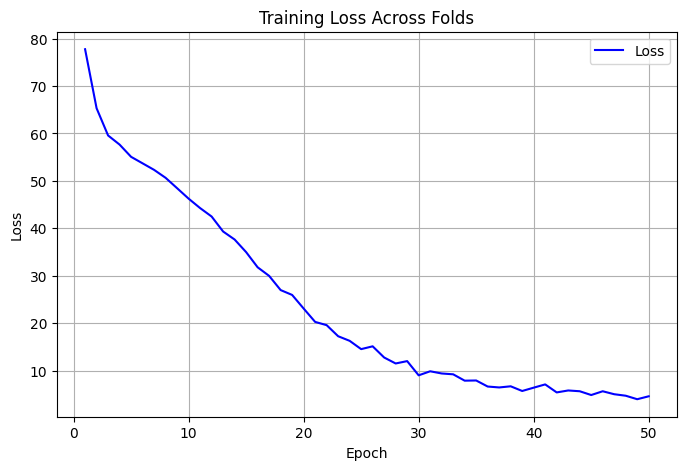

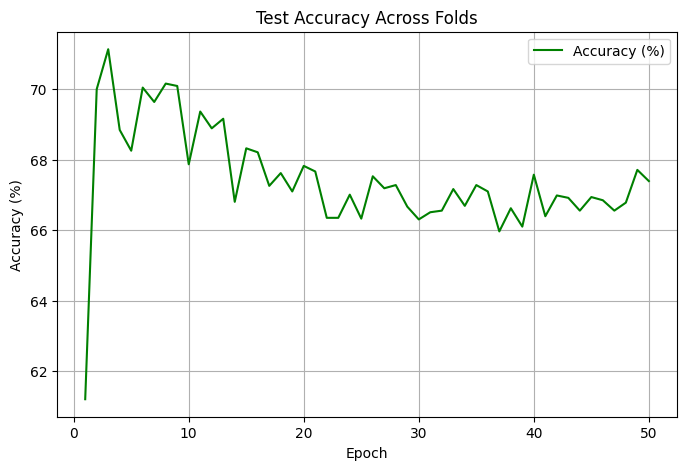

In [ ]:
train_5fold_cross_validation(SpatialTransformer, learning_rate=1e-3, feature_method='csp', subject_data= subject_data_preload)


Fold 1/5
Fitting CSP incrementally on per-subject data (memory safe)...
Epoch 1/50, Loss: 76.4056, Test Acc: 0.6837
Epoch 2/50, Loss: 68.3560, Test Acc: 0.6927
Epoch 3/50, Loss: 63.9825, Test Acc: 0.6610
Epoch 4/50, Loss: 62.8497, Test Acc: 0.6973
Epoch 5/50, Loss: 61.0923, Test Acc: 0.6961
Epoch 6/50, Loss: 59.8363, Test Acc: 0.7086
Epoch 7/50, Loss: 58.0687, Test Acc: 0.7052
Epoch 8/50, Loss: 56.1818, Test Acc: 0.6950
Epoch 9/50, Loss: 54.1359, Test Acc: 0.6791
Epoch 10/50, Loss: 51.9846, Test Acc: 0.6803
Epoch 11/50, Loss: 51.1169, Test Acc: 0.7075
Epoch 12/50, Loss: 47.6346, Test Acc: 0.6859
Epoch 13/50, Loss: 43.7139, Test Acc: 0.6723
Epoch 14/50, Loss: 40.1606, Test Acc: 0.6667
Epoch 15/50, Loss: 39.9804, Test Acc: 0.6508
Epoch 16/50, Loss: 35.3890, Test Acc: 0.6610
Epoch 17/50, Loss: 32.2290, Test Acc: 0.6655
Epoch 18/50, Loss: 27.3802, Test Acc: 0.6519
Epoch 19/50, Loss: 24.2274, Test Acc: 0.6599
Epoch 20/50, Loss: 20.7675, Test Acc: 0.6531
Epoch 21/50, Loss: 22.6153, Test Acc

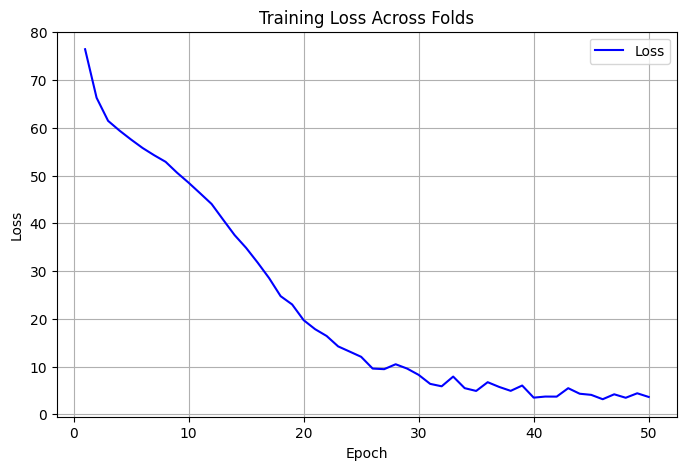

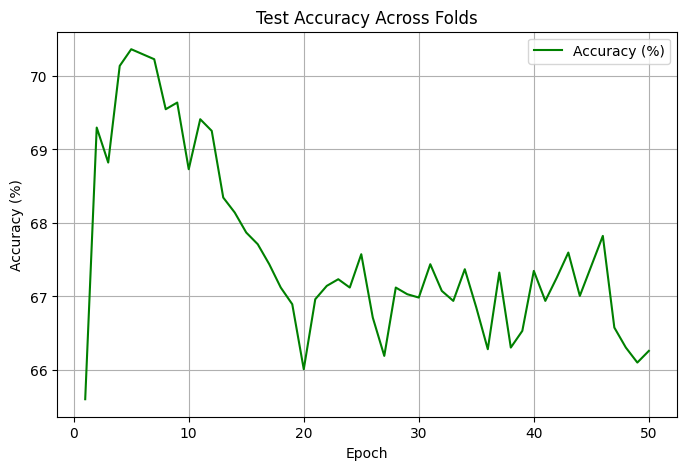

In [ ]:
train_5fold_cross_validation(TemporalTransformer, learning_rate=7e-4, feature_method='csp', subject_data= subject_data_preload)


Fold 1/5
Fitting CSP incrementally on per-subject data (memory safe)...
Epoch 1/50, Loss: 80.3415, Test Acc: 0.5000
Epoch 2/50, Loss: 71.5678, Test Acc: 0.6757
Epoch 3/50, Loss: 65.7178, Test Acc: 0.6803
Epoch 4/50, Loss: 62.4060, Test Acc: 0.6689
Epoch 5/50, Loss: 60.9209, Test Acc: 0.6667
Epoch 6/50, Loss: 59.2160, Test Acc: 0.6780
Epoch 7/50, Loss: 55.6479, Test Acc: 0.6723
Epoch 8/50, Loss: 52.9030, Test Acc: 0.6712
Epoch 9/50, Loss: 50.9468, Test Acc: 0.6757
Epoch 10/50, Loss: 48.3573, Test Acc: 0.6474
Epoch 11/50, Loss: 45.4127, Test Acc: 0.6497
Epoch 12/50, Loss: 41.4660, Test Acc: 0.6395
Epoch 13/50, Loss: 38.2776, Test Acc: 0.6644
Epoch 14/50, Loss: 34.8528, Test Acc: 0.6406
Epoch 15/50, Loss: 31.3410, Test Acc: 0.6621
Epoch 16/50, Loss: 28.8673, Test Acc: 0.6372
Epoch 17/50, Loss: 26.4547, Test Acc: 0.6440
Epoch 18/50, Loss: 22.8883, Test Acc: 0.6168
Epoch 19/50, Loss: 21.9175, Test Acc: 0.6542
Epoch 20/50, Loss: 20.0264, Test Acc: 0.6247
Epoch 21/50, Loss: 18.0653, Test Acc

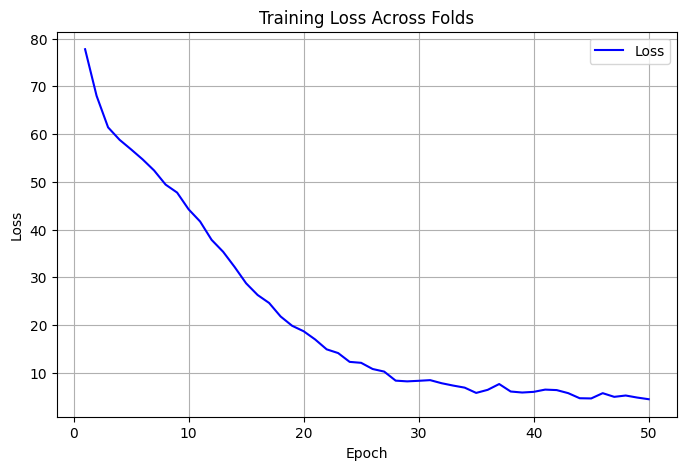

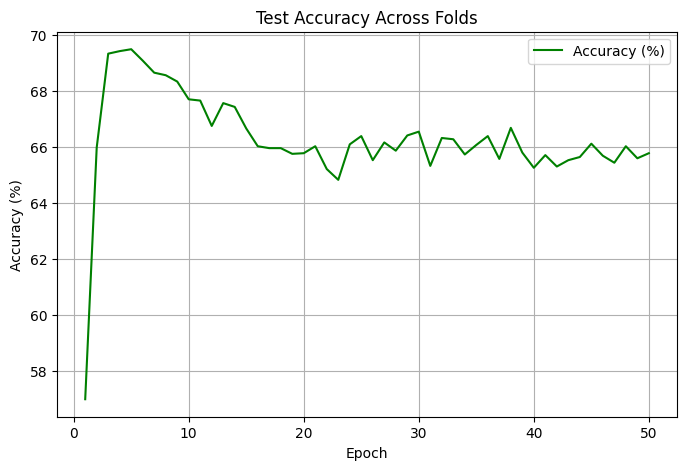

In [ ]:
train_5fold_cross_validation(FusionCNNTransformer, learning_rate=1e-4, feature_method='csp', subject_data= subject_data_preload)


Fold 1/5
Fitting CSP incrementally on per-subject data (memory safe)...
Epoch 1/50, Loss: 80.0089, Test Acc: 0.6100
Epoch 2/50, Loss: 68.4686, Test Acc: 0.6746
Epoch 3/50, Loss: 63.6808, Test Acc: 0.6848
Epoch 4/50, Loss: 61.3834, Test Acc: 0.6746
Epoch 5/50, Loss: 58.4699, Test Acc: 0.6814
Epoch 6/50, Loss: 55.9550, Test Acc: 0.6837
Epoch 7/50, Loss: 53.4307, Test Acc: 0.6644
Epoch 8/50, Loss: 49.8982, Test Acc: 0.6383
Epoch 9/50, Loss: 44.6656, Test Acc: 0.6417
Epoch 10/50, Loss: 42.3663, Test Acc: 0.6542
Epoch 11/50, Loss: 37.7682, Test Acc: 0.6349
Epoch 12/50, Loss: 35.6591, Test Acc: 0.6349
Epoch 13/50, Loss: 30.5191, Test Acc: 0.6349
Epoch 14/50, Loss: 27.0915, Test Acc: 0.6270
Epoch 15/50, Loss: 25.1161, Test Acc: 0.6281
Epoch 16/50, Loss: 19.9934, Test Acc: 0.6111
Epoch 17/50, Loss: 16.6082, Test Acc: 0.6202
Epoch 18/50, Loss: 17.9919, Test Acc: 0.6304
Epoch 19/50, Loss: 13.8928, Test Acc: 0.6281
Epoch 20/50, Loss: 11.8301, Test Acc: 0.6145
Epoch 21/50, Loss: 9.2962, Test Acc:

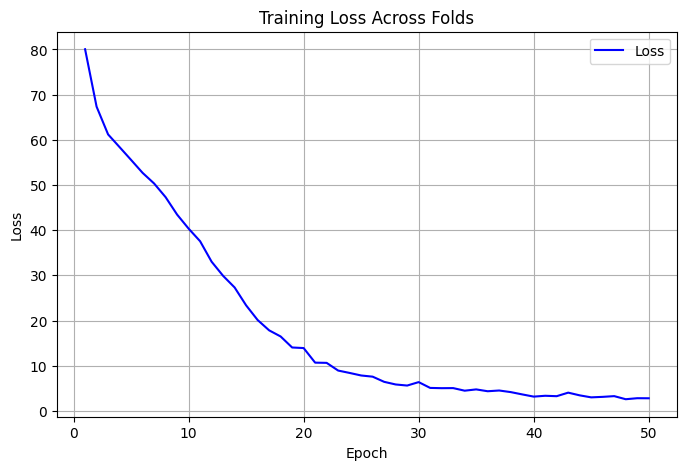

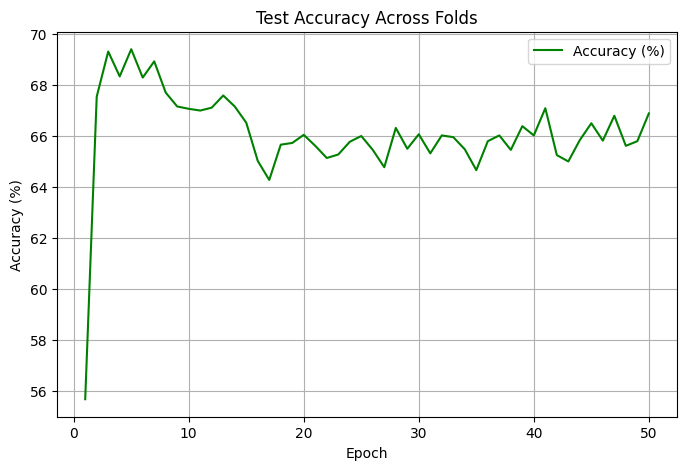

In [ ]:
train_5fold_cross_validation(SpatialCNNTransformer, learning_rate=1e-4, feature_method='csp', subject_data= subject_data_preload)


Fold 1/5
Fitting CSP incrementally on per-subject data (memory safe)...
Epoch 1/50, Loss: 79.5850, Test Acc: 0.5760
Epoch 2/50, Loss: 67.4047, Test Acc: 0.6723
Epoch 3/50, Loss: 61.4049, Test Acc: 0.6769
Epoch 4/50, Loss: 59.6404, Test Acc: 0.6667
Epoch 5/50, Loss: 55.8838, Test Acc: 0.6553
Epoch 6/50, Loss: 53.5233, Test Acc: 0.6587
Epoch 7/50, Loss: 49.5097, Test Acc: 0.6508
Epoch 8/50, Loss: 44.7156, Test Acc: 0.6281
Epoch 9/50, Loss: 40.5029, Test Acc: 0.6451
Epoch 10/50, Loss: 35.7224, Test Acc: 0.6417
Epoch 11/50, Loss: 31.9761, Test Acc: 0.6190
Epoch 12/50, Loss: 26.8874, Test Acc: 0.6565
Epoch 13/50, Loss: 21.1005, Test Acc: 0.6281
Epoch 14/50, Loss: 19.0161, Test Acc: 0.6247
Epoch 15/50, Loss: 17.5251, Test Acc: 0.6168
Epoch 16/50, Loss: 14.2857, Test Acc: 0.6281
Epoch 17/50, Loss: 12.7093, Test Acc: 0.6349
Epoch 18/50, Loss: 11.4947, Test Acc: 0.6247
Epoch 19/50, Loss: 7.5203, Test Acc: 0.6202
Epoch 20/50, Loss: 10.5208, Test Acc: 0.6259
Epoch 21/50, Loss: 6.4959, Test Acc: 

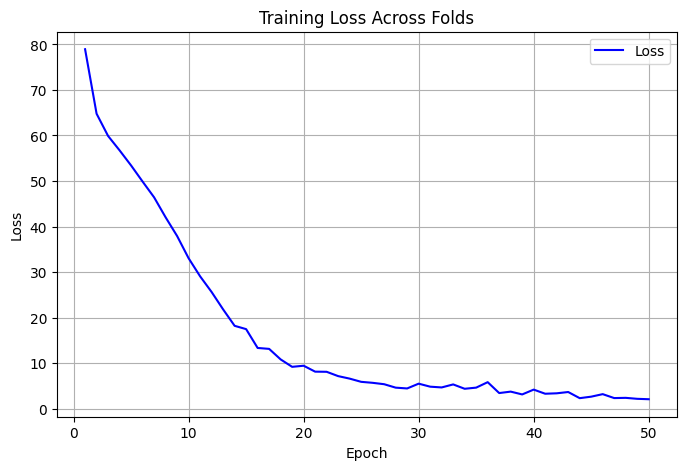

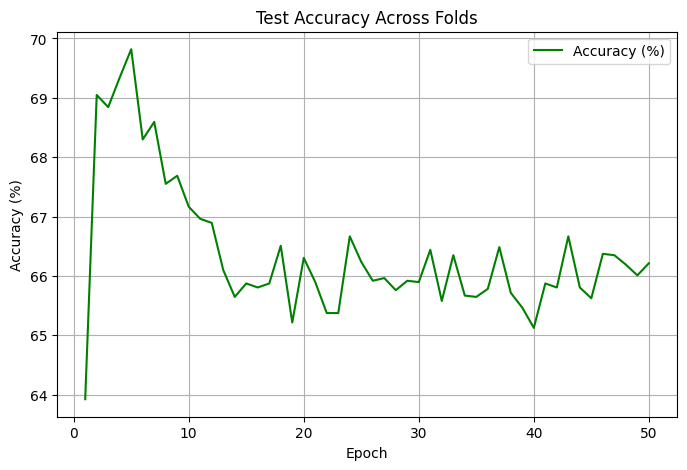

In [ ]:
train_5fold_cross_validation(SpatialCNNTransformer, learning_rate=1e-4, feature_method='csp', subject_data= subject_data_preload)


Fold 1/5
Fitting CSP incrementally on per-subject data (memory safe)...
Epoch 1/50, Loss: 82.0249, Test Acc: 0.5000
Epoch 2/50, Loss: 77.1211, Test Acc: 0.5442
Epoch 3/50, Loss: 68.3373, Test Acc: 0.6859
Epoch 4/50, Loss: 62.4826, Test Acc: 0.6973
Epoch 5/50, Loss: 60.3870, Test Acc: 0.6814
Epoch 6/50, Loss: 57.9083, Test Acc: 0.6791
Epoch 7/50, Loss: 57.4065, Test Acc: 0.6757
Epoch 8/50, Loss: 54.6166, Test Acc: 0.6599
Epoch 9/50, Loss: 52.7619, Test Acc: 0.6689
Epoch 10/50, Loss: 53.3165, Test Acc: 0.6531
Epoch 11/50, Loss: 47.4423, Test Acc: 0.6451
Epoch 12/50, Loss: 44.8817, Test Acc: 0.6474
Epoch 13/50, Loss: 42.1407, Test Acc: 0.6429
Epoch 14/50, Loss: 38.9047, Test Acc: 0.6406
Epoch 15/50, Loss: 36.9085, Test Acc: 0.6213
Epoch 16/50, Loss: 33.0470, Test Acc: 0.6236
Epoch 17/50, Loss: 30.4385, Test Acc: 0.6338
Epoch 18/50, Loss: 27.8326, Test Acc: 0.6236
Epoch 19/50, Loss: 24.7199, Test Acc: 0.6054
Epoch 20/50, Loss: 23.7746, Test Acc: 0.6156
Epoch 21/50, Loss: 19.0788, Test Acc

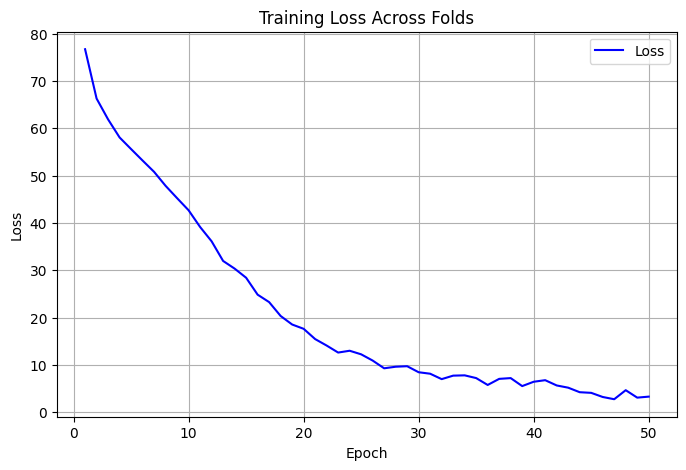

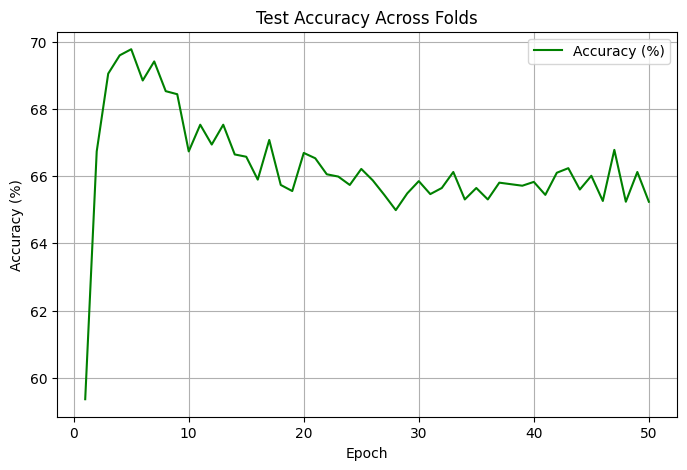

In [ ]:
train_5fold_cross_validation(FusionCNNTransformer, learning_rate=7e-3, feature_method='csp', subject_data= subject_data_preload)

Precomputing wavelet_packet features for all subjects...


/usr/local/lib/python3.12/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(


[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_feat shape: (42, 64, 8, 75)
[DEBUG] X_fe

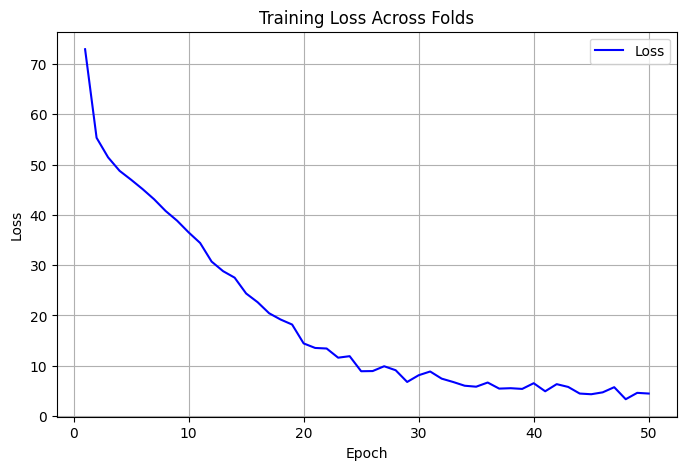

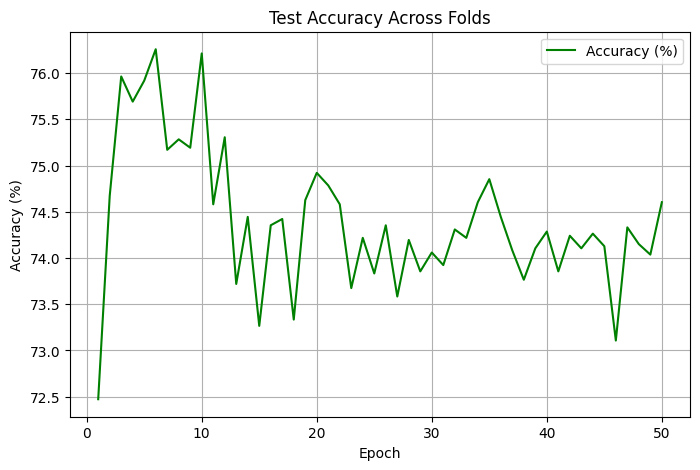

In [ ]:
train_5fold_cross_validation(TemporalTransformer, learning_rate=1e-4, feature_method='wavelet_packet', subject_data= subject_data_preload)

Precomputing wavelet_packet_2 features for all subjects...
[DEBUG] S001: X_feat shape = (42, 64, 8, 6)
[DEBUG] S002: X_feat shape = (42, 64, 8, 6)
[DEBUG] S003: X_feat shape = (42, 64, 8, 6)
[DEBUG] S004: X_feat shape = (42, 64, 8, 6)
[DEBUG] S005: X_feat shape = (42, 64, 8, 6)
[DEBUG] S006: X_feat shape = (42, 64, 8, 6)
[DEBUG] S007: X_feat shape = (42, 64, 8, 6)
[DEBUG] S008: X_feat shape = (42, 64, 8, 6)
[DEBUG] S009: X_feat shape = (42, 64, 8, 6)
[DEBUG] S010: X_feat shape = (42, 64, 8, 6)
[DEBUG] S011: X_feat shape = (42, 64, 8, 6)
[DEBUG] S012: X_feat shape = (42, 64, 8, 6)
[DEBUG] S013: X_feat shape = (42, 64, 8, 6)
[DEBUG] S014: X_feat shape = (42, 64, 8, 6)
[DEBUG] S015: X_feat shape = (42, 64, 8, 6)
[DEBUG] S016: X_feat shape = (42, 64, 8, 6)
[DEBUG] S017: X_feat shape = (42, 64, 8, 6)
[DEBUG] S018: X_feat shape = (42, 64, 8, 6)
[DEBUG] S019: X_feat shape = (42, 64, 8, 6)
[DEBUG] S020: X_feat shape = (42, 64, 8, 6)
[DEBUG] S021: X_feat shape = (42, 64, 8, 6)
[DEBUG] S022: X_f

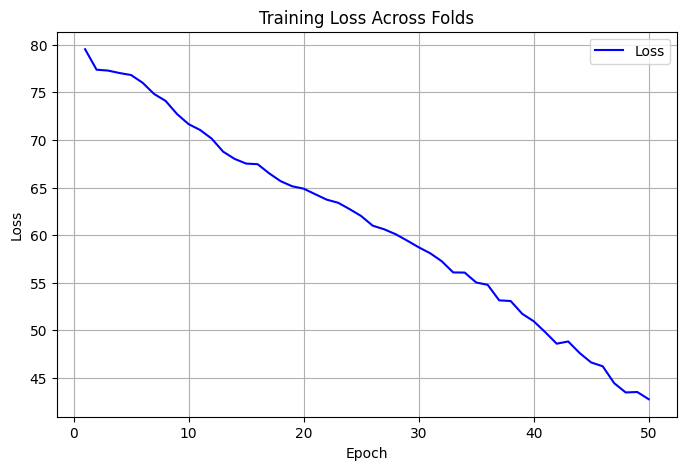

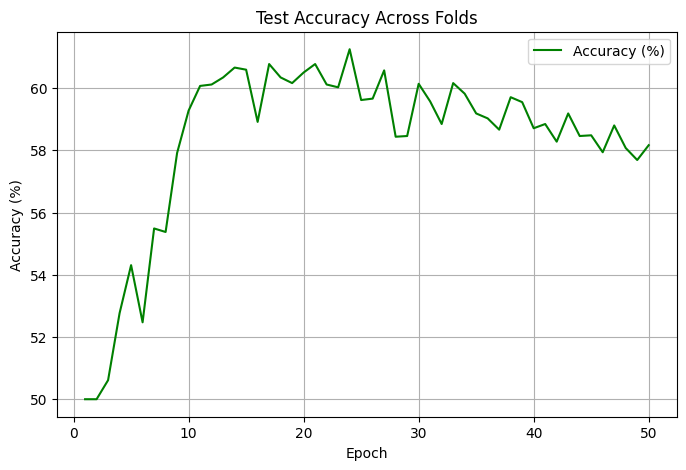

In [ ]:
train_5fold_cross_validation(TemporalTransformer, learning_rate=1e-4, feature_method='wavelet_packet_2', subject_data= subject_data_preload)

In [ ]:
import os
import re
import shutil

# Input/output folders
input_folder = f'/content/drive/My Drive/EEG_Data/Physionet/{SEGMENT_SIZE}s'
output_folder = f'/content/drive/My Drive/EEG_Data/Physionet/separate_results/{SEGMENT_SIZE}s'
os.makedirs(output_folder, exist_ok=True)

# Define feature methods
methods = ['raw', 'cnn', 'csp', 'stft', 'wavelet']

# Create subfolders for each method
for m in methods:
    os.makedirs(os.path.join(output_folder, m), exist_ok=True)

# Regex pattern that matches both types of filenames
# Examples it should catch:
# - fold_cross_subject_accuracies_TemporalCNNTransformer_stft_nfft128_hop32_0.0001.csv
# - test_accuracy_curve_TemporalTransformer_raw_0.0001.csv
# - train_loss_curve_TemporalTransformer_cnn_0.0001.csv
method_pattern = re.compile(r'_(raw|cnn|csp|stft|wavelet|wavelet_packet)(?:[_\.]|$)')

# Collect all CSV files
csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]

# Process each file
for f in csv_files:
    match = method_pattern.search(f)
    if match:
        method = match.group(1)
        src = os.path.join(input_folder, f)
        dst = os.path.join(output_folder, method, f)
        shutil.copy(src, dst)  # copy (safer). Change to shutil.move if you want them relocated.
        print(f"📂 {f} → {method}/")
    else:
        print(f"⚠️ Skipped (no method found): {f}")

print("\n✅ All files grouped into:")
for m in methods:
    print(f"  - {os.path.join(output_folder, m)}")


📂 fold_cross_subject_accuracies_FusionCNNTransformer_raw_0.001.csv → raw/
📂 fold_cross_subject_accuracies_TemporalTransformer_wavelet_packet_0.0001.csv → wavelet/
📂 fold_cross_subject_accuracies_SpatialTransformer_wavelet_packet_0.001.csv → wavelet/
📂 fold_cross_subject_accuracies_SpatialTransformer_stft_nfft128_hop32_0.001.csv → stft/
📂 fold_cross_subject_accuracies_SpatialTransformer_stft_nfft128_hop32_0.0001.csv → stft/
📂 fold_cross_subject_accuracies_TemporalTransformer_stft_nfft128_hop32_0.0007.csv → stft/
📂 fold_cross_subject_accuracies_TemporalCNNTransformer_stft_nfft128_hop32_0.0001.csv → stft/
📂 fold_cross_subject_accuracies_TemporalTransformer_wavelet_packet_2_0.0001.csv → wavelet/
📂 fold_cross_subject_accuracies_TemporalTransformer_wavelet_packet_coif3_levels3_0.0001.csv → wavelet/
📂 fold_cross_subject_accuracies_SpatialTransformer_wavelet_packet_db4_levels3_0.001.csv → wavelet/
📂 fold_cross_subject_accuracies_SpatialCNNTransformer_wavelet_packet_coif3_levels3_0.0001.csv → w

In [ ]:
train_5fold_cross_validation(TemporalTransformer, learning_rate=1e-4, feature_method='raw', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 961)
Epoch 1/50, Loss: 77.8397, Test Acc: 0.6542
Epoch 2/50, Loss: 49.6798, Test Acc: 0.8186
Epoch 3/50, Loss: 39.9754, Test Acc: 0.7778
Epoch 4/50, Loss: 37.0932, Test Acc: 0.8197
Epoch 5/50, Loss: 35.5869, Test Acc: 0.7925
Epoch 6/50, Loss: 34.6210, Test Acc: 0.8345
Epoch 7/50, Loss: 31.6190, Test Acc: 0.8333
Epoch 8/50, Loss: 31.4811, Test Acc: 0.8129
Epoch 9/50, Loss: 29.8995, Test Acc: 0.8367
Epoch 10/50, Loss: 27.8223, Test Acc: 0.8288
Epoch 11/50, Loss: 26.5057, Test Acc: 0.8345
Epoch 12/50, Loss: 24.4237, Test Acc: 0.7766
Epoch 13/50, Loss: 24.1313, Test Acc: 0.8299
Epoch 14/50, Loss: 21.3048, Test Acc: 0.8254
Epoch 15/50, Loss: 18.8247, Test Acc: 0.7982
Epoch 16/50, Loss: 16.2084, Test Acc: 0.7630
Epoch 17/50, Loss: 17.6249, Test Acc: 0.8163
Epoch 18/50, Loss: 14.1279, Test Acc: 0.8027
Epoch 19/50, Loss: 10.5792, Test Acc: 0.7891
Epoch 20/50, Loss: 13.1891, Test Acc: 0.8129
Epoch 21/50, Loss: 9.1272, Test Acc: 0.8095
Epoch 22/50, Lo


Fold 1/5
[DEBUG] Input to model: (3528, 64, 481)
Epoch 1/50, Loss: 74.4869, Test Acc: 0.6927
Epoch 2/50, Loss: 54.9802, Test Acc: 0.7063
Epoch 3/50, Loss: 50.4167, Test Acc: 0.7483
Epoch 4/50, Loss: 47.3265, Test Acc: 0.7653
Epoch 5/50, Loss: 46.6588, Test Acc: 0.7574
Epoch 6/50, Loss: 45.2694, Test Acc: 0.7585
Epoch 7/50, Loss: 44.3880, Test Acc: 0.7619
Epoch 8/50, Loss: 44.2949, Test Acc: 0.7721
Epoch 9/50, Loss: 41.5647, Test Acc: 0.7630
Epoch 10/50, Loss: 40.2042, Test Acc: 0.7619
Epoch 11/50, Loss: 37.7528, Test Acc: 0.7336
Epoch 12/50, Loss: 36.4475, Test Acc: 0.7676
Epoch 13/50, Loss: 32.8525, Test Acc: 0.7449
Epoch 14/50, Loss: 30.8995, Test Acc: 0.7336
Epoch 15/50, Loss: 30.9768, Test Acc: 0.7472
Epoch 16/50, Loss: 27.6605, Test Acc: 0.7596
Epoch 17/50, Loss: 26.8735, Test Acc: 0.7574
Epoch 18/50, Loss: 23.0195, Test Acc: 0.7302
Epoch 19/50, Loss: 19.6062, Test Acc: 0.7381
Epoch 20/50, Loss: 20.0117, Test Acc: 0.7392
Epoch 21/50, Loss: 15.7998, Test Acc: 0.7426
Epoch 22/50, L

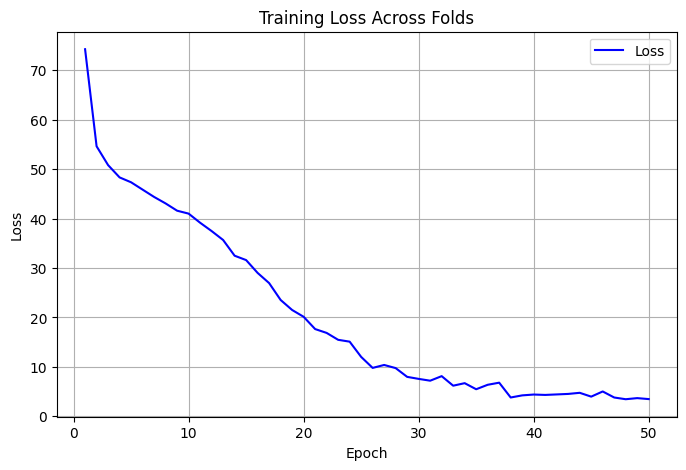

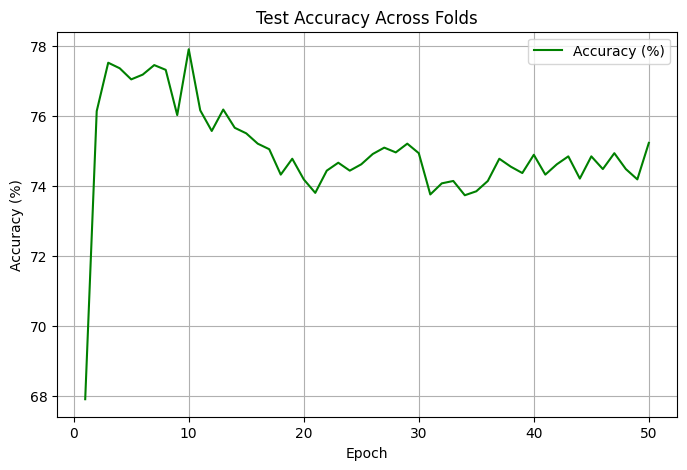

In [ ]:
train_5fold_cross_validation(TemporalTransformer, learning_rate=7e-4, feature_method='raw', subject_data= subject_data_preload)

In [ ]:
train_5fold_cross_validation(SpatialCNNTransformer, learning_rate=7e-4, feature_method='raw', subject_data= subject_data_preload)

In [ ]:
train_5fold_cross_validation(SpatialTransformer, learning_rate=7e-4, feature_method='stft', subject_data= subject_data_preload)

In [ ]:
train_5fold_cross_validation(SpatialTransformer, learning_rate=1e-4, feature_method='stft', subject_data= subject_data_preload)

NameError: name 'train_5fold_cross_validation' is not defined

In [ ]:
train_5fold_cross_validation(TemporalCNNTransformer, learning_rate=1e-4, feature_method='stft', subject_data= subject_data_preload)

In [ ]:
train_5fold_cross_validation(FusionCNNTransformer, learning_rate=1e-4, feature_method='stft', subject_data= subject_data_preload)

In [ ]:
train_5fold_cross_validation(TemporalCNNTransformer, learning_rate=1e-4, feature_method='cnn', subject_data= subject_data_preload)

NameError: name 'train_5fold_cross_validation' is not defined

In [ ]:
train_5fold_cross_validation(SpatialCNNTransformer, learning_rate=1e-4, feature_method='cnn', subject_data= subject_data_preload)

In [ ]:
train_5fold_cross_validation(SpatialCNNTransformer, learning_rate=7e-4, feature_method='cnn', subject_data= subject_data_preload)

In [ ]:
#-------------------------------------------------------------------------------------

Precomputing wavelet features for all subjects...
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat shape: (42, 64, 4, 249)
[DEBUG] X_feat

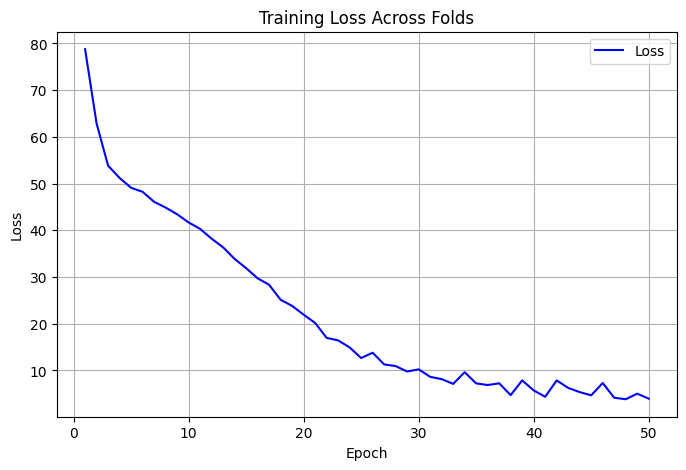

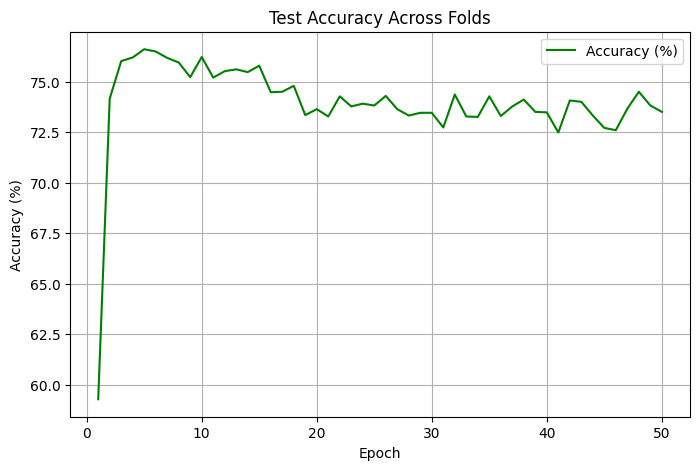

In [ ]:
train_5fold_cross_validation(TemporalTransformer, learning_rate=1e-4, feature_method='wavelet', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 481)
Fitting CSP on training data...
Computing rank from data with rank=None
    Using tolerance 1.2e+02 (2.2e-16 eps * 64 dim * 8.2e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using SHRINKAGE
Done.
Estimating class=1 covariance using SHRINKAGE
Done.
Epoch 1/50, Loss: 73.4407, Test Acc: 0.7166
Epoch 2/50, Loss: 57.1162, Test Acc: 0.7222
Epoch 3/50, Loss: 53.4709, Test Acc: 0.7381
Epoch 4/50, Loss: 49.2547, Test Acc: 0.7109
Epoch 5/50, Loss: 47.5303, Test Acc: 0.7234
Epoch 6/50, Loss: 45.0486, Test Acc: 0.7222
Epoch 7/50, Loss: 38.5347, Test Acc: 0.7177
Epoch 8/50, Loss: 33.8155, Test Acc: 0.7098
Epoch 9/50, Loss: 32.6645, Test Acc: 0.7018
Epoch 10/50, Loss: 27.7941, Test Acc: 0.7154
Epoch 11/50, Loss: 27.5169, Test Acc: 0.6916
Epoch 12/50, Loss: 20.8072, Test Acc: 0.7052
Epoch 13/50, Loss: 17.4638, Test

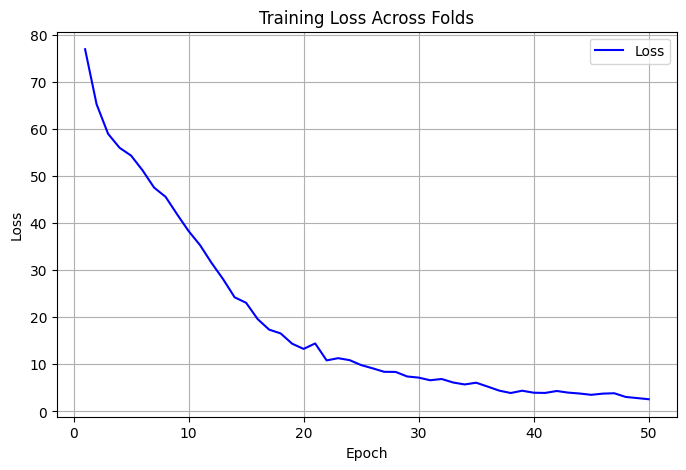

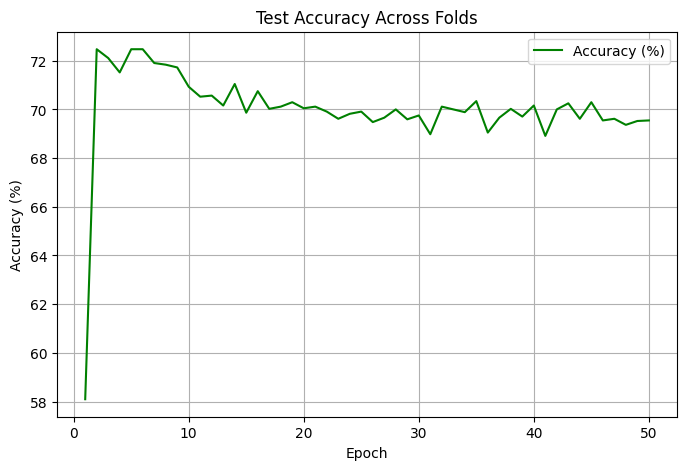

In [ ]:
train_5fold_cross_validation(FusionCNNTransformer, learning_rate=7e-3, feature_method='csp', subject_data= subject_data_preload)

Precomputing wavelet features for all subjects...
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat shape: (42, 64, 4, 244)
[DEBUG] X_feat

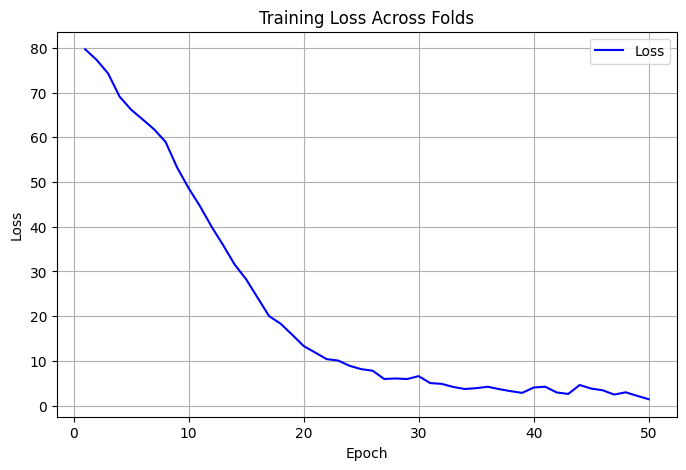

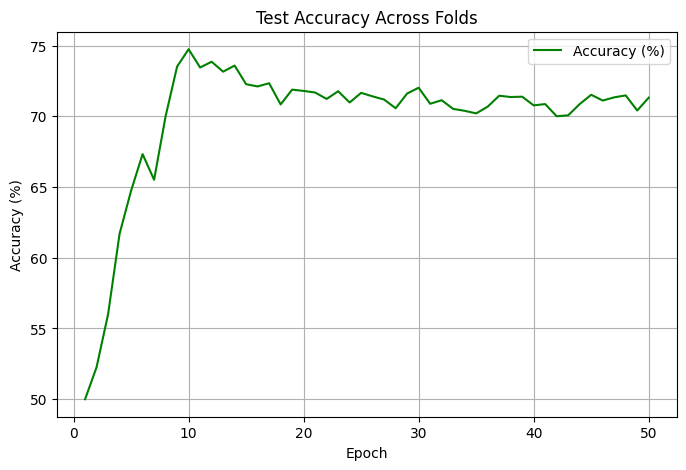

In [ ]:
train_5fold_cross_validation(FusionCNNTransformer, learning_rate=1e-3, feature_method='wavelet', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 481)
Fitting CSP on training data...
Computing rank from data with rank=None
    Using tolerance 1.2e+02 (2.2e-16 eps * 64 dim * 8.2e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using SHRINKAGE
Done.
Estimating class=1 covariance using SHRINKAGE
Done.
Epoch 1/50, Loss: 66.8066, Test Acc: 0.6723
Epoch 2/50, Loss: 62.3570, Test Acc: 0.6973
Epoch 3/50, Loss: 59.9944, Test Acc: 0.6995
Epoch 4/50, Loss: 55.3622, Test Acc: 0.7018
Epoch 5/50, Loss: 51.8938, Test Acc: 0.7063
Epoch 6/50, Loss: 47.3655, Test Acc: 0.6950
Epoch 7/50, Loss: 42.8833, Test Acc: 0.6995
Epoch 8/50, Loss: 39.0124, Test Acc: 0.6791
Epoch 9/50, Loss: 34.9774, Test Acc: 0.6780
Epoch 10/50, Loss: 31.2303, Test Acc: 0.6848
Epoch 11/50, Loss: 27.8954, Test Acc: 0.6678
Epoch 12/50, Loss: 23.3231, Test Acc: 0.6848
Epoch 13/50, Loss: 21.9052, Test

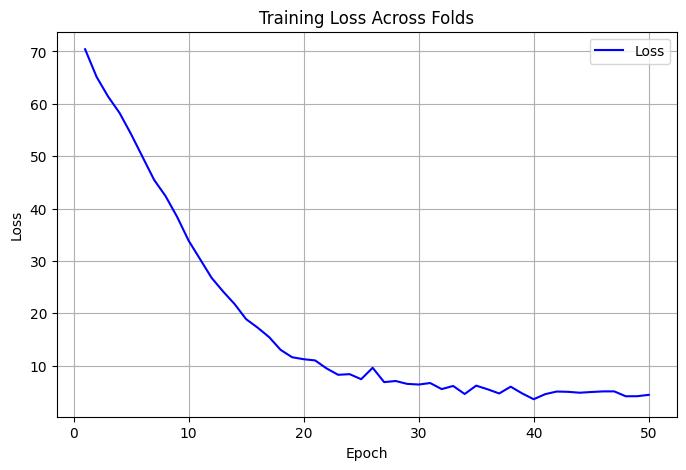

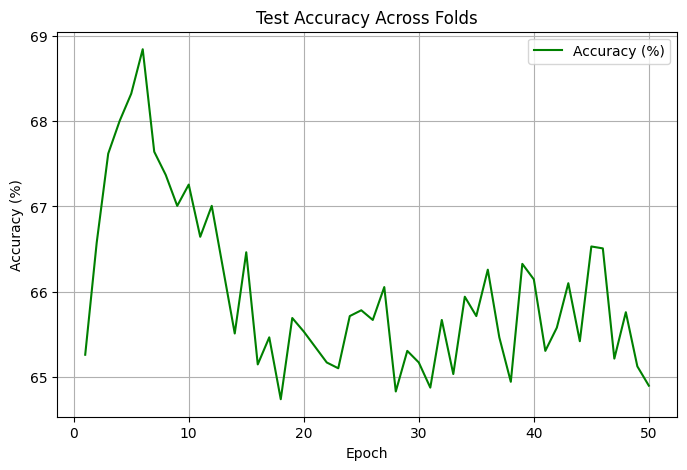

In [ ]:
train_5fold_cross_validation(TemporalTransformer, learning_rate=7e-3, feature_method='csp', subject_data= subject_data_preload)


Fold 1/5
[DEBUG] Input to model: (3528, 64, 481)
Fitting CSP on training data...
Computing rank from data with rank=None
    Using tolerance 1.2e+02 (2.2e-16 eps * 64 dim * 8.2e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using SHRINKAGE
Done.
Estimating class=1 covariance using SHRINKAGE
Done.
Epoch 1/50, Loss: 79.4586, Test Acc: 0.6565
Epoch 2/50, Loss: 68.1883, Test Acc: 0.6621
Epoch 3/50, Loss: 65.2606, Test Acc: 0.6780
Epoch 4/50, Loss: 62.9476, Test Acc: 0.6474
Epoch 5/50, Loss: 62.0884, Test Acc: 0.6848
Epoch 6/50, Loss: 61.3888, Test Acc: 0.7018
Epoch 7/50, Loss: 58.9519, Test Acc: 0.6825
Epoch 8/50, Loss: 59.4324, Test Acc: 0.7041
Epoch 9/50, Loss: 58.1014, Test Acc: 0.7177
Epoch 10/50, Loss: 57.8950, Test Acc: 0.6655
Epoch 11/50, Loss: 57.6768, Test Acc: 0.7063
Epoch 12/50, Loss: 57.3408, Test Acc: 0.7154
Epoch 13/50, Loss: 57.0595, Test

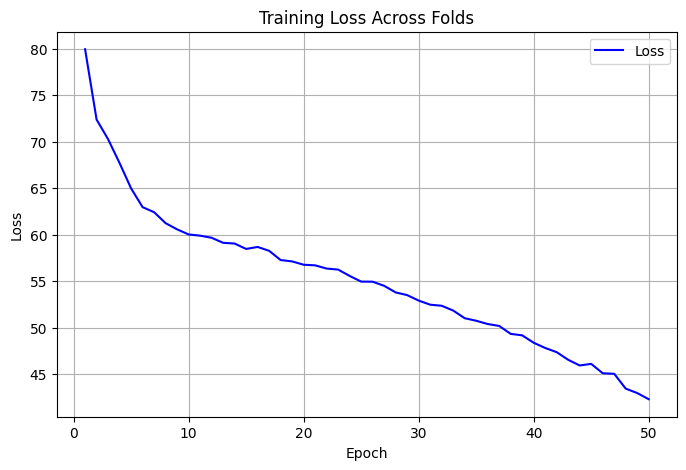

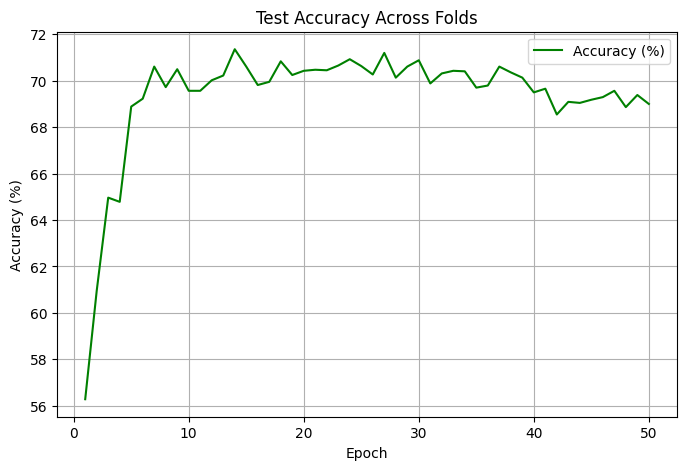

In [ ]:
train_5fold_cross_validation(TemporalCNNTransformer, learning_rate=7e-4, feature_method='csp', subject_data= subject_data_preload)

In [ ]:
import os
import pandas as pd
import re
import numbers

input_folder = f'/content/drive/My Drive/EEG_Data/Physionet/{SEGMENT_SIZE}s'
output_folder = f'/content/drive/My Drive/EEG_Data/Physionet/separate_results/{SEGMENT_SIZE}s'
os.makedirs(output_folder, exist_ok=True)

csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]
summaries = {method: [] for method in ['raw', 'cnn', 'csp', 'stft', 'wavelet', 'wavelet_packet']}
known_methods = ['raw', 'cnn', 'csp', 'stft', 'wavelet', 'wavelet_packet']
feature_method = None

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

for file in csv_files:
    filepath = os.path.join(input_folder, file)

    # Examples:
    # fold_cross_subject_accuracies_TemporalCNNTransformer_stft_nfft128_hop32_0.0001.csv
    # fold_cross_subject_accuracies_TemporalCNNTransformer_wavelet_db6_levels3_0.0001.csv
    # fold_cross_subject_accuracies_TemporalCNNTransformer_wavelet_packet_db6_levels3_0.0001.csv
    # fold_cross_subject_accuracies_TemporalCNNTransformer_raw_0.0007.csv
    # fold_cross_subject_accuracies_TemporalCNNTransformer_cnn_0.007.csv
    # fold_cross_subject_accuracies_TemporalCNNTransformer_csp_numcomp6_0.007.csv

    base_name = file[:-4]
    parts = base_name.split('_')

    feature_method = None
    try:
        model_idx = parts.index('accuracies') + 1
        model_name = parts[model_idx]

        method_idx = None

        # Try to match compound methods first
        for i in range(model_idx + 1, len(parts) - 1):
            compound = f"{parts[i]}_{parts[i + 1]}"
            if compound in known_methods:
                feature_method = compound
                method_idx = i
                break

        # If no compound match, try single-part methods
        if feature_method is None:
            for i in range(model_idx + 1, len(parts)):
                if parts[i] in known_methods:
                    feature_method = parts[i]
                    method_idx = i
                    break

        if feature_method is None:
            print(f"Unknown feature method in {file}")
            continue

        if feature_method is None:
            print(f"Unknown feature method in {file}")
            continue

    except (ValueError, IndexError):
        print(f"Cannot parse model and feature method in {file}")
        continue

    params = {}
    learning_rate = None
    learning_rate = next((part for part in reversed(parts) if re.match(r'^[\d\.]+$', part)), None)

    if feature_method == 'raw' or feature_method == 'cnn':
        pass

    elif feature_method == 'stft':
        for p in parts:
            if p.startswith('nfft'):
                params['nfft'] = p.replace('nfft', '')
            if p.startswith('hop'):
                params['hop'] = p.replace('hop', '')

    elif feature_method in ['wavelet', 'wavelet_packet']:
        wavelet_type_idx = method_idx + 1 if feature_method == 'wavelet' else method_idx + 2
        wavelet_type = parts[wavelet_type_idx] if wavelet_type_idx < len(parts) else "-"
        params['wavelet_type'] = wavelet_type if not is_number(wavelet_type) else "-"


    elif feature_method == 'csp':
        for p in parts:
            if p.startswith('numcomp'):
                params['num_components'] = p.replace('numcomp', '')
            if p.startswith('patchsize'):
                params['patch_size'] = p.replace('patchsize', '')


    df = pd.read_csv(filepath)
    if 'Accuracy' not in df.columns:
        print(f"No Accuracy column in {file}, skipping")
        continue

    mean_acc = df['Accuracy'].mean()
    mean_acc = round(mean_acc, 2)

    summary = {
        'Model': model_name,
        'Feature_Method': feature_method,
        'Learning_Rate': learning_rate,
        'Average_Accuracy(%)': mean_acc,
    }
    summary.update(params)
    summaries[feature_method].append(summary)

for method, rows in summaries.items():
    if rows:
        df_summary = pd.DataFrame(rows)

        df_summary = df_summary.sort_values(by=['Model', 'Average_Accuracy(%)'], ascending=[True, False])
        df_summary.to_csv(os.path.join(output_folder, f'{method}_summary.csv'), index=False)
        print(f"Saved summary for {method} with {len(rows)} entries")
    else:
        print(f"No data for feature method: {method}")

Saved summary for raw with 4 entries
No data for feature method: cnn
Saved summary for csp with 1 entries
Saved summary for stft with 10 entries
No data for feature method: wavelet
Saved summary for wavelet_packet with 10 entries


In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
train_5fold_cross_validation(SpatialCNNTransformer, learning_rate=7e-3, feature_method='csp', subject_data= subject_data_preload)

In [ ]:
train_5fold_cross_validation(TemporalCNNTransformer, learning_rate=1e-4, feature_method='stft', subject_data= subject_data_preload)

In [ ]:
!pip list

Package                               Version
------------------------------------- ------------------
absl-py                               1.4.0
absolufy-imports                      0.3.1
accelerate                            1.10.1
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.12.15
aiosignal                             1.4.0
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.2
alembic                               1.16.5
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.10.0
anywidget                             0.9.18
argon2-cffi                           25.1.0
argon2-cffi-bindings                  25.1.0
array_record                          0.8.1
arrow 

In [ ]:
train_5fold_cross_validation(TemporalTransformer, learning_rate=1e-3, feature_method='stft', subject_data= subject_data_preload)